In [1]:
import gc
import os
import json
import datasets
import minds
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from dotenv import load_dotenv
from huggingface_hub import HfApi, HfFolder, login
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings

from honeybee.loaders import (
    PDFreport,
    Scan,
    Slide,
    generate_summary_from_json,
    get_chunk_text,
)
from honeybee.models import REMEDIS, UNI, HuggingFaceEmbedder, TissueDetector

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")
load_dotenv()

True

In [2]:
def manifest_to_df(manifest_path, modality):
    with open(manifest_path, "r") as f:
        manifest = json.load(f)

    # Initialize an empty DataFrame for the modality
    modality_df = pd.DataFrame()

    # Process each patient in the manifest
    for patient in manifest:
        patient_id = patient["PatientID"]
        gdc_case_id = patient["gdc_case_id"]

        # Check if the current patient has the requested modality
        if modality in patient:
            # Convert the list of dictionaries into a DataFrame
            df = pd.DataFrame(patient[modality])
            # Add 'PatientID' and 'gdc_case_id' columns
            df["PatientID"] = patient_id
            df["gdc_case_id"] = gdc_case_id

            # Append the new data to the existing DataFrame for this modality
            modality_df = pd.concat([modality_df, df], ignore_index=True)

    # Check if the modality DataFrame is not empty before returning
    if not modality_df.empty:
        return modality_df
    else:
        return None

## Pathology Reports

In [3]:
DATA_DIR = "/mnt/d/TCGA-LUAD"
MANIFEST_PATH = "/mnt/d/TCGA-LUAD/manifest.json"
MODALITY = "Pathology Report"
PARQUET = f"/mnt/d/TCGA-LUAD/parquet/{MODALITY}.parquet"

df = manifest_to_df(MANIFEST_PATH, MODALITY)
embedding_model = HuggingFaceEmbedder(model_name="UFNLP/gatortron-base")
pdf_report = PDFreport(chunk_size=512, chunk_overlap=10)

report_texts = []
df["report_text"] = None
df["embedding"] = None
df["embedding_shape"] = None

writer = None
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    try:
        file_path = f"{DATA_DIR}/raw/{row['PatientID']}/{MODALITY}/{row['id']}/{row['file_name']}"
        report_text = pdf_report.load(file_path)
        report_texts.append(report_text)

        if len(report_text) > 0:
            embeddings = embedding_model.generate_embeddings(report_text)
            df.at[index, "embedding_shape"] = embeddings.shape
            embeddings = embeddings.reshape(-1)
            embeddings = embeddings.tobytes()
            df.at[index, "embedding"] = embeddings
        else:
            df.at[index, "embedding"] = None
        df.at[index, "report_text"] = report_text

    except Exception as e:
        print(f"Error: {e}")
        report_texts.append(None)
        df.at[index, "embedding"] = None

    if writer is None:
        schema = pa.Table.from_pandas(df.iloc[[index]]).schema
        writer = pq.ParquetWriter(PARQUET, schema)

    table = pa.Table.from_pandas(df.iloc[[index]], schema=schema)
    try:
        writer.write_table(table)
    except ValueError as e:
        print(f"Schema mismatch error: {e}")
        schema = table.schema
        writer = pq.ParquetWriter(PARQUET, schema)
        writer.write_table(table)

if writer is not None:
    writer.close()

gc.collect()
torch.cuda.empty_cache()

Processing: 100%|██████████| 523/523 [10:32<00:00,  1.21s/it]  


## Slide Image

Processing: 100%|██████████| 1608/1608 [3:39:36<00:00,  8.19s/it]  


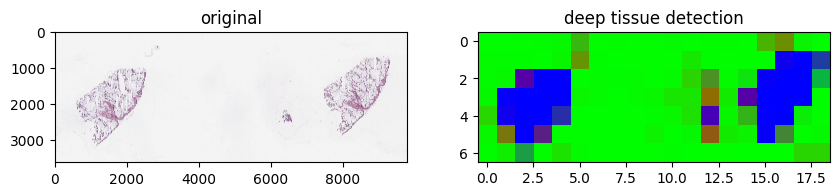

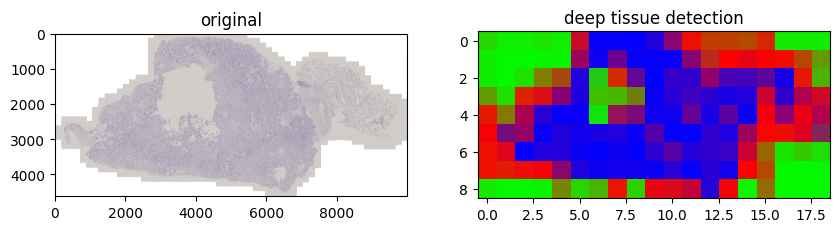

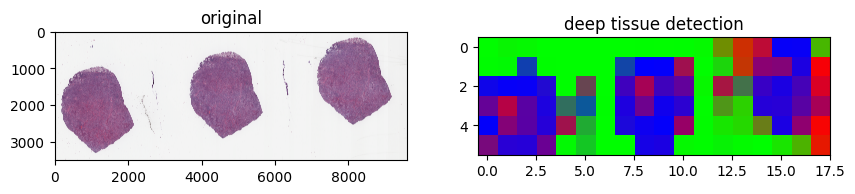

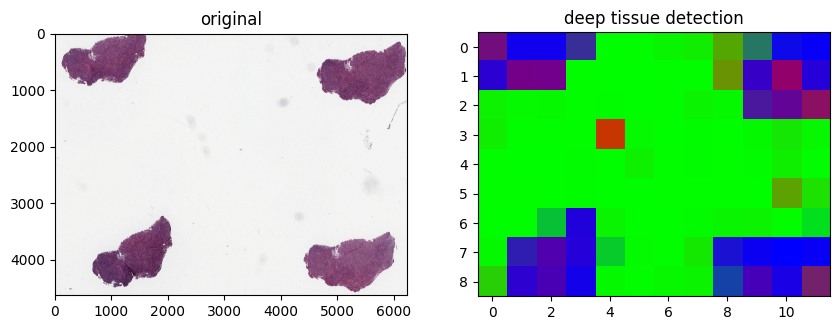

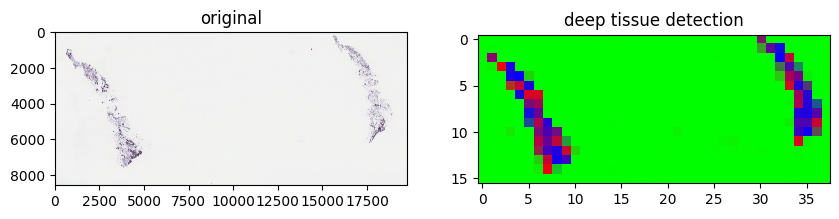

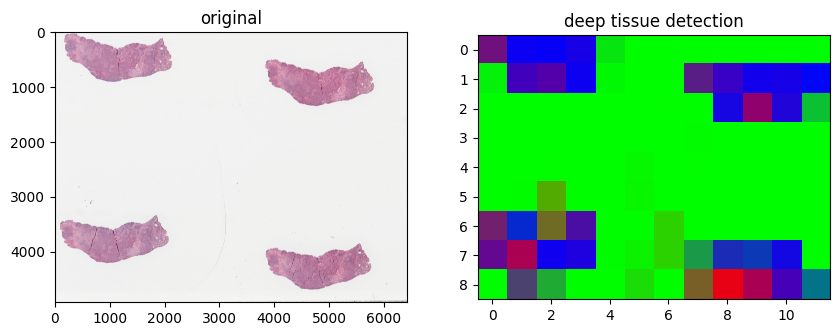

In [4]:
DATA_DIR = "/mnt/d/TCGA-LUAD"
MANIFEST_PATH = "/mnt/d/TCGA-LUAD/manifest.json"
MODALITY = "Slide Image"
PARQUET = f"/mnt/d/TCGA-LUAD/parquet/{MODALITY}.parquet"
HE_DETECTOR_PATH = "/mnt/f/Projects/Multimodal-Transformer/models/deep-tissue-detector_densenet_state-dict.pt"
EMBEDDING_MODEL_PATH = (
    "/mnt/d/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/pytorch_model.bin"
)

df = manifest_to_df(MANIFEST_PATH, MODALITY)
tissue_detector = TissueDetector(model_path=HE_DETECTOR_PATH)
embedding_model_path = EMBEDDING_MODEL_PATH
uni = UNI()

df["embedding"] = None
df["embedding_shape"] = None
writer = None
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    try:
        slide_image_path = f"{DATA_DIR}/raw/{row['PatientID']}/{MODALITY}/{row['id']}/{row['file_name']}"
        slide = Slide(
            slide_image_path,
            tileSize=512,
            max_patches=100,
            visualize=False,
            tissue_detector=tissue_detector,
        )
        patches = slide.load_patches_concurrently(target_patch_size=224)

        if patches.shape[0] == 0:
            slide = Slide(
                slide_image_path,
                tileSize=512,
                max_patches=1000,
                visualize=True,
                tissue_detector=tissue_detector,
            )
            patches = slide.load_patches_concurrently(target_patch_size=224)

            if patches.shape[0] == 0:
                with open("errors.txt", "a") as f:
                    f.write(f"{slide_image_path} | No patches extracted.\n")
                raise ValueError("No patches extracted.")

        embedding = uni.load_model_and_predict(embedding_model_path, patches)
        df.at[index, "embedding_shape"] = embedding.shape
        embedding = embedding.reshape(-1)
        embedding = np.array(embedding, dtype=np.float32)
        embedding = embedding.tobytes()
        df.at[index, "embedding"] = embedding
    except Exception as e:
        with open("errors.txt", "a") as f:
            f.write(f"{slide_image_path} | {e}\n")
        df.at[index, "embedding"] = None
        continue

    if writer is None:
        table = pa.Table.from_pandas(df.iloc[[index]])
        writer = pq.ParquetWriter(PARQUET, table.schema)
    else:
        table = pa.Table.from_pandas(df.iloc[[index]])
        writer.write_table(table)

    del slide, patches, embedding, table
    gc.collect()
    torch.cuda.empty_cache()

if writer is not None:
    writer.close()

## CT

In [5]:
DATA_DIR = "/mnt/d/TCGA/raw/TCGA-LUAD"
MANIFEST_PATH = "/mnt/d/TCGA/raw/TCGA-LUAD/manifest.json"
MODALITY = "CT"
PARQUET = f"/mnt/d/TCGA-LUAD/parquet/{MODALITY}.parquet"

df = manifest_to_df(MANIFEST_PATH, MODALITY)

# --- CONFIGURATION ---
embedding_model_path = "/mnt/d/Models/REMEDIS/onnx/cxr-50x1-remedis-m.onnx"

# Define a consistent schema
schema = pa.schema(
    [
        ("StudyInstanceUID", pa.string()),
        ("SeriesInstanceUID", pa.string()),
        ("SeriesDate", pa.string()),
        ("BodyPartExamined", pa.string()),
        ("SeriesNumber", pa.string()),
        ("Collection", pa.string()),
        ("Manufacturer", pa.string()),
        ("ManufacturerModelName", pa.string()),
        ("SoftwareVersions", pa.string()),
        ("Visibility", pa.string()),
        ("ImageCount", pa.int64()),
        ("PatientID", pa.string()),
        ("gdc_case_id", pa.string()),
        ("ProtocolName", pa.string()),
        ("SeriesDescription", pa.string()),
        ("embedding", pa.binary()),
        ("embedding_shape", pa.list_(pa.int64())),
        ("__index_level_0__", pa.int64()),
    ]
)

df["embedding"] = None
df["embedding_shape"] = None
writer = None
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    try:
        file_path = f"{DATA_DIR}/raw/{row['PatientID']}/{MODALITY}/{row['SeriesInstanceUID']}/{row['SeriesInstanceUID']}"
        scanner = Scan(file_path, modality="CT")
        patches = scanner.load_patches(target_patch_size=448)
        embedding = REMEDIS.load_model_and_predict(embedding_model_path, patches)
        df.at[index, "embedding_shape"] = embedding.shape
        embedding = embedding.reshape(-1)
        embedding = embedding.tobytes()
        df.at[index, "embedding"] = embedding
    except Exception as e:
        print(f"\033[91mError: {e}\033[0m")
        df.at[index, "embedding"] = None
        scanner = None
        patches = None
        embedding = None
        table = None

    if writer is None:
        table = pa.Table.from_pandas(df.iloc[[index]])
        writer = pq.ParquetWriter(PARQUET, schema)
    else:
        table = pa.Table.from_pandas(df.iloc[[index]], schema=schema)
        writer.write_table(table)

    del scanner, patches, embedding, table
    gc.collect()
    torch.cuda.empty_cache()

if writer is not None:
    writer.close()

Processing:   0%|          | 0/551 [00:00<?, ?it/s]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.193487924462588960549189071833/1.3.6.1.4.1.14519.5.2.1.7777.9002.193487924462588960549189071833
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   0%|          | 1/551 [00:05<47:43,  5.21s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.144528617248654843333500404696/1.3.6.1.4.1.14519.5.2.1.7777.9002.144528617248654843333500404696
Reading DICOM (examining files): 1/24 files (4.2%13/24 files (54.2%24/24 files (100.024/24 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   0%|          | 2/551 [00:10<45:50,  5.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240
Reading DICOM (examining files): 1/25 files (4.0%17/25 files (68.0%25/25 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   1%|          | 3/551 [00:14<44:27,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AD/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.130748219459143807687256345136/1.3.6.1.4.1.14519.5.2.1.3983.9002.130748219459143807687256345136
Reading DICOM (examining files): 1/268 files (0.413/268 files (4.9%24/268 files (9.0%35/268 files (13.147/268 files (17.559/268 files (22.071/268 files (26.583/268 files (31.095/268 files (35.4109/268 files (40.7%122/268 files (45.5%135/268 files (50.4%149/268 files (55.6%163/268 files (60.8%176/268 files (65.7%188/268 files (70.1%200/268 files (74.6%212/268 files (79.1%222/268 files (82.8%233/268 files (86.9%245/268 files (91.4%257/268 files (95.9%268/268 files (100.0268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   1%|          | 4/551 [00:23<57:24,  6.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AD/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.646839648436069661134190940622/1.3.6.1.4.1.14519.5.2.1.3983.9002.646839648436069661134190940622
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1503, 888) and 2 dimensions


Processing:   1%|          | 5/551 [00:27<51:20,  5.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.289464862030274248702636844140/1.3.6.1.4.1.14519.5.2.1.6450.9002.289464862030274248702636844140
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   1%|          | 6/551 [00:32<47:48,  5.26s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.168355555300842998343587293180/1.3.6.1.4.1.14519.5.2.1.6450.9002.168355555300842998343587293180
Reading DICOM (examining files): 1/227 files (0.414/227 files (6.2%27/227 files (11.940/227 files (17.653/227 files (23.366/227 files (29.179/227 files (34.893/227 files (41.0107/227 files (47.1%119/227 files (52.4%132/227 files (58.1%144/227 files (63.4%156/227 files (68.7%168/227 files (74.0%181/227 files (79.7%194/227 files (85.5%207/227 files (91.2%219/227 files (96.5%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   1%|▏         | 7/551 [00:39<54:39,  6.03s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.320620984145155356365800134019/1.3.6.1.4.1.14519.5.2.1.6450.9002.320620984145155356365800134019
Reading DICOM (examining files): 1/227 files (0.415/227 files (6.6%28/227 files (12.341/227 files (18.155/227 files (24.267/227 files (29.578/227 files (34.490/227 files (39.6103/227 files (45.4%115/227 files (50.7%129/227 files (56.8%141/227 files (62.1%154/227 files (67.8%168/227 files (74.0%182/227 files (80.2%196/227 files (86.3%209/227 files (92.1%222/227 files (97.8%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   1%|▏         | 8/551 [00:47<59:10,  6.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.334752481840162574804029567948/1.3.6.1.4.1.14519.5.2.1.6450.9002.334752481840162574804029567948
Reading DICOM (examining files): 1/517 files (0.213/517 files (2.5%26/517 files (5.0%39/517 files (7.5%52/517 files (10.166/517 files (12.879/517 files (15.391/517 files (17.6102/517 files (19.7%113/517 files (21.9%125/517 files (24.2%137/517 files (26.5%151/517 files (29.2%164/517 files (31.7%177/517 files (34.2%190/517 files (36.8%203/517 files (39.3%216/517 files (41.8%229/517 files (44.3%240/517 files (46.4%252/517 files (48.7%263/517 files (50.9%274/517 files (53.0%287/517 files (55.5%300/517 files (58.0%313/517 files (60.5%326/517 files (63.1%339/517 files (65.6%350/517 files (67.7%361/517 files (69.8%374/517 files (72.3%387/517 files (74.9%400/517 files (77.4%413/517 files (79.9%425/517 files (82.2%436/517 files (84.3%449/517 files (86.8%462/517 files (89.4%475/517 files (91.9%487/517 

Processing:   2%|▏         | 9/551 [00:59<1:13:40,  8.16s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.143570902553045106892751408393/1.3.6.1.4.1.14519.5.2.1.6450.9002.143570902553045106892751408393
Reading DICOM (examining files): 1/517 files (0.214/517 files (2.7%26/517 files (5.0%40/517 files (7.7%53/517 files (10.367/517 files (13.080/517 files (15.592/517 files (17.8104/517 files (20.1%115/517 files (22.2%128/517 files (24.8%139/517 files (26.9%150/517 files (29.0%162/517 files (31.3%175/517 files (33.8%188/517 files (36.4%201/517 files (38.9%214/517 files (41.4%226/517 files (43.7%239/517 files (46.2%251/517 files (48.5%263/517 files (50.9%275/517 files (53.2%288/517 files (55.7%302/517 files (58.4%315/517 files (60.9%328/517 files (63.4%341/517 files (66.0%354/517 files (68.5%366/517 files (70.8%379/517 files (73.3%392/517 files (75.8%404/517 files (78.1%416/517 files (80.5%428/517 files (82.8%440/517 files (85.1%453/517 files (87.6%466/517 files (90.1%479/517 files (92.6%492/517 

Processing:   2%|▏         | 10/551 [01:10<1:23:27,  9.26s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.797514848365337123093466281487/1.3.6.1.4.1.14519.5.2.1.6450.9002.797514848365337123093466281487
Reading DICOM (examining files): 1/575 files (0.214/575 files (2.4%26/575 files (4.5%38/575 files (6.6%51/575 files (8.9%64/575 files (11.178/575 files (13.691/575 files (15.8104/575 files (18.1%115/575 files (20.0%127/575 files (22.1%139/575 files (24.2%152/575 files (26.4%165/575 files (28.7%177/575 files (30.8%190/575 files (33.0%204/575 files (35.5%217/575 files (37.7%230/575 files (40.0%243/575 files (42.3%254/575 files (44.2%266/575 files (46.3%279/575 files (48.5%291/575 files (50.6%303/575 files (52.7%316/575 files (55.0%329/575 files (57.2%342/575 files (59.5%355/575 files (61.7%367/575 files (63.8%380/575 files (66.1%392/575 files (68.2%405/575 files (70.4%418/575 files (72.7%431/575 files (75.0%445/575 files (77.4%458/575 files (79.7%471/575 files (81.9%483/575 files (84.0%496/575 

Processing:   2%|▏         | 11/551 [01:23<1:32:15, 10.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.141004994853145237754973938025/1.3.6.1.4.1.14519.5.2.1.6450.9002.141004994853145237754973938025
Reading DICOM (examining files): 1/152 files (0.714/152 files (9.2%27/152 files (17.839/152 files (25.752/152 files (34.266/152 files (43.479/152 files (52.091/152 files (59.9102/152 files (67.1%114/152 files (75.0%126/152 files (82.9%138/152 files (90.8%152/152 files (100.0%  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 152/152 files (100.0152/152 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:   2%|▏         | 12/551 [01:25<1:10:13,  7.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.212096199865546132848990878032/1.3.6.1.4.1.14519.5.2.1.6450.9002.212096199865546132848990878032
Reading DICOM (examining files): 1/62 files (1.6%14/62 files (22.6%27/62 files (43.5%40/62 files (64.5%53/62 files (85.5  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 53/62 files (85.5%62/62 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:   2%|▏         | 13/551 [01:26<51:45,  5.77s/it]  

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.356176703771247252110459950151/1.3.6.1.4.1.14519.5.2.1.6450.9002.356176703771247252110459950151
Reading DICOM (examining files): 1/71 files (1.4%13/71 files (18.3%25/71 files (35.2%38/71 files (53.5%51/71 files (71.8%64/71 files (90.1%71/71 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   3%|▎         | 14/551 [01:32<51:10,  5.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.293696906565650685431674355076/1.3.6.1.4.1.14519.5.2.1.6450.9002.293696906565650685431674355076
Reading DICOM (examining files): 1/71 files (1.4%14/71 files (19.7%26/71 files (36.6%37/71 files (52.1%47/71 files (66.2%59/71 files (83.1%71/71 files (100.071/71 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   3%|▎         | 15/551 [01:37<50:41,  5.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.240127404385634166964459178875/1.3.6.1.4.1.14519.5.2.1.6450.9002.240127404385634166964459178875
Reading DICOM (examining files): 1/15 files (6.7%13/15 files (86.7%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   3%|▎         | 16/551 [01:42<47:53,  5.37s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.231375308484056068267383321505/1.3.6.1.4.1.14519.5.2.1.6450.9002.231375308484056068267383321505
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:   3%|▎         | 17/551 [01:47<45:22,  5.10s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.118483804431458136318534482942/1.3.6.1.4.1.14519.5.2.1.6450.9002.118483804431458136318534482942
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (345, 512) and 2 dimensions


Processing:   3%|▎         | 18/551 [01:51<43:35,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.960610543271693337740482841380/1.3.6.1.4.1.14519.5.2.1.6450.9002.960610543271693337740482841380
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:   3%|▎         | 19/551 [01:55<42:14,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6592/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.269093132658021542442046711648/1.3.6.1.4.1.14519.5.2.1.6450.9002.269093132658021542442046711648
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (788, 888) and 2 dimensions


Processing:   4%|▎         | 20/551 [02:00<41:18,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4625/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.641712128650438227234886571437/1.3.6.1.4.1.14519.5.2.1.8421.9002.641712128650438227234886571437
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   4%|▍         | 21/551 [02:04<40:25,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4625/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.159519804276178128800431863758/1.3.6.1.4.1.14519.5.2.1.8421.9002.159519804276178128800431863758
Reading DICOM (examining files): 1/39 files (2.6%14/39 files (35.9%26/39 files (66.7%38/39 files (97.4%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   4%|▍         | 22/551 [02:09<41:08,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4625/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.450738766620813815553903340483/1.3.6.1.4.1.14519.5.2.1.8421.9002.450738766620813815553903340483
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   4%|▍         | 23/551 [02:13<40:15,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6590/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.144474035642798258977926389942/1.3.6.1.4.1.14519.5.2.1.6450.9002.144474035642798258977926389942
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   4%|▍         | 24/551 [02:18<39:49,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6590/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.216176897913679442475013148754/1.3.6.1.4.1.14519.5.2.1.6450.9002.216176897913679442475013148754
Reading DICOM (examining files): 1/263 files (0.416/263 files (6.1%30/263 files (11.444/263 files (16.757/263 files (21.769/263 files (26.282/263 files (31.295/263 files (36.1109/263 files (41.4%123/263 files (46.8%137/263 files (52.1%149/263 files (56.7%163/263 files (62.0%176/263 files (66.9%188/263 files (71.5%199/263 files (75.7%211/263 files (80.2%225/263 files (85.6%238/263 files (90.5%251/263 files (95.4%263/263 files (100.0263/263 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▍         | 25/551 [02:26<48:53,  5.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6590/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.151711845036410681055821419458/1.3.6.1.4.1.14519.5.2.1.6450.9002.151711845036410681055821419458
Reading DICOM (examining files): 1/263 files (0.415/263 files (5.7%29/263 files (11.042/263 files (16.055/263 files (20.968/263 files (25.982/263 files (31.296/263 files (36.5109/263 files (41.4%121/263 files (46.0%132/263 files (50.2%145/263 files (55.1%157/263 files (59.7%169/263 files (64.3%181/263 files (68.8%194/263 files (73.8%208/263 files (79.1%221/263 files (84.0%234/263 files (89.0%247/263 files (93.9%260/263 files (98.9%263/263 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▍         | 26/551 [02:34<55:19,  6.32s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.155014180250322871823641948948/1.3.6.1.4.1.14519.5.2.1.8421.9002.155014180250322871823641948948
Reading DICOM (examining files): 1/64 files (1.6%16/64 files (25.0%30/64 files (46.9%42/64 files (65.6%53/64 files (82.8%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▍         | 27/551 [02:39<52:23,  6.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.195808209466695098325013088916/1.3.6.1.4.1.14519.5.2.1.8421.9002.195808209466695098325013088916
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▌         | 28/551 [02:44<48:19,  5.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.899637429984648811720347907566/1.3.6.1.4.1.14519.5.2.1.8421.9002.899637429984648811720347907566
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▌         | 29/551 [02:48<45:12,  5.20s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.168587139168172602702173007568/1.3.6.1.4.1.14519.5.2.1.8421.9002.168587139168172602702173007568
Reading DICOM (examining files): 1/55 files (1.8%16/55 files (29.1%30/55 files (54.5%45/55 files (81.8%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   5%|▌         | 30/551 [02:53<44:51,  5.17s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.923671239474578276111949453641/1.3.6.1.4.1.14519.5.2.1.8421.9002.923671239474578276111949453641
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   6%|▌         | 31/551 [02:58<42:37,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4629/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.872539592891030727910524205309/1.3.6.1.4.1.14519.5.2.1.8421.9002.872539592891030727910524205309
Reading DICOM (examining files): 1/63 files (1.6%15/63 files (23.8%29/63 files (46.0%42/63 files (66.7%56/63 files (88.9%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   6%|▌         | 32/551 [03:03<43:09,  4.99s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.320679027608000687591928843096/1.3.6.1.4.1.14519.5.2.1.6450.9002.320679027608000687591928843096
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:   6%|▌         | 33/551 [03:07<41:34,  4.81s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.323744164395727327590329158420/1.3.6.1.4.1.14519.5.2.1.6450.9002.323744164395727327590329158420
Reading DICOM (examining files): 1/66 files (1.5%14/66 files (21.2%26/66 files (39.4%40/66 files (60.6%52/66 files (78.8%65/66 files (98.5%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   6%|▌         | 34/551 [03:12<42:38,  4.95s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.248199601481656697949812913992/1.3.6.1.4.1.14519.5.2.1.6450.9002.248199601481656697949812913992
Reading DICOM (examining files): 1/66 files (1.5%15/66 files (22.7%28/66 files (42.4%42/66 files (63.6%54/66 files (81.8%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   6%|▋         | 35/551 [03:17<42:59,  5.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.280396351248518190986957310952/1.3.6.1.4.1.14519.5.2.1.6450.9002.280396351248518190986957310952
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1650, 888) and 2 dimensions


Processing:   7%|▋         | 36/551 [03:22<41:23,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.203648771004802075904617227084/1.3.6.1.4.1.14519.5.2.1.6450.9002.203648771004802075904617227084
Reading DICOM (examining files): 1/148 files (0.713/148 files (8.8%26/148 files (17.639/148 files (26.453/148 files (35.867/148 files (45.381/148 files (54.795/148 files (64.2109/148 files (73.6%123/148 files (83.1%136/148 files (91.9%147/148 files (99.3%148/148 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   7%|▋         | 37/551 [03:28<45:05,  5.26s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.160603992769469736388947327838/1.3.6.1.4.1.14519.5.2.1.6450.9002.160603992769469736388947327838
Reading DICOM (examining files): 1/268 files (0.416/268 files (6.0%32/268 files (11.948/268 files (17.963/268 files (23.578/268 files (29.193/268 files (34.7109/268 files (40.7%123/268 files (45.9%136/268 files (50.7%152/268 files (56.7%167/268 files (62.3%181/268 files (67.5%194/268 files (72.4%208/268 files (77.6%223/268 files (83.2%238/268 files (88.8%251/268 files (93.7%267/268 files (99.6%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   7%|▋         | 38/551 [03:36<50:46,  5.94s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.379381983062361120381828578254/1.3.6.1.4.1.14519.5.2.1.6450.9002.379381983062361120381828578254
Reading DICOM (examining files): 1/349 files (0.317/349 files (4.9%31/349 files (8.9%46/349 files (13.260/349 files (17.273/349 files (20.986/349 files (24.6100/349 files (28.7%114/349 files (32.7%129/349 files (37.0%144/349 files (41.3%158/349 files (45.3%172/349 files (49.3%188/349 files (53.9%204/349 files (58.5%218/349 files (62.5%229/349 files (65.6%244/349 files (69.9%259/349 files (74.2%274/349 files (78.5%289/349 files (82.8%304/349 files (87.1%319/349 files (91.4%332/349 files (95.1%346/349 files (99.1%349/349 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   7%|▋         | 39/551 [03:44<57:22,  6.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.327242609312583228767452269043/1.3.6.1.4.1.14519.5.2.1.6450.9002.327242609312583228767452269043
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1650, 888) and 2 dimensions


Processing:   7%|▋         | 40/551 [03:49<51:07,  6.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.683075781678687434856657608318/1.3.6.1.4.1.14519.5.2.1.6450.9002.683075781678687434856657608318
Reading DICOM (examining files): 1/149 files (0.714/149 files (9.4%27/149 files (18.141/149 files (27.555/149 files (36.969/149 files (46.383/149 files (55.795/149 files (63.8107/149 files (71.8%121/149 files (81.2%135/149 files (90.6%149/149 files (100.0149/149 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   7%|▋         | 41/551 [03:55<51:57,  6.11s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.166343715953064755389331244908/1.3.6.1.4.1.14519.5.2.1.6450.9002.166343715953064755389331244908
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   8%|▊         | 42/551 [03:59<47:30,  5.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.778031780013017127114983017082/1.3.6.1.4.1.14519.5.2.1.6450.9002.778031780013017127114983017082
Reading DICOM (examining files): 1/268 files (0.415/268 files (5.6%28/268 files (10.441/268 files (15.354/268 files (20.167/268 files (25.081/268 files (30.292/268 files (34.3106/268 files (39.6%120/268 files (44.8%133/268 files (49.6%146/268 files (54.5%159/268 files (59.3%172/268 files (64.2%185/268 files (69.0%197/268 files (73.5%210/268 files (78.4%224/268 files (83.6%238/268 files (88.8%251/268 files (93.7%264/268 files (98.5%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   8%|▊         | 43/551 [04:07<53:09,  6.28s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.138126480457862075495863975412/1.3.6.1.4.1.14519.5.2.1.6450.9002.138126480457862075495863975412
Reading DICOM (examining files): 1/349 files (0.314/349 files (4.0%29/349 files (8.3%44/349 files (12.658/349 files (16.673/349 files (20.988/349 files (25.2104/349 files (29.8%120/349 files (34.4%135/349 files (38.7%149/349 files (42.7%165/349 files (47.3%180/349 files (51.6%195/349 files (55.9%211/349 files (60.5%226/349 files (64.8%241/349 files (69.1%256/349 files (73.4%271/349 files (77.7%286/349 files (81.9%301/349 files (86.2%314/349 files (90.0%328/349 files (94.0%344/349 files (98.6%349/349 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   8%|▊         | 44/551 [04:16<58:28,  6.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5072/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.747485993156290148171122461766/1.3.6.1.4.1.14519.5.2.1.6450.9002.747485993156290148171122461766
Reading DICOM (examining files): 1/517 files (0.214/517 files (2.7%27/517 files (5.2%41/517 files (7.9%55/517 files (10.670/517 files (13.586/517 files (16.6102/517 files (19.7%118/517 files (22.8%133/517 files (25.7%147/517 files (28.4%160/517 files (30.9%173/517 files (33.5%188/517 files (36.4%201/517 files (38.9%216/517 files (41.8%232/517 files (44.9%247/517 files (47.8%261/517 files (50.5%275/517 files (53.2%288/517 files (55.7%302/517 files (58.4%314/517 files (60.7%327/517 files (63.2%339/517 files (65.6%351/517 files (67.9%364/517 files (70.4%378/517 files (73.1%392/517 files (75.8%406/517 files (78.5%419/517 files (81.0%432/517 files (83.6%443/517 files (85.7%454/517 files (87.8%466/517 files (90.1%479/517 files (92.6%493/517 files (95.4%507/517 files (98.1%517/517 files (100.0%)
  F

Processing:   8%|▊         | 45/551 [04:27<1:08:26,  8.12s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.993112759700009144985844062228/1.3.6.1.4.1.14519.5.2.1.7777.9002.993112759700009144985844062228
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   8%|▊         | 46/551 [04:31<58:43,  6.98s/it]  

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.335607746166421447688402796816/1.3.6.1.4.1.14519.5.2.1.7777.9002.335607746166421447688402796816
Reading DICOM (examining files): 1/405 files (0.215/405 files (3.7%29/405 files (7.2%43/405 files (10.657/405 files (14.169/405 files (17.082/405 files (20.295/405 files (23.5108/405 files (26.7%122/405 files (30.1%136/405 files (33.6%150/405 files (37.0%165/405 files (40.7%180/405 files (44.4%193/405 files (47.7%203/405 files (50.1%217/405 files (53.6%231/405 files (57.0%245/405 files (60.5%260/405 files (64.2%275/405 files (67.9%290/405 files (71.6%305/405 files (75.3%320/405 files (79.0%333/405 files (82.2%347/405 files (85.7%361/405 files (89.1%373/405 files (92.1%386/405 files (95.3%397/405 files (98.0%405/405 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▊         | 47/551 [04:41<1:05:28,  7.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.225686572570219561698909893450/1.3.6.1.4.1.14519.5.2.1.7777.9002.225686572570219561698909893450
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▊         | 48/551 [04:45<56:56,  6.79s/it]  

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.167364457938835057991221483899/1.3.6.1.4.1.14519.5.2.1.7777.9002.167364457938835057991221483899
Reading DICOM (examining files): 1/72 files (1.4%15/72 files (20.8%30/72 files (41.7%44/72 files (61.1%58/72 files (80.6%72/72 files (100.072/72 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▉         | 49/551 [04:50<52:43,  6.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.100460393058091504556496290741/1.3.6.1.4.1.14519.5.2.1.7777.9002.100460393058091504556496290741
Reading DICOM (examining files): 1/68 files (1.5%14/68 files (20.6%27/68 files (39.7%41/68 files (60.3%57/68 files (83.8%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▉         | 50/551 [04:55<49:44,  5.96s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.304047785393437686918933677610/1.3.6.1.4.1.14519.5.2.1.7777.9002.304047785393437686918933677610
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▉         | 51/551 [05:00<45:54,  5.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.161807710484306441994001654470/1.3.6.1.4.1.14519.5.2.1.7777.9002.161807710484306441994001654470
Reading DICOM (examining files): 1/66 files (1.5%16/66 files (24.2%31/66 files (47.0%44/66 files (66.7%56/66 files (84.8%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:   9%|▉         | 52/551 [05:05<45:06,  5.42s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.279128212985261090333157160995/1.3.6.1.4.1.14519.5.2.1.7777.9002.279128212985261090333157160995
Reading DICOM (examining files): 1/66 files (1.5%15/66 files (22.7%29/66 files (43.9%42/66 files (63.6%56/66 files (84.8%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  10%|▉         | 53/551 [05:10<44:26,  5.35s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.121751937995121767963651135270/1.3.6.1.4.1.14519.5.2.1.7777.9002.121751937995121767963651135270
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  10%|▉         | 54/551 [05:15<42:07,  5.09s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.220374895842569016427663023906/1.3.6.1.4.1.14519.5.2.1.7777.9002.220374895842569016427663023906
Reading DICOM (examining files): 1/67 files (1.5%13/67 files (19.4%26/67 files (38.8%37/67 files (55.2%49/67 files (73.1%63/67 files (94.0%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  10%|▉         | 55/551 [05:20<42:27,  5.14s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.485520135177951841685811815868/1.3.6.1.4.1.14519.5.2.1.7777.9002.485520135177951841685811815868
Reading DICOM (examining files): 1/64 files (1.6%16/64 files (25.0%31/64 files (48.4%44/64 files (68.8%56/64 files (87.5%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  10%|█         | 56/551 [05:25<42:22,  5.14s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z050/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.807725458287110453390105047556/1.3.6.1.4.1.14519.5.2.1.7777.9002.807725458287110453390105047556
Reading DICOM (examining files): 1/32 files (3.1%16/32 files (50.0%31/32 files (96.9%32/32 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  10%|█         | 57/551 [05:30<41:19,  5.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.563936107215740072519661053705/1.3.6.1.4.1.14519.5.2.1.8421.9002.563936107215740072519661053705
Reading DICOM (examining files): 1/41 files (2.4%16/41 files (39.0%31/41 files (75.6%41/41 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█         | 58/551 [05:35<40:27,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.284952935232586202428492944502/1.3.6.1.4.1.14519.5.2.1.8421.9002.284952935232586202428492944502
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█         | 59/551 [05:39<38:35,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.300470692467676570762230629330/1.3.6.1.4.1.14519.5.2.1.8421.9002.300470692467676570762230629330
Reading DICOM (examining files): 1/65 files (1.5%18/65 files (27.7%34/65 files (52.3%50/65 files (76.9%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█         | 60/551 [05:44<38:52,  4.75s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.184810787449219247125405222428/1.3.6.1.4.1.14519.5.2.1.8421.9002.184810787449219247125405222428
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█         | 61/551 [05:48<37:30,  4.59s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.133443429102578041402636443258/1.3.6.1.4.1.14519.5.2.1.8421.9002.133443429102578041402636443258
Reading DICOM (examining files): 1/62 files (1.6%15/62 files (24.2%29/62 files (46.8%42/62 files (67.7%57/62 files (91.9%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█▏        | 62/551 [05:53<38:32,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4626/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.260305592906303162525017714813/1.3.6.1.4.1.14519.5.2.1.8421.9002.260305592906303162525017714813
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  11%|█▏        | 63/551 [05:57<37:14,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.284161546694955500714488205496/1.3.6.1.4.1.14519.5.2.1.8421.9002.284161546694955500714488205496
Reading DICOM (examining files): 1/4 files (25.0%4/4 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  12%|█▏        | 64/551 [06:01<36:31,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.172848125195346499255836660916/1.3.6.1.4.1.14519.5.2.1.8421.9002.172848125195346499255836660916
Reading DICOM (examining files): 1/72 files (1.4%16/72 files (22.2%31/72 files (43.1%43/72 files (59.7%56/72 files (77.8%71/72 files (98.6%72/72 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  12%|█▏        | 65/551 [06:07<38:26,  4.75s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.242757498548986559040061949708/1.3.6.1.4.1.14519.5.2.1.8421.9002.242757498548986559040061949708
Reading DICOM (examining files): 1/63 files (1.6%14/63 files (22.2%28/63 files (44.4%43/63 files (68.3%58/63 files (92.1%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  12%|█▏        | 66/551 [06:12<39:02,  4.83s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.281063816670275676196081520690/1.3.6.1.4.1.14519.5.2.1.8421.9002.281063816670275676196081520690
Reading DICOM (examining files): 1/67 files (1.5%17/67 files (25.4%31/67 files (46.3%45/67 files (67.2%61/67 files (91.0  Dimensions of slices does not match.
Reading DICOM (examining files): 61/67 files (91.0%67/67 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  12%|█▏        | 67/551 [06:13<29:28,  3.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.142863374121918762756088544354/1.3.6.1.4.1.14519.5.2.1.8421.9002.142863374121918762756088544354
Reading DICOM (examining files): 1/63 files (1.6%15/63 files (23.8%29/63 files (46.0%43/63 files (68.3%55/63 files (87.3  Dimensions of slices does not match.
Reading DICOM (examining files): 55/63 files (87.3%63/63 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  12%|█▏        | 68/551 [06:14<23:00,  2.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-A44F/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.130304502546752089747726897378/1.3.6.1.4.1.14519.5.2.1.8421.9002.130304502546752089747726897378
Reading DICOM (examining files): 1/15 files (6.7%15/15 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 5/5  (100.0%)
Loaded CT with shape (5, 512, 512) and 3 dimensions


Processing:  13%|█▎        | 69/551 [06:19<28:15,  3.52s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.238039382127874687867741357647/1.3.6.1.4.1.14519.5.2.1.7777.9002.238039382127874687867741357647
Reading DICOM (examining files): 1/22 files (4.5%17/22 files (77.3%22/22 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  13%|█▎        | 70/551 [06:23<30:35,  3.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.948954729971217697268437895773/1.3.6.1.4.1.14519.5.2.1.7777.9002.948954729971217697268437895773
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  13%|█▎        | 71/551 [06:28<31:49,  3.98s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.339170329443498424811662719620/1.3.6.1.4.1.14519.5.2.1.7777.9002.339170329443498424811662719620
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  13%|█▎        | 72/551 [06:32<32:40,  4.09s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.540750638088482946815474485603/1.3.6.1.4.1.14519.5.2.1.7777.9002.540750638088482946815474485603
Reading DICOM (examining files): 1/13 files (7.7%13/13 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  13%|█▎        | 73/551 [06:36<33:37,  4.22s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.416472050586655802352902222574/1.3.6.1.4.1.14519.5.2.1.7777.9002.416472050586655802352902222574
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  13%|█▎        | 74/551 [06:41<33:52,  4.26s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.315977480083830963670309225637/1.3.6.1.4.1.14519.5.2.1.7777.9002.315977480083830963670309225637
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  14%|█▎        | 75/551 [06:45<34:07,  4.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.272415738465012229477618517339/1.3.6.1.4.1.14519.5.2.1.7777.9002.272415738465012229477618517339
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  14%|█▍        | 76/551 [06:49<33:56,  4.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.209013253376900846327191835087/1.3.6.1.4.1.14519.5.2.1.7777.9002.209013253376900846327191835087
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  14%|█▍        | 77/551 [06:54<33:50,  4.28s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.309637807349180919322680014824/1.3.6.1.4.1.14519.5.2.1.7777.9002.309637807349180919322680014824
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  14%|█▍        | 78/551 [06:58<33:55,  4.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149756940953315386699876175391/1.3.6.1.4.1.14519.5.2.1.7777.9002.149756940953315386699876175391
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  14%|█▍        | 79/551 [07:02<33:58,  4.32s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.501042126391375386195917291422/1.3.6.1.4.1.14519.5.2.1.7777.9002.501042126391375386195917291422
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▍        | 80/551 [07:07<34:05,  4.34s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.122966766374162019823619039271/1.3.6.1.4.1.14519.5.2.1.7777.9002.122966766374162019823619039271
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▍        | 81/551 [07:11<33:44,  4.31s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.117933689943989897015842503625/1.3.6.1.4.1.14519.5.2.1.7777.9002.117933689943989897015842503625
Reading DICOM (examining files): 1/308 files (0.318/308 files (5.8%34/308 files (11.048/308 files (15.661/308 files (19.874/308 files (24.088/308 files (28.6103/308 files (33.4%117/308 files (38.0%131/308 files (42.5%145/308 files (47.1%159/308 files (51.6%173/308 files (56.2%188/308 files (61.0%202/308 files (65.6%216/308 files (70.1%230/308 files (74.7%245/308 files (79.5%259/308 files (84.1%272/308 files (88.3%284/308 files (92.2%297/308 files (96.4%308/308 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▍        | 82/551 [07:19<42:04,  5.38s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.814404126756842032678771622259/1.3.6.1.4.1.14519.5.2.1.7777.9002.814404126756842032678771622259
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▌        | 83/551 [07:23<39:18,  5.04s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.135540156671205991381657884556/1.3.6.1.4.1.14519.5.2.1.7777.9002.135540156671205991381657884556
Reading DICOM (examining files): 1/308 files (0.318/308 files (5.8%33/308 files (10.748/308 files (15.663/308 files (20.578/308 files (25.393/308 files (30.2108/308 files (35.1%122/308 files (39.6%134/308 files (43.5%149/308 files (48.4%165/308 files (53.6%181/308 files (58.8%196/308 files (63.6%212/308 files (68.8%228/308 files (74.0%243/308 files (78.9%258/308 files (83.8%273/308 files (88.6%288/308 files (93.5%303/308 files (98.4%308/308 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▌        | 84/551 [07:31<45:45,  5.88s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.265948906394718102406896737062/1.3.6.1.4.1.14519.5.2.1.7777.9002.265948906394718102406896737062
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  15%|█▌        | 85/551 [07:35<42:11,  5.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.336051509295621479575866359191/1.3.6.1.4.1.14519.5.2.1.7777.9002.336051509295621479575866359191
Reading DICOM (examining files): 1/62 files (1.6%14/62 files (22.6%27/62 files (43.5%41/62 files (66.1%53/62 files (85.5%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  16%|█▌        | 86/551 [07:41<41:23,  5.34s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.143429533155031372138327278540/1.3.6.1.4.1.14519.5.2.1.7777.9002.143429533155031372138327278540
Reading DICOM (examining files): 1/62 files (1.6%15/62 files (24.2%29/62 files (46.8%44/62 files (71.0%59/62 files (95.2%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  16%|█▌        | 87/551 [07:46<40:31,  5.24s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.108755135186134861634618198557/1.3.6.1.4.1.14519.5.2.1.7777.9002.108755135186134861634618198557
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  16%|█▌        | 88/551 [07:50<38:18,  4.96s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.222461875889382850041281836852/1.3.6.1.4.1.14519.5.2.1.7777.9002.222461875889382850041281836852
Reading DICOM (examining files): 1/63 files (1.6%15/63 files (23.8%29/63 files (46.0%43/63 files (68.3%57/63 files (90.5%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  16%|█▌        | 89/551 [07:55<38:24,  4.99s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.966018277230335108729843597118/1.3.6.1.4.1.14519.5.2.1.7777.9002.966018277230335108729843597118
Reading DICOM (examining files): 1/46 files (2.2%17/46 files (37.0%31/46 files (67.4%45/46 files (97.8%46/46 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  16%|█▋        | 90/551 [08:00<37:48,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.452948106058700693631355972255/1.3.6.1.4.1.14519.5.2.1.7777.9002.452948106058700693631355972255
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 91/551 [08:04<36:15,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.277272909170433996311635076739/1.3.6.1.4.1.14519.5.2.1.7777.9002.277272909170433996311635076739
Reading DICOM (examining files): 1/45 files (2.2%16/45 files (35.6%32/45 files (71.1%45/45 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 92/551 [08:09<36:08,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.309026292719534628380458299793/1.3.6.1.4.1.14519.5.2.1.7777.9002.309026292719534628380458299793
Reading DICOM (examining files): 1/35 files (2.9%15/35 files (42.9%30/35 files (85.7%35/35 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 93/551 [08:13<35:54,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.253778114059215595267027643275/1.3.6.1.4.1.14519.5.2.1.7777.9002.253778114059215595267027643275
Reading DICOM (examining files): 1/45 files (2.2%16/45 files (35.6%31/45 files (68.9%45/45 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 94/551 [08:18<35:57,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z060/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.563485196355824127512403201454/1.3.6.1.4.1.14519.5.2.1.7777.9002.563485196355824127512403201454
Reading DICOM (examining files): 1/18 files (5.6%14/18 files (77.8%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 95/551 [08:23<35:21,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.159427045375615471734773518775/1.3.6.1.4.1.14519.5.2.1.7777.9002.159427045375615471734773518775
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  17%|█▋        | 96/551 [08:27<34:23,  4.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.315772129577065373571440199130/1.3.6.1.4.1.14519.5.2.1.7777.9002.315772129577065373571440199130
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  18%|█▊        | 97/551 [08:31<33:46,  4.46s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.189589030551789583421796695637/1.3.6.1.4.1.14519.5.2.1.7777.9002.189589030551789583421796695637
Reading DICOM (examining files): 1/38 files (2.6%14/38 files (36.8%28/38 files (73.7%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  18%|█▊        | 98/551 [08:36<34:19,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.115532766464130468711856301715/1.3.6.1.4.1.14519.5.2.1.7777.9002.115532766464130468711856301715
Reading DICOM (examining files): 1/11 files (9.1  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.115532766464130468711856301715/1.3.6.1.4.1.14519.5.2.1.7777.9002.115532766464130468711856301715/1-06.dcm'
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  18%|█▊        | 99/551 [08:40<33:54,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z039/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.717759360252610578826725537795/1.3.6.1.4.1.14519.5.2.1.7777.9002.717759360252610578826725537795
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  18%|█▊        | 100/551 [08:45<33:27,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.496336398546051765567606291520/1.3.6.1.4.1.14519.5.2.1.7777.9002.496336398546051765567606291520
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  18%|█▊        | 101/551 [08:49<32:48,  4.37s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.282617070529060301401540230240/1.3.6.1.4.1.14519.5.2.1.7777.9002.282617070529060301401540230240
Reading DICOM (examining files): 1/357 files (0.318/357 files (5.0%34/357 files (9.5%48/357 files (13.460/357 files (16.873/357 files (20.487/357 files (24.499/357 files (27.7112/357 files (31.4%127/357 files (35.6%143/357 files (40.1%159/357 files (44.5%176/357 files (49.3%192/357 files (53.8%209/357 files (58.5%225/357 files (63.0%241/357 files (67.5%256/357 files (71.7%271/357 files (75.9%286/357 files (80.1%301/357 files (84.3%316/357 files (88.5%331/357 files (92.7%347/357 files (97.2%357/357 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▊        | 102/551 [08:57<41:38,  5.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.567383595686762593691164453595/1.3.6.1.4.1.14519.5.2.1.7777.9002.567383595686762593691164453595
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▊        | 103/551 [09:01<38:40,  5.18s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.280862656187229888326221991616/1.3.6.1.4.1.14519.5.2.1.7777.9002.280862656187229888326221991616
Reading DICOM (examining files): 1/69 files (1.4%14/69 files (20.3%28/69 files (40.6%43/69 files (62.3%58/69 files (84.1%69/69 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▉        | 104/551 [09:06<38:15,  5.13s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.369598094661953865871881028103/1.3.6.1.4.1.14519.5.2.1.7777.9002.369598094661953865871881028103
Reading DICOM (examining files): 1/59 files (1.7%16/59 files (27.1%31/59 files (52.5%45/59 files (76.3%59/59 files (100.059/59 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▉        | 105/551 [09:11<37:41,  5.07s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.133362044890528912626806780097/1.3.6.1.4.1.14519.5.2.1.7777.9002.133362044890528912626806780097
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▉        | 106/551 [09:16<35:57,  4.85s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.332002723476583484085948161666/1.3.6.1.4.1.14519.5.2.1.7777.9002.332002723476583484085948161666
Reading DICOM (examining files): 1/62 files (1.6%18/62 files (29.0%34/62 files (54.8%48/62 files (77.4%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  19%|█▉        | 107/551 [09:21<35:57,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.390781160863053487650899552351/1.3.6.1.4.1.14519.5.2.1.7777.9002.390781160863053487650899552351
Reading DICOM (examining files): 1/59 files (1.7%16/59 files (27.1%31/59 files (52.5%46/59 files (78.0%59/59 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  20%|█▉        | 108/551 [09:25<35:58,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.247156757918051450664005460926/1.3.6.1.4.1.14519.5.2.1.7777.9002.247156757918051450664005460926
Reading DICOM (examining files): 1/3 files (33.3  Warn: sampling does not match.
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  20%|█▉        | 109/551 [09:30<34:31,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.145625735000042476976321699723/1.3.6.1.4.1.14519.5.2.1.7777.9002.145625735000042476976321699723
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  20%|█▉        | 110/551 [09:34<33:29,  4.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.331520134866128347195087757479/1.3.6.1.4.1.14519.5.2.1.7777.9002.331520134866128347195087757479
Reading DICOM (examining files): 1/72 files (1.4%17/72 files (23.6%33/72 files (45.8%49/72 files (68.1%66/72 files (91.7%72/72 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  20%|██        | 111/551 [09:39<34:23,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z053/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.115325063936489566694891996426/1.3.6.1.4.1.14519.5.2.1.7777.9002.115325063936489566694891996426
Reading DICOM (examining files): 1/60 files (1.7%16/60 files (26.7%29/60 files (48.3%43/60 files (71.7%57/60 files (95.0%60/60 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  20%|██        | 112/551 [09:44<34:49,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.290941510761175108962507818308/1.3.6.1.4.1.14519.5.2.1.6450.9002.290941510761175108962507818308
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1833, 888) and 2 dimensions


Processing:  21%|██        | 113/551 [09:48<33:32,  4.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.262609958973458619232174777648/1.3.6.1.4.1.14519.5.2.1.6450.9002.262609958973458619232174777648
Reading DICOM (examining files): 1/312 files (0.315/312 files (4.8%28/312 files (9.0%41/312 files (13.154/312 files (17.368/312 files (21.882/312 files (26.396/312 files (30.8109/312 files (34.9%121/312 files (38.8%133/312 files (42.6%144/312 files (46.2%157/312 files (50.3%171/312 files (54.8%184/312 files (59.0%198/312 files (63.5%212/312 files (67.9%226/312 files (72.4%240/312 files (76.9%254/312 files (81.4%267/312 files (85.6%281/312 files (90.1%295/312 files (94.6%308/312 files (98.7%312/312 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  21%|██        | 114/551 [09:57<42:06,  5.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.435504452647271747406780882167/1.3.6.1.4.1.14519.5.2.1.6450.9002.435504452647271747406780882167
Reading DICOM (examining files): 1/312 files (0.314/312 files (4.5%27/312 files (8.7%40/312 files (12.854/312 files (17.366/312 files (21.280/312 files (25.694/312 files (30.1108/312 files (34.6%121/312 files (38.8%133/312 files (42.6%145/312 files (46.5%158/312 files (50.6%172/312 files (55.1%186/312 files (59.6%200/312 files (64.1%214/312 files (68.6%228/312 files (73.1%242/312 files (77.6%256/312 files (82.1%270/312 files (86.5%283/312 files (90.7%295/312 files (94.6%308/312 files (98.7%312/312 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  21%|██        | 115/551 [10:05<47:32,  6.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.176141063962341821463394350418/1.3.6.1.4.1.14519.5.2.1.6450.9002.176141063962341821463394350418
Reading DICOM (examining files): 1/17 files (5.9%15/17 files (88.2%17/17 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  21%|██        | 116/551 [10:09<42:49,  5.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.175925371425505023705964567287/1.3.6.1.4.1.14519.5.2.1.6450.9002.175925371425505023705964567287
Reading DICOM (examining files): 1/68 files (1.5%15/68 files (22.1%28/68 files (41.2%40/68 files (58.8%53/68 files (77.9%68/68 files (100.068/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  21%|██        | 117/551 [10:15<41:17,  5.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.131072735908476324432918057800/1.3.6.1.4.1.14519.5.2.1.6450.9002.131072735908476324432918057800
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (296, 512) and 2 dimensions


Processing:  21%|██▏       | 118/551 [10:19<38:15,  5.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.358609792551340015869784528546/1.3.6.1.4.1.14519.5.2.1.6450.9002.358609792551340015869784528546
Reading DICOM (examining files): 1/17 files (5.9%15/17 files (88.2%17/17 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  22%|██▏       | 119/551 [10:24<36:28,  5.07s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5066/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.184251191830719066068915700800/1.3.6.1.4.1.14519.5.2.1.6450.9002.184251191830719066068915700800
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (395, 512) and 2 dimensions


Processing:  22%|██▏       | 120/551 [10:28<35:06,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258
Reading DICOM (examining files): 1/180 files (0.617/180 files (9.4%32/180 files (17.847/180 files (26.162/180 files (34.475/180 files (41.791/180 files (50.6107/180 files (59.4%123/180 files (68.3%138/180 files (76.7%153/180 files (85.0%167/180 files (92.8  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258/1-002.dcm'
Reading DICOM (examining files): 167/180 files (92.8  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258/1.3.6.1.4.1.14519.5.2.1.7777.9002.273279093200991843714733857258/1-005.dcm'
Reading DICOM (examining files): 167/180 files (92.8  Warni

Processing:  22%|██▏       | 121/551 [10:34<38:21,  5.35s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.331308443872722270694908138201/1.3.6.1.4.1.14519.5.2.1.7777.9002.331308443872722270694908138201
Reading DICOM (examining files): 1/10 files (10.0%  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  22%|██▏       | 122/551 [10:35<27:28,  3.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.139227318580447170989733503790/1.3.6.1.4.1.14519.5.2.1.7777.9002.139227318580447170989733503790
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  22%|██▏       | 123/551 [10:39<28:15,  3.96s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.276979399257180200489703215689/1.3.6.1.4.1.14519.5.2.1.7777.9002.276979399257180200489703215689
Reading DICOM (examining files): 1/226 files (0.416/226 files (7.1%31/226 files (13.745/226 files (19.958/226 files (25.770/226 files (31.084/226 files (37.298/226 files (43.4113/226 files (50.0%128/226 files (56.6%143/226 files (63.3%157/226 files (69.5%172/226 files (76.1%186/226 files (82.3%201/226 files (88.9%214/226 files (94.7%226/226 files (100.0%)
  Found 4 correct series.
Reading DICOM (loading data): 26/199  (13.1%51/199  (25.6%73/199  (36.7%96/199  (48.2%120/199  (60.3144/199  (72.4168/199  (84.4193/199  (97.0199/199  (100.0%)
Loaded CT with shape (199, 512, 512) and 3 dimensions


2024-05-03 16:20:12.756290025 [E:onnxruntime:, sequential_executor.cc:514 ExecuteKernel] Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/variance' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 0 is smaller than requested bytes of 10224664576



Error: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/variance' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 0 is smaller than requested bytes of 10224664576



Processing:  23%|██▎       | 124/551 [10:53<49:40,  6.98s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.189472349000633286262330433483/1.3.6.1.4.1.14519.5.2.1.7777.9002.189472349000633286262330433483
Reading DICOM (examining files): 1/10 files (10.0%  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  23%|██▎       | 125/551 [10:53<35:21,  4.98s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.209790382569215452249761599322/1.3.6.1.4.1.14519.5.2.1.7777.9002.209790382569215452249761599322
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  23%|██▎       | 126/551 [10:58<33:50,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.156193230572698742469080278763/1.3.6.1.4.1.14519.5.2.1.7777.9002.156193230572698742469080278763
Reading DICOM (examining files): 1/67 files (1.5%15/67 files (22.4%29/67 files (43.3%44/67 files (65.7%59/67 files (88.1%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  23%|██▎       | 127/551 [11:03<34:22,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.169708773530749216204344678898/1.3.6.1.4.1.14519.5.2.1.7777.9002.169708773530749216204344678898
Reading DICOM (examining files): 1/65 files (1.5%14/65 files (21.5%28/65 files (43.1%42/65 files (64.6%56/65 files (86.2%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  23%|██▎       | 128/551 [11:08<34:37,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.207203214132667549392101803048/1.3.6.1.4.1.14519.5.2.1.7777.9002.207203214132667549392101803048
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  23%|██▎       | 129/551 [11:12<33:11,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.284154446239506871690811399151/1.3.6.1.4.1.14519.5.2.1.7777.9002.284154446239506871690811399151
Reading DICOM (examining files): 1/67 files (1.5%17/67 files (25.4%33/67 files (49.3%50/67 files (74.6%66/67 files (98.5%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  24%|██▎       | 130/551 [11:17<33:42,  4.80s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.288990024261317693034755667155/1.3.6.1.4.1.14519.5.2.1.7777.9002.288990024261317693034755667155
Reading DICOM (examining files): 1/65 files (1.5%16/65 files (24.6%31/65 files (47.7%45/65 files (69.2%58/65 files (89.2%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  24%|██▍       | 131/551 [11:22<34:05,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.270755510288481703289127192748/1.3.6.1.4.1.14519.5.2.1.7777.9002.270755510288481703289127192748
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  24%|██▍       | 132/551 [11:26<32:44,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.162170395728077871532200089367/1.3.6.1.4.1.14519.5.2.1.7777.9002.162170395728077871532200089367
Reading DICOM (examining files): 1/68 files (1.5%15/68 files (22.1%28/68 files (41.2%41/68 files (60.3%55/68 files (80.9%66/68 files (97.1%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  24%|██▍       | 133/551 [11:32<33:47,  4.85s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.172960632048542002539638602372/1.3.6.1.4.1.14519.5.2.1.7777.9002.172960632048542002539638602372
Reading DICOM (examining files): 1/346 files (0.315/346 files (4.3%30/346 files (8.7%44/346 files (12.756/346 files (16.268/346 files (19.782/346 files (23.796/346 files (27.7109/346 files (31.5%122/346 files (35.3%136/346 files (39.3%151/346 files (43.6%166/346 files (48.0%180/346 files (52.0%195/346 files (56.4%208/346 files (60.1%223/346 files (64.5%237/346 files (68.5%250/346 files (72.3%263/346 files (76.0%277/346 files (80.1%291/346 files (84.1%306/346 files (88.4%321/346 files (92.8%335/346 files (96.8%346/346 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  24%|██▍       | 134/551 [11:40<41:55,  6.03s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.605176515924083114740918850709/1.3.6.1.4.1.14519.5.2.1.7777.9002.605176515924083114740918850709
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▍       | 135/551 [11:45<38:11,  5.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.231169414301528210714189934818/1.3.6.1.4.1.14519.5.2.1.7777.9002.231169414301528210714189934818
Reading DICOM (examining files): 1/27 files (3.7%15/27 files (55.6%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▍       | 136/551 [11:49<36:15,  5.24s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.143875850834932735631965244241/1.3.6.1.4.1.14519.5.2.1.7777.9002.143875850834932735631965244241
Reading DICOM (examining files): 1/26 files (3.8%15/26 files (57.7%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▍       | 137/551 [11:54<34:36,  5.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.246606807181055791884070217538/1.3.6.1.4.1.14519.5.2.1.7777.9002.246606807181055791884070217538
Reading DICOM (examining files): 1/15 files (6.7%15/15 files (100.015/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▌       | 138/551 [11:58<33:13,  4.83s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.141167273198380363601209791116/1.3.6.1.4.1.14519.5.2.1.7777.9002.141167273198380363601209791116
Reading DICOM (examining files): 1/3 files (33.3  Warn: sampling does not match.
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▌       | 139/551 [12:02<31:53,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.224254801503854435438984518612/1.3.6.1.4.1.14519.5.2.1.7777.9002.224254801503854435438984518612
Reading DICOM (examining files): 1/53 files (1.9%16/53 files (30.2%31/53 files (58.5%46/53 files (86.8%53/53 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  25%|██▌       | 140/551 [12:07<32:14,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.227571573286142502566010959726/1.3.6.1.4.1.14519.5.2.1.7777.9002.227571573286142502566010959726
Reading DICOM (examining files): 1/50 files (2.0%18/50 files (36.0%34/50 files (68.0%49/50 files (98.0%50/50 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▌       | 141/551 [12:12<32:15,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z058/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.237093367628070762650617586235/1.3.6.1.4.1.14519.5.2.1.7777.9002.237093367628070762650617586235
Reading DICOM (examining files): 1/53 files (1.9%16/53 files (30.2%32/53 files (60.4%49/53 files (92.5%53/53 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▌       | 142/551 [12:17<32:20,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981/1.3.6.1.4.1.14519.5.2.1.3983.9002.224322675112552870107739342981
Reading DICOM (examining files): 1/209 files (0.516/209 files (7.7%31/209 files (14.846/209 files (22.061/209 files (29.276/209 files (36.491/209 files (43.5106/209 files (50.7%120/209 files (57.4%132/209 files (63.2%146/209 files (69.9%161/209 files (77.0%175/209 files (83.7%190/209 files (90.9%203/209 files (97.1%209/209 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▌       | 143/551 [12:23<36:19,  5.34s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.126841153385950241012989237279/1.3.6.1.4.1.14519.5.2.1.3983.9002.126841153385950241012989237279
Reading DICOM (examining files): 1/138 files (0.716/138 files (11.631/138 files (22.546/138 files (33.361/138 files (44.276/138 files (55.191/138 files (65.9105/138 files (76.1%118/138 files (85.5%131/138 files (94.9%138/138 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▌       | 144/551 [12:29<37:35,  5.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.138321164626025951772998082275/1.3.6.1.4.1.14519.5.2.1.3983.9002.138321164626025951772998082275
Reading DICOM (examining files): 1/132 files (0.816/132 files (12.131/132 files (23.545/132 files (34.159/132 files (44.773/132 files (55.388/132 files (66.7103/132 files (78.0%118/132 files (89.4%132/132 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▋       | 145/551 [12:35<38:14,  5.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.160354988389239141023203866626/1.3.6.1.4.1.14519.5.2.1.3983.9002.160354988389239141023203866626
Reading DICOM (examining files): 1/132 files (0.817/132 files (12.933/132 files (25.050/132 files (37.966/132 files (50.082/132 files (62.196/132 files (72.7111/132 files (84.1%126/132 files (95.5%132/132 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  26%|██▋       | 146/551 [12:41<38:40,  5.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.319652475863492410461409364716/1.3.6.1.4.1.14519.5.2.1.3983.9002.319652475863492410461409364716
Reading DICOM (examining files): 1/34 files (2.9%15/34 files (44.1%29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examining files): 29/34 files (85.3  Warn: sampling does not match.
Reading DICOM (examini

Processing:  27%|██▋       | 147/551 [12:46<36:21,  5.40s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-8192/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.323310556191577315066082785078/1.3.6.1.4.1.14519.5.2.1.3983.9002.323310556191577315066082785078
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (752, 888) and 2 dimensions


Processing:  27%|██▋       | 148/551 [12:50<33:57,  5.06s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z056/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.280460381950564685996400001727/1.3.6.1.4.1.14519.5.2.1.7777.9002.280460381950564685996400001727
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  27%|██▋       | 149/551 [12:54<32:26,  4.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z056/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.798187330561944881069721648127/1.3.6.1.4.1.14519.5.2.1.7777.9002.798187330561944881069721648127
Reading DICOM (examining files): 1/83 files (1.2%15/83 files (18.1%29/83 files (34.9%43/83 files (51.8%57/83 files (68.7%70/83 files (84.3%83/83 files (100.083/83 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  27%|██▋       | 150/551 [13:00<33:14,  4.97s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.114746931408799287682884950890/1.3.6.1.4.1.14519.5.2.1.7777.9002.114746931408799287682884950890
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  27%|██▋       | 151/551 [13:04<31:49,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.339051250338017021171417665396/1.3.6.1.4.1.14519.5.2.1.7777.9002.339051250338017021171417665396
Reading DICOM (examining files): 1/69 files (1.4%15/69 files (21.7%29/69 files (42.0%43/69 files (62.3%57/69 files (82.6%69/69 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 152/551 [13:09<32:35,  4.90s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.775600451024595898632529431881/1.3.6.1.4.1.14519.5.2.1.7777.9002.775600451024595898632529431881
Reading DICOM (examining files): 1/61 files (1.6%15/61 files (24.6%27/61 files (44.3%40/61 files (65.6%54/61 files (88.5%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 153/551 [13:14<32:47,  4.94s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.182012256094831030029070609930/1.3.6.1.4.1.14519.5.2.1.7777.9002.182012256094831030029070609930
Reading DICOM (examining files): 1/3 files (33.3  Warn: sampling does not match.
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 154/551 [13:19<31:20,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.314509166278132680633766068301/1.3.6.1.4.1.14519.5.2.1.7777.9002.314509166278132680633766068301
Reading DICOM (examining files): 1/52 files (1.9%15/52 files (28.8%29/52 files (55.8%43/52 files (82.7%52/52 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 155/551 [13:23<31:30,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.318697316926794185083940476988/1.3.6.1.4.1.14519.5.2.1.7777.9002.318697316926794185083940476988
Reading DICOM (examining files): 1/42 files (2.4%16/42 files (38.1%30/42 files (71.4%42/42 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 156/551 [13:28<31:26,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.159772584829962011150818969057/1.3.6.1.4.1.14519.5.2.1.7777.9002.159772584829962011150818969057
Reading DICOM (examining files): 1/52 files (1.9%18/52 files (34.6%34/52 files (65.4%50/52 files (96.2%52/52 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  28%|██▊       | 157/551 [13:33<31:26,  4.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z035/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.177961906082084547058085184605/1.3.6.1.4.1.14519.5.2.1.7777.9002.177961906082084547058085184605
Reading DICOM (examining files): 1/20 files (5.0%17/20 files (85.0%20/20 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  29%|██▊       | 158/551 [13:38<31:00,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z027/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.332654430017718641890348505980/1.3.6.1.4.1.14519.5.2.1.7777.9002.332654430017718641890348505980
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  29%|██▉       | 159/551 [13:42<30:15,  4.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z027/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.284912218342623076802079735303/1.3.6.1.4.1.14519.5.2.1.7777.9002.284912218342623076802079735303
Reading DICOM (examining files): 1/66 files (1.5%14/66 files (21.2%26/66 files (39.4%39/66 files (59.1%51/66 files (77.3%61/66 files (92.4%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  29%|██▉       | 160/551 [13:48<31:53,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z027/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.165238942760514366593951741787/1.3.6.1.4.1.14519.5.2.1.7777.9002.165238942760514366593951741787
Reading DICOM (examining files): 1/59 files (1.7%15/59 files (25.4%28/59 files (47.5%42/59 files (71.2%55/59 files (93.2%59/59 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  29%|██▉       | 161/551 [13:53<32:09,  4.95s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z016/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.202708712955109689080343262256/1.3.6.1.4.1.14519.5.2.1.7777.9002.202708712955109689080343262256
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  29%|██▉       | 162/551 [13:57<31:00,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z016/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676
Reading DICOM (examining files): 1/53 files (1.9%17/53 files (32.1%33/53 files (62.3%48/53 files (90.6  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z016/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/14-01.dcm'
Reading DICOM (examining files): 48/53 files (90.6  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z016/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/19-01.dcm'
Reading DICOM (examining files): 48/53 files (90.6  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z016/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.104202413321975857515067320676/1.3.6.1.4.1.14519.5.2.1

Processing:  30%|██▉       | 163/551 [14:03<32:52,  5.08s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.185075274365148288188173390417/1.3.6.1.4.1.14519.5.2.1.7777.9002.185075274365148288188173390417
Reading DICOM (examining files): 1/12 files (8.3%12/12 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  30%|██▉       | 164/551 [14:07<31:15,  4.85s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.320660280314484708592763499945/1.3.6.1.4.1.14519.5.2.1.7777.9002.320660280314484708592763499945
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  30%|██▉       | 165/551 [14:11<30:04,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.550687475969615195995733598080/1.3.6.1.4.1.14519.5.2.1.7777.9002.550687475969615195995733598080
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  30%|███       | 166/551 [14:16<29:36,  4.61s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.190941283821291619028971850194/1.3.6.1.4.1.14519.5.2.1.7777.9002.190941283821291619028971850194
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  30%|███       | 167/551 [14:20<29:14,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.546139357795453730940120853529/1.3.6.1.4.1.14519.5.2.1.7777.9002.546139357795453730940120853529
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  30%|███       | 168/551 [14:25<29:02,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.127261098309009693051276591617/1.3.6.1.4.1.14519.5.2.1.7777.9002.127261098309009693051276591617
Reading DICOM (examining files): 1/40 files (2.5%15/40 files (37.5%30/40 files (75.0%40/40 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  31%|███       | 169/551 [14:30<29:23,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.321400716518991021890413755427/1.3.6.1.4.1.14519.5.2.1.7777.9002.321400716518991021890413755427
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  31%|███       | 170/551 [14:34<28:32,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.785861535633090110883466302297/1.3.6.1.4.1.14519.5.2.1.7777.9002.785861535633090110883466302297
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  31%|███       | 171/551 [14:38<28:13,  4.46s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z024/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.184014229727985990774817845773/1.3.6.1.4.1.14519.5.2.1.7777.9002.184014229727985990774817845773
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  31%|███       | 172/551 [14:43<27:57,  4.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.155109055489570568648296705986/1.3.6.1.4.1.14519.5.2.1.6450.9002.155109055489570568648296705986
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:  31%|███▏      | 173/551 [14:47<27:42,  4.40s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.228198642984377615165945521722/1.3.6.1.4.1.14519.5.2.1.6450.9002.228198642984377615165945521722
Reading DICOM (examining files): 1/531 files (0.214/531 files (2.6%28/531 files (5.3%42/531 files (7.9%56/531 files (10.569/531 files (13.081/531 files (15.394/531 files (17.7108/531 files (20.3%121/531 files (22.8%135/531 files (25.4%149/531 files (28.1%163/531 files (30.7%175/531 files (33.0%187/531 files (35.2%199/531 files (37.5%210/531 files (39.5%223/531 files (42.0%236/531 files (44.4%250/531 files (47.1%264/531 files (49.7%276/531 files (52.0%290/531 files (54.6%304/531 files (57.3%318/531 files (59.9%331/531 files (62.3%345/531 files (65.0%358/531 files (67.4%370/531 files (69.7%383/531 files (72.1%397/531 files (74.8%411/531 files (77.4%425/531 files (80.0%438/531 files (82.5%450/531 files (84.7%462/531 files (87.0%476/531 files (89.6%490/531 files (92.3%502/531 files (94.5%515/531 

Processing:  32%|███▏      | 174/551 [14:58<39:53,  6.35s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.237919335153784774735659230420/1.3.6.1.4.1.14519.5.2.1.6450.9002.237919335153784774735659230420
Reading DICOM (examining files): 1/524 files (0.215/524 files (2.9%29/524 files (5.5%43/524 files (8.2%57/524 files (10.971/524 files (13.584/524 files (16.097/524 files (18.5111/524 files (21.2%125/524 files (23.9%138/524 files (26.3%150/524 files (28.6%164/524 files (31.3%178/524 files (34.0%192/524 files (36.6%206/524 files (39.3%219/524 files (41.8%230/524 files (43.9%243/524 files (46.4%256/524 files (48.9%270/524 files (51.5%284/524 files (54.2%298/524 files (56.9%311/524 files (59.4%325/524 files (62.0%339/524 files (64.7%352/524 files (67.2%365/524 files (69.7%379/524 files (72.3%392/524 files (74.8%406/524 files (77.5%419/524 files (80.0%431/524 files (82.3%445/524 files (84.9%459/524 files (87.6%473/524 files (90.3%486/524 files (92.7%499/524 files (95.2%510/524 files (97.3%522/524 

Processing:  32%|███▏      | 175/551 [15:09<48:06,  7.68s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.249852909346571829994409718886/1.3.6.1.4.1.14519.5.2.1.6450.9002.249852909346571829994409718886
Reading DICOM (examining files): 1/592 files (0.214/592 files (2.4%28/592 files (4.7%42/592 files (7.1%55/592 files (9.3%67/592 files (11.381/592 files (13.795/592 files (16.0109/592 files (18.4%122/592 files (20.6%136/592 files (23.0%150/592 files (25.3%163/592 files (27.5%175/592 files (29.6%188/592 files (31.8%202/592 files (34.1%215/592 files (36.3%229/592 files (38.7%243/592 files (41.0%257/592 files (43.4%271/592 files (45.8%284/592 files (48.0%297/592 files (50.2%311/592 files (52.5%324/592 files (54.7%336/592 files (56.8%348/592 files (58.8%362/592 files (61.1%375/592 files (63.3%387/592 files (65.4%400/592 files (67.6%413/592 files (69.8%427/592 files (72.1%440/592 files (74.3%453/592 files (76.5%466/592 files (78.7%480/592 files (81.1%494/592 files (83.4%508/592 files (85.8%522/592 

Processing:  32%|███▏      | 176/551 [15:21<56:02,  8.97s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.122695103472659694409962390296/1.3.6.1.4.1.14519.5.2.1.6450.9002.122695103472659694409962390296
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1833, 888) and 2 dimensions


Processing:  32%|███▏      | 177/551 [15:25<47:07,  7.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.257122354531874084887233351164/1.3.6.1.4.1.14519.5.2.1.6450.9002.257122354531874084887233351164
Reading DICOM (examining files): 1/337 files (0.315/337 files (4.5%28/337 files (8.3%41/337 files (12.253/337 files (15.765/337 files (19.377/337 files (22.890/337 files (26.7104/337 files (30.9%118/337 files (35.0%132/337 files (39.2%146/337 files (43.3%160/337 files (47.5%174/337 files (51.6%187/337 files (55.5%200/337 files (59.3%213/337 files (63.2%227/337 files (67.4%241/337 files (71.5%254/337 files (75.4%268/337 files (79.5%282/337 files (83.7%296/337 files (87.8%309/337 files (91.7%322/337 files (95.5%333/337 files (98.8%337/337 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  32%|███▏      | 178/551 [15:34<49:18,  7.93s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.145875295686048887165918179933/1.3.6.1.4.1.14519.5.2.1.6450.9002.145875295686048887165918179933
Reading DICOM (examining files): 1/101 files (1.015/101 files (14.929/101 files (28.742/101 files (41.656/101 files (55.470/101 files (69.384/101 files (83.298/101 files (97.0101/101 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  32%|███▏      | 179/551 [15:39<45:14,  7.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.217367240046972683989491086440/1.3.6.1.4.1.14519.5.2.1.6450.9002.217367240046972683989491086440
Reading DICOM (examining files): 1/303 files (0.315/303 files (5.0%28/303 files (9.2%41/303 files (13.555/303 files (18.269/303 files (22.883/303 files (27.497/303 files (32.0111/303 files (36.6%125/303 files (41.3%138/303 files (45.5%149/303 files (49.2%162/303 files (53.5%175/303 files (57.8%189/303 files (62.4%203/303 files (67.0%217/303 files (71.6%231/303 files (76.2%245/303 files (80.9%259/303 files (85.5%273/303 files (90.1%287/303 files (94.7%300/303 files (99.0%303/303 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  33%|███▎      | 180/551 [15:48<46:38,  7.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.250764227036687411429946016346/1.3.6.1.4.1.14519.5.2.1.6450.9002.250764227036687411429946016346
Reading DICOM (examining files): 1/294 files (0.316/294 files (5.4%30/294 files (10.242/294 files (14.353/294 files (18.064/294 files (21.878/294 files (26.591/294 files (31.0103/294 files (35.0%117/294 files (39.8%131/294 files (44.6%145/294 files (49.3%158/294 files (53.7%171/294 files (58.2%183/294 files (62.2%197/294 files (67.0%209/294 files (71.1%221/294 files (75.2%232/294 files (78.9%244/294 files (83.0%258/294 files (87.8%272/294 files (92.5%285/294 files (96.9%294/294 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  33%|███▎      | 181/551 [15:56<47:24,  7.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.110548257412070811363748136885/1.3.6.1.4.1.14519.5.2.1.6450.9002.110548257412070811363748136885
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (550, 888) and 2 dimensions


Processing:  33%|███▎      | 182/551 [16:00<41:05,  6.68s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.304871031004997509299770748456/1.3.6.1.4.1.14519.5.2.1.6450.9002.304871031004997509299770748456
Reading DICOM (examining files): 1/48 files (2.1%15/48 files (31.2%27/48 files (56.2%40/48 files (83.3%48/48 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  33%|███▎      | 183/551 [16:05<37:37,  6.13s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.296979538441330699336292761337/1.3.6.1.4.1.14519.5.2.1.6450.9002.296979538441330699336292761337
Reading DICOM (examining files): 1/48 files (2.1%16/48 files (33.3%31/48 files (64.6%46/48 files (95.8%48/48 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  33%|███▎      | 184/551 [16:10<35:04,  5.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.265998544643682940969120026715/1.3.6.1.4.1.14519.5.2.1.6450.9002.265998544643682940969120026715
Reading DICOM (examining files): 1/17 files (5.9%15/17 files (88.2%17/17 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  34%|███▎      | 185/551 [16:14<32:38,  5.35s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.206886847515609021448551541887/1.3.6.1.4.1.14519.5.2.1.6450.9002.206886847515609021448551541887
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (660, 888) and 2 dimensions


Processing:  34%|███▍      | 186/551 [16:18<30:31,  5.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.271999713693997192063131824796/1.3.6.1.4.1.14519.5.2.1.6450.9002.271999713693997192063131824796
Reading DICOM (examining files): 1/66 files (1.5%17/66 files (25.8%32/66 files (48.5%47/66 files (71.2%62/66 files (93.9  Warn: sampling does not match.
Reading DICOM (examining files): 62/66 files (93.9  Warn: sampling does not match.
Reading DICOM (examining files): 62/66 files (93.9  Warn: sampling does not match.
Reading DICOM (examining files): 62/66 files (93.9  Warn: sampling does not match.
Reading DICOM (examining files): 62/66 files (93.9  Warn: sampling does not match.
Reading DICOM (examining files): 62/66 files (93.9%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  34%|███▍      | 187/551 [16:23<30:27,  5.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.291802795335593012694330776786/1.3.6.1.4.1.14519.5.2.1.6450.9002.291802795335593012694330776786
Reading DICOM (examining files): 1/66 files (1.5%16/66 files (24.2%30/66 files (45.5%44/66 files (66.7%58/66 files (87.9%66/66 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  34%|███▍      | 188/551 [16:28<30:24,  5.03s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.100084189012742939741493476990/1.3.6.1.4.1.14519.5.2.1.6450.9002.100084189012742939741493476990
Reading DICOM (examining files): 1/318 files (0.314/318 files (4.4%27/318 files (8.5%40/318 files (12.654/318 files (17.068/318 files (21.482/318 files (25.896/318 files (30.2110/318 files (34.6%124/318 files (39.0%137/318 files (43.1%149/318 files (46.9%162/318 files (50.9%176/318 files (55.3%190/318 files (59.7%204/318 files (64.2%216/318 files (67.9%230/318 files (72.3%244/318 files (76.7%257/318 files (80.8%271/318 files (85.2%285/318 files (89.6%298/318 files (93.7%310/318 files (97.5%318/318 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 24/296  (8.148/296  (16.2%72/296  (24.3%96/296  (32.4%120/296  (40.5144/296  (48.6168/296  (56.8188/296  (63.5211/296  (71.3236/296  (79.7260/296  (87.8284/296  (95.9296/296  (100.0%)
Loaded CT with shape (296, 512, 512) and 3 di

2024-05-03 16:26:04.826249854 [E:onnxruntime:, sequential_executor.cc:514 ExecuteKernel] Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/mean' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 10604249088 is smaller than requested bytes of 15208546304

Processing:  34%|███▍      | 189/551 [16:41<43:41,  7.24s/it]

Error: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/mean' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 10604249088 is smaller than requested bytes of 15208546304

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.112588051435508481294788426300/1.3.6.1.4.1.14519.5.2.1.6450.9002.112588051435508481294788426300
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (660, 888) and 2 dimensions


Processing:  34%|███▍      | 190/551 [16:45<38:30,  6.40s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.126074909814792771812500124918/1.3.6.1.4.1.14519.5.2.1.6450.9002.126074909814792771812500124918
Reading DICOM (examining files): 1/61 files (1.6%15/61 files (24.6%29/61 files (47.5%43/61 files (70.5%57/61 files (93.4%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  35%|███▍      | 191/551 [16:50<36:03,  6.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.249096792201915992604327634928/1.3.6.1.4.1.14519.5.2.1.6450.9002.249096792201915992604327634928
Reading DICOM (examining files): 1/68 files (1.5%15/68 files (22.1%31/68 files (45.6%47/68 files (69.1%63/68 files (92.6%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  35%|███▍      | 192/551 [16:55<34:13,  5.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.185863847910218568490555540894/1.3.6.1.4.1.14519.5.2.1.6450.9002.185863847910218568490555540894
Reading DICOM (examining files): 1/68 files (1.5%14/68 files (20.6%27/68 files (39.7%41/68 files (60.3%55/68 files (80.9%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  35%|███▌      | 193/551 [17:00<33:10,  5.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298
Reading DICOM (examining files): 1/61 files (1.6%16/61 files (26.2%29/61 files (47.5%44/61 files (72.1%60/61 files (98.4  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/01-03.dcm'
Reading DICOM (examining files): 60/61 files (98.4  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/02-03.dcm'
Reading DICOM (examining files): 60/61 files (98.4  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.809311993226032345657723463298/1.3.6

Processing:  35%|███▌      | 194/551 [17:07<34:02,  5.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.212950740114490675813939797274/1.3.6.1.4.1.14519.5.2.1.6450.9002.212950740114490675813939797274
Reading DICOM (examining files): 1/7 files (14.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.212950740114490675813939797274/1.3.6.1.4.1.14519.5.2.1.6450.9002.212950740114490675813939797274/1-3.dcm'
Reading DICOM (examining files): 1/7 files (14.3%7/7 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  35%|███▌      | 195/551 [17:11<31:33,  5.32s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8460/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.130549821618101569633814182583/1.3.6.1.4.1.14519.5.2.1.6450.9002.130549821618101569633814182583
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  36%|███▌      | 196/551 [17:15<29:35,  5.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.113093139006465370845393375174/1.3.6.1.4.1.14519.5.2.1.7777.9002.113093139006465370845393375174
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  36%|███▌      | 197/551 [17:19<28:13,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.319124536403764275729134250536/1.3.6.1.4.1.14519.5.2.1.7777.9002.319124536403764275729134250536
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  36%|███▌      | 198/551 [17:24<27:14,  4.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.118391432875737492995206103476/1.3.6.1.4.1.14519.5.2.1.7777.9002.118391432875737492995206103476
Reading DICOM (examining files): 1/33 files (3.0%14/33 files (42.4%29/33 files (87.9%33/33 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  36%|███▌      | 199/551 [17:28<27:17,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.337437172984704735750825031349/1.3.6.1.4.1.14519.5.2.1.7777.9002.337437172984704735750825031349
Reading DICOM (examining files): 1/38 files (2.6%15/38 files (39.5%30/38 files (78.9%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  36%|███▋      | 200/551 [17:33<27:14,  4.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.245315879354325519541347462526/1.3.6.1.4.1.14519.5.2.1.7777.9002.245315879354325519541347462526
Reading DICOM (examining files): 1/33 files (3.0%16/33 files (48.5%31/33 files (93.9%33/33 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  36%|███▋      | 201/551 [17:38<27:21,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z054/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.212127595706346216149398142181/1.3.6.1.4.1.14519.5.2.1.7777.9002.212127595706346216149398142181
Reading DICOM (examining files): 1/38 files (2.6%15/38 files (39.5%29/38 files (76.3%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  37%|███▋      | 202/551 [17:43<27:27,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z042/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074
Reading DICOM (examining files): 1/45 files (2.2%16/45 files (35.6%29/45 files (64.4%43/45 files (95.6  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z042/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074/23-01.dcm'
Reading DICOM (examining files): 43/45 files (95.6  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z042/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074/1.3.6.1.4.1.14519.5.2.1.7777.9002.149697308465287104952260879074/31-01.dcm'
Reading DICOM (examining files): 43/45 files (95.6  Warn: sampling does not match.
Reading DICOM (examining files): 43/45 files (95.6  Warn: sampling does not match.
Reading DICOM (examining files): 43/45 files (95.

Processing:  37%|███▋      | 203/551 [17:49<29:52,  5.15s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z020/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.127269288237226172873885124646/1.3.6.1.4.1.14519.5.2.1.7777.9002.127269288237226172873885124646
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  37%|███▋      | 204/551 [17:53<28:08,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z020/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.193861540092681006495002055568/1.3.6.1.4.1.14519.5.2.1.7777.9002.193861540092681006495002055568
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  37%|███▋      | 205/551 [17:57<26:53,  4.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z020/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.310287824798628813840163805657/1.3.6.1.4.1.14519.5.2.1.7777.9002.310287824798628813840163805657
Reading DICOM (examining files): 1/38 files (2.6%17/38 files (44.7%31/38 files (81.6%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  37%|███▋      | 206/551 [18:02<26:56,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z020/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.122329143041792637520689854276/1.3.6.1.4.1.14519.5.2.1.7777.9002.122329143041792637520689854276
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 207/551 [18:06<26:06,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z020/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.134745465394180883513761501730/1.3.6.1.4.1.14519.5.2.1.7777.9002.134745465394180883513761501730
Reading DICOM (examining files): 1/23 files (4.3%16/23 files (69.6%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 208/551 [18:11<25:53,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z052/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.147160394472711565392259936116/1.3.6.1.4.1.14519.5.2.1.7777.9002.147160394472711565392259936116
Reading DICOM (examining files): 1/4 files (25.0%4/4 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 209/551 [18:15<25:27,  4.46s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z052/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.164993732028074168253800990636/1.3.6.1.4.1.14519.5.2.1.7777.9002.164993732028074168253800990636
Reading DICOM (examining files): 1/67 files (1.5%15/67 files (22.4%30/67 files (44.8%45/67 files (67.2%58/67 files (86.6%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 210/551 [18:20<26:35,  4.68s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z052/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.892615489090803097882732711251/1.3.6.1.4.1.14519.5.2.1.7777.9002.892615489090803097882732711251
Reading DICOM (examining files): 1/59 files (1.7%13/59 files (22.0%26/59 files (44.1%40/59 files (67.8%55/59 files (93.2%59/59 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 211/551 [18:25<26:49,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.292775638972725480610737948486/1.3.6.1.4.1.14519.5.2.1.7777.9002.292775638972725480610737948486
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  38%|███▊      | 212/551 [18:29<25:59,  4.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149467015262060285409309289262/1.3.6.1.4.1.14519.5.2.1.7777.9002.149467015262060285409309289262
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  39%|███▊      | 213/551 [18:34<25:14,  4.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.460556968562966738933095669329/1.3.6.1.4.1.14519.5.2.1.7777.9002.460556968562966738933095669329
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  39%|███▉      | 214/551 [18:38<24:54,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.107011676899677159680384544120/1.3.6.1.4.1.14519.5.2.1.7777.9002.107011676899677159680384544120
Reading DICOM (examining files): 1/42 files (2.4%17/42 files (40.5%33/42 files (78.6%42/42 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  39%|███▉      | 215/551 [18:43<25:17,  4.52s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.870923788020790065090734255219/1.3.6.1.4.1.14519.5.2.1.7777.9002.870923788020790065090734255219
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  39%|███▉      | 216/551 [18:47<24:50,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.329585390340124172771998774364/1.3.6.1.4.1.14519.5.2.1.7777.9002.329585390340124172771998774364
Reading DICOM (examining files): 1/38 files (2.6%14/38 files (36.8%28/38 files (73.7%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  39%|███▉      | 217/551 [18:52<25:16,  4.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.304930179354689477075221674341/1.3.6.1.4.1.14519.5.2.1.7777.9002.304930179354689477075221674341
Reading DICOM (examining files): 1/32 files (3.1%15/32 files (46.9%27/32 files (84.4%32/32 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|███▉      | 218/551 [18:56<25:37,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.678818939522961584912806530990/1.3.6.1.4.1.14519.5.2.1.7777.9002.678818939522961584912806530990
Reading DICOM (examining files): 1/38 files (2.6%14/38 files (36.8%28/38 files (73.7%38/38 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|███▉      | 219/551 [19:01<25:53,  4.68s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z045/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.185300127713307459087823868444/1.3.6.1.4.1.14519.5.2.1.7777.9002.185300127713307459087823868444
Reading DICOM (examining files): 1/19 files (5.3%16/19 files (84.2%19/19 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|███▉      | 220/551 [19:06<25:37,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z036/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.166143322813138961566195248428/1.3.6.1.4.1.14519.5.2.1.7777.9002.166143322813138961566195248428
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|████      | 221/551 [19:10<24:53,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z036/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.837991046687713016082206129630/1.3.6.1.4.1.14519.5.2.1.7777.9002.837991046687713016082206129630
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|████      | 222/551 [19:14<24:37,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z036/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.292204109686896313113553002117/1.3.6.1.4.1.14519.5.2.1.7777.9002.292204109686896313113553002117
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  40%|████      | 223/551 [19:19<24:16,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z036/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.977841843288532989542336586767/1.3.6.1.4.1.14519.5.2.1.7777.9002.977841843288532989542336586767
Reading DICOM (examining files): 1/20 files (5.0%15/20 files (75.0%20/20 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  41%|████      | 224/551 [19:23<24:26,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z036/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.243904225108685263924887046265/1.3.6.1.4.1.14519.5.2.1.7777.9002.243904225108685263924887046265
Reading DICOM (examining files): 1/23 files (4.3%16/23 files (69.6%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  41%|████      | 225/551 [19:28<24:29,  4.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.469887841694648657469243698489/1.3.6.1.4.1.14519.5.2.1.7777.9002.469887841694648657469243698489
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  41%|████      | 226/551 [19:32<24:13,  4.47s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.247467578421888211264148257677/1.3.6.1.4.1.14519.5.2.1.7777.9002.247467578421888211264148257677
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  41%|████      | 227/551 [19:37<23:57,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.223492001507807713410406729536/1.3.6.1.4.1.14519.5.2.1.7777.9002.223492001507807713410406729536
Reading DICOM (examining files): 1/65 files (1.5%14/65 files (21.5%27/65 files (41.5%39/65 files (60.0%53/65 files (81.5%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  41%|████▏     | 228/551 [19:42<25:00,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.250060841265161229181674568366/1.3.6.1.4.1.14519.5.2.1.7777.9002.250060841265161229181674568366
Reading DICOM (examining files): 1/55 files (1.8%16/55 files (29.1%31/55 files (56.4%47/55 files (85.5%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 229/551 [19:47<25:16,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.301114847273649344548961304436/1.3.6.1.4.1.14519.5.2.1.7777.9002.301114847273649344548961304436
Reading DICOM (examining files): 1/17 files (5.9%17/17 files (100.017/17 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 230/551 [19:51<24:50,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.835640282930295402405651711959/1.3.6.1.4.1.14519.5.2.1.7777.9002.835640282930295402405651711959
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 231/551 [19:56<24:20,  4.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.315055143861448631475096821514/1.3.6.1.4.1.14519.5.2.1.7777.9002.315055143861448631475096821514
Reading DICOM (examining files): 1/62 files (1.6%18/62 files (29.0%33/62 files (53.2%47/62 files (75.8%59/62 files (95.2%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 232/551 [20:01<24:56,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.103260063459509646087373292040/1.3.6.1.4.1.14519.5.2.1.7777.9002.103260063459509646087373292040
Reading DICOM (examining files): 1/62 files (1.6%16/62 files (25.8%30/62 files (48.4%41/62 files (66.1%55/62 files (88.7%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 233/551 [20:06<25:43,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.287823615075132012726068280615/1.3.6.1.4.1.14519.5.2.1.7777.9002.287823615075132012726068280615
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  42%|████▏     | 234/551 [20:10<24:52,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.248738740279607408621623523171/1.3.6.1.4.1.14519.5.2.1.7777.9002.248738740279607408621623523171
Reading DICOM (examining files): 1/63 files (1.6%15/63 files (23.8%29/63 files (46.0%43/63 files (68.3%55/63 files (87.3%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  43%|████▎     | 235/551 [20:15<25:35,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.329177747286366877311979616368/1.3.6.1.4.1.14519.5.2.1.7777.9002.329177747286366877311979616368
Reading DICOM (examining files): 1/63 files (1.6%11/63 files (17.5%21/63 files (33.3%30/63 files (47.6%40/63 files (63.5%49/63 files (77.8%59/63 files (93.7%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  43%|████▎     | 236/551 [20:27<35:37,  6.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.332000290595693469913725155050/1.3.6.1.4.1.14519.5.2.1.7777.9002.332000290595693469913725155050
Reading DICOM (examining files): 1/202 files (0.514/202 files (6.9%25/202 files (12.437/202 files (18.350/202 files (24.862/202 files (30.774/202 files (36.687/202 files (43.198/202 files (48.5109/202 files (54.0%121/202 files (59.9%133/202 files (65.8%146/202 files (72.3%157/202 files (77.7%168/202 files (83.2%179/202 files (88.6%191/202 files (94.6%202/202 files (100.0202/202 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  43%|████▎     | 237/551 [20:34<36:42,  7.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z048/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.498141160054996376978530311535/1.3.6.1.4.1.14519.5.2.1.7777.9002.498141160054996376978530311535
Reading DICOM (examining files): 1/202 files (0.513/202 files (6.4%25/202 files (12.437/202 files (18.348/202 files (23.861/202 files (30.274/202 files (36.686/202 files (42.699/202 files (49.0112/202 files (55.4%124/202 files (61.4%136/202 files (67.3%148/202 files (73.3%160/202 files (79.2%172/202 files (85.1%185/202 files (91.6%198/202 files (98.0%202/202 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  43%|████▎     | 238/551 [20:41<36:58,  7.09s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.115152213252114393022456572288/1.3.6.1.4.1.14519.5.2.1.7777.9002.115152213252114393022456572288
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  43%|████▎     | 239/551 [20:46<32:50,  6.31s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.739955428624563804554039846515/1.3.6.1.4.1.14519.5.2.1.7777.9002.739955428624563804554039846515
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▎     | 240/551 [20:50<29:45,  5.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.551717768953144011460056441375/1.3.6.1.4.1.14519.5.2.1.7777.9002.551717768953144011460056441375
Reading DICOM (examining files): 1/31 files (3.2%15/31 files (48.4%30/31 files (96.8%31/31 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▎     | 241/551 [20:55<28:04,  5.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.128392799343819469672805555006/1.3.6.1.4.1.14519.5.2.1.7777.9002.128392799343819469672805555006
Reading DICOM (examining files): 1/33 files (3.0%14/33 files (42.4%27/33 files (81.8%33/33 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▍     | 242/551 [21:00<27:07,  5.27s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.316495762867473623191880455922/1.3.6.1.4.1.14519.5.2.1.7777.9002.316495762867473623191880455922
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▍     | 243/551 [21:04<25:42,  5.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.332718701568100261273785809274/1.3.6.1.4.1.14519.5.2.1.7777.9002.332718701568100261273785809274
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▍     | 244/551 [21:09<24:36,  4.81s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.181673768466705281475264820905/1.3.6.1.4.1.14519.5.2.1.7777.9002.181673768466705281475264820905
Reading DICOM (examining files): 1/13 files (7.7%13/13 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  44%|████▍     | 245/551 [21:13<24:07,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.331250077721710106865845702411/1.3.6.1.4.1.14519.5.2.1.7777.9002.331250077721710106865845702411
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  45%|████▍     | 246/551 [21:18<23:38,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.205185226314132945916603444695/1.3.6.1.4.1.14519.5.2.1.7777.9002.205185226314132945916603444695
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  45%|████▍     | 247/551 [21:22<23:20,  4.61s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.328755359008174781400591178667/1.3.6.1.4.1.14519.5.2.1.7777.9002.328755359008174781400591178667
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  45%|████▌     | 248/551 [21:27<23:06,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.531955806841803044139009743992/1.3.6.1.4.1.14519.5.2.1.7777.9002.531955806841803044139009743992
Reading DICOM (examining files): 1/35 files (2.9%16/35 files (45.7%31/35 files (88.6%35/35 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  45%|████▌     | 249/551 [21:31<23:15,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.144176020587949545663031202320/1.3.6.1.4.1.14519.5.2.1.7777.9002.144176020587949545663031202320
Reading DICOM (examining files): 1/55 files (1.8%15/55 files (27.3%28/55 files (50.9%41/55 files (74.5%54/55 files (98.2%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  45%|████▌     | 250/551 [21:36<23:42,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.333595625725360561340144394953/1.3.6.1.4.1.14519.5.2.1.7777.9002.333595625725360561340144394953
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▌     | 251/551 [21:41<23:00,  4.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.835995043173725009186376912498/1.3.6.1.4.1.14519.5.2.1.7777.9002.835995043173725009186376912498
Reading DICOM (examining files): 1/30 files (3.3%14/30 files (46.7%27/30 files (90.0%30/30 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▌     | 252/551 [21:46<23:13,  4.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.323084652210101895361395826997/1.3.6.1.4.1.14519.5.2.1.7777.9002.323084652210101895361395826997
Reading DICOM (examining files): 1/34 files (2.9%13/34 files (38.2%24/34 files (70.6%34/34 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▌     | 253/551 [21:50<23:28,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.331450137374144376818082530598/1.3.6.1.4.1.14519.5.2.1.7777.9002.331450137374144376818082530598
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▌     | 254/551 [21:55<22:57,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.320154037844995959948706651391/1.3.6.1.4.1.14519.5.2.1.7777.9002.320154037844995959948706651391
Reading DICOM (examining files): 1/61 files (1.6%16/61 files (26.2%32/61 files (52.5%48/61 files (78.7%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▋     | 255/551 [22:00<23:33,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.664959244875447271265604027836/1.3.6.1.4.1.14519.5.2.1.7777.9002.664959244875447271265604027836
Reading DICOM (examining files): 1/61 files (1.6%15/61 files (24.6%29/61 files (47.5%41/61 files (67.2%55/61 files (90.2%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  46%|████▋     | 256/551 [22:05<23:56,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.254837740234013158064648445559/1.3.6.1.4.1.14519.5.2.1.7777.9002.254837740234013158064648445559
Reading DICOM (examining files): 1/48 files (2.1%16/48 files (33.3%30/48 files (62.5%44/48 files (91.7%48/48 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  47%|████▋     | 257/551 [22:10<24:07,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.611287163155973752613534164676/1.3.6.1.4.1.14519.5.2.1.7777.9002.611287163155973752613534164676
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  47%|████▋     | 258/551 [22:14<23:19,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.171889142785357097793329847882/1.3.6.1.4.1.14519.5.2.1.7777.9002.171889142785357097793329847882
Reading DICOM (examining files): 1/54 files (1.9%16/54 files (29.6%30/54 files (55.6%43/54 files (79.6%54/54 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  47%|████▋     | 259/551 [22:19<23:27,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.310346392770532913119802259246/1.3.6.1.4.1.14519.5.2.1.7777.9002.310346392770532913119802259246
Reading DICOM (examining files): 1/50 files (2.0%14/50 files (28.0%28/50 files (56.0%43/50 files (86.0%50/50 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  47%|████▋     | 260/551 [22:24<23:37,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z034/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.579849346778557866410726124564/1.3.6.1.4.1.14519.5.2.1.7777.9002.579849346778557866410726124564
Reading DICOM (examining files): 1/54 files (1.9%17/54 files (31.5%32/54 files (59.3%48/54 files (88.9%54/54 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  47%|████▋     | 261/551 [22:29<23:40,  4.90s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5942/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.100906133174671643622098090906/1.3.6.1.4.1.14519.5.2.1.6450.9002.100906133174671643622098090906
Reading DICOM (examining files): 1/464 files (0.214/464 files (3.0%27/464 files (5.8%41/464 files (8.8%54/464 files (11.668/464 files (14.781/464 files (17.594/464 files (20.3107/464 files (23.1%120/464 files (25.9%133/464 files (28.7%147/464 files (31.7%160/464 files (34.5%173/464 files (37.3%186/464 files (40.1%198/464 files (42.7%207/464 files (44.6%219/464 files (47.2%230/464 files (49.6%242/464 files (52.2%255/464 files (55.0%267/464 files (57.5%279/464 files (60.1%291/464 files (62.7%303/464 files (65.3%316/464 files (68.1%328/464 files (70.7%340/464 files (73.3%352/464 files (75.9%365/464 files (78.7%379/464 files (81.7%393/464 files (84.7%407/464 files (87.7%421/464 files (90.7%435/464 files (93.8%449/464 files (96.8%461/464 files (99.4%464/464 files (100.0%)
  Found 1 correct series.

Processing:  48%|████▊     | 262/551 [22:40<31:40,  6.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5942/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.538737805847710723629543870053/1.3.6.1.4.1.14519.5.2.1.6450.9002.538737805847710723629543870053
Reading DICOM (examining files): 1/484 files (0.214/484 files (2.9%24/484 files (5.0%36/484 files (7.4%49/484 files (10.162/484 files (12.876/484 files (15.790/484 files (18.6104/484 files (21.5%117/484 files (24.2%131/484 files (27.1%145/484 files (30.0%158/484 files (32.6%172/484 files (35.5%185/484 files (38.2%198/484 files (40.9%209/484 files (43.2%223/484 files (46.1%237/484 files (49.0%249/484 files (51.4%262/484 files (54.1%275/484 files (56.8%289/484 files (59.7%301/484 files (62.2%313/484 files (64.7%326/484 files (67.4%340/484 files (70.2%354/484 files (73.1%368/484 files (76.0%382/484 files (78.9%395/484 files (81.6%409/484 files (84.5%422/484 files (87.2%435/484 files (89.9%449/484 files (92.8%463/484 files (95.7%475/484 files (98.1%484/484 files (100.0%)
  Found 1 correct series.

Processing:  48%|████▊     | 263/551 [22:50<37:21,  7.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5942/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.103610518164000779098628407278/1.3.6.1.4.1.14519.5.2.1.6450.9002.103610518164000779098628407278
Reading DICOM (examining files): 1/515 files (0.214/515 files (2.7%26/515 files (5.0%38/515 files (7.4%52/515 files (10.165/515 files (12.675/515 files (14.687/515 files (16.9100/515 files (19.4%113/515 files (21.9%126/515 files (24.5%137/515 files (26.6%149/515 files (28.9%161/515 files (31.3%172/515 files (33.4%183/515 files (35.5%195/515 files (37.9%208/515 files (40.4%221/515 files (42.9%234/515 files (45.4%246/515 files (47.8%258/515 files (50.1%270/515 files (52.4%283/515 files (55.0%296/515 files (57.5%309/515 files (60.0%323/515 files (62.7%337/515 files (65.4%351/515 files (68.2%365/515 files (70.9%379/515 files (73.6%392/515 files (76.1%405/515 files (78.6%418/515 files (81.2%430/515 files (83.5%441/515 files (85.6%454/515 files (88.2%468/515 files (90.9%482/515 files (93.6%496/515 

Processing:  48%|████▊     | 264/551 [23:02<42:08,  8.81s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5942/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.161094153917319797558930149383/1.3.6.1.4.1.14519.5.2.1.6450.9002.161094153917319797558930149383
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  48%|████▊     | 265/551 [23:06<35:39,  7.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5942/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.258263037026948735952828810380/1.3.6.1.4.1.14519.5.2.1.6450.9002.258263037026948735952828810380
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  48%|████▊     | 266/551 [23:10<31:03,  6.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.327123878260477846143524797368/1.3.6.1.4.1.14519.5.2.1.7777.9002.327123878260477846143524797368
Reading DICOM (examining files): 1/5 files (20.0%5/5 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  48%|████▊     | 267/551 [23:15<27:56,  5.90s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.165708103986548541817506738541/1.3.6.1.4.1.14519.5.2.1.7777.9002.165708103986548541817506738541
Reading DICOM (examining files): 1/68 files (1.5%16/68 files (23.5%31/68 files (45.6%47/68 files (69.1%63/68 files (92.6%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  49%|████▊     | 268/551 [23:20<26:45,  5.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.215206277110867104081412770000/1.3.6.1.4.1.14519.5.2.1.7777.9002.215206277110867104081412770000
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  49%|████▉     | 269/551 [23:24<24:55,  5.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.290917407640793598352855735724/1.3.6.1.4.1.14519.5.2.1.7777.9002.290917407640793598352855735724
Reading DICOM (examining files): 1/35 files (2.9%16/35 files (45.7%32/35 files (91.4%35/35 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  49%|████▉     | 270/551 [23:29<24:01,  5.13s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.124034870033767321505709416799/1.3.6.1.4.1.14519.5.2.1.7777.9002.124034870033767321505709416799
Reading DICOM (examining files): 1/68 files (1.5%17/68 files (25.0%33/68 files (48.5%48/68 files (70.6%61/68 files (89.7%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  49%|████▉     | 271/551 [23:34<23:51,  5.11s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.105975861091828376543602528972/1.3.6.1.4.1.14519.5.2.1.7777.9002.105975861091828376543602528972
Reading DICOM (examining files): 1/27 files (3.7%15/27 files (55.6%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  49%|████▉     | 272/551 [23:39<23:17,  5.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.323280444503504723991866664392/1.3.6.1.4.1.14519.5.2.1.7777.9002.323280444503504723991866664392
Reading DICOM (examining files): 1/27 files (3.7%16/27 files (59.3%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|████▉     | 273/551 [23:44<22:47,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.129438782030097546251005522458/1.3.6.1.4.1.14519.5.2.1.7777.9002.129438782030097546251005522458
Reading DICOM (examining files): 1/35 files (2.9%15/35 files (42.9%28/35 files (80.0%35/35 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|████▉     | 274/551 [23:48<22:32,  4.88s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.125994146266065151516965568635/1.3.6.1.4.1.14519.5.2.1.7777.9002.125994146266065151516965568635
Reading DICOM (examining files): 1/5 files (20.0%5/5 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|████▉     | 275/551 [23:53<21:50,  4.75s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.243823985587893740302613291982/1.3.6.1.4.1.14519.5.2.1.7777.9002.243823985587893740302613291982
Reading DICOM (examining files): 1/68 files (1.5%16/68 files (23.5%32/68 files (47.1%48/68 files (70.6%64/68 files (94.1%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|█████     | 276/551 [23:58<22:24,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.160183119195511146741064649263/1.3.6.1.4.1.14519.5.2.1.7777.9002.160183119195511146741064649263
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|█████     | 277/551 [24:03<21:52,  4.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.145585001968113922653662001428/1.3.6.1.4.1.14519.5.2.1.7777.9002.145585001968113922653662001428
Reading DICOM (examining files): 1/68 files (1.5%15/68 files (22.1%27/68 files (39.7%41/68 files (60.3%57/68 files (83.8%68/68 files (100.068/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  50%|█████     | 278/551 [24:08<22:40,  4.98s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.257779709992861959301614962520/1.3.6.1.4.1.14519.5.2.1.7777.9002.257779709992861959301614962520
Reading DICOM (examining files): 1/27 files (3.7%14/27 files (51.9%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  51%|█████     | 279/551 [24:13<22:18,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z059/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.107747845660332690941380609174/1.3.6.1.4.1.14519.5.2.1.7777.9002.107747845660332690941380609174
Reading DICOM (examining files): 1/27 files (3.7%15/27 files (55.6%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  51%|█████     | 280/551 [24:18<22:04,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.575993375121771138791672854373/1.3.6.1.4.1.14519.5.2.1.6450.9002.575993375121771138791672854373
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (395, 512) and 2 dimensions


Processing:  51%|█████     | 281/551 [24:22<21:31,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.212434881874895270111598521722/1.3.6.1.4.1.14519.5.2.1.6450.9002.212434881874895270111598521722
Reading DICOM (examining files): 1/39 files (2.6%12/39 files (30.8%23/39 files (59.0%34/39 files (87.2%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  51%|█████     | 282/551 [24:27<21:48,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.230713842590247146149807189576/1.3.6.1.4.1.14519.5.2.1.6450.9002.230713842590247146149807189576
Reading DICOM (examining files): 1/39 files (2.6%15/39 files (38.5%29/39 files (74.4%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  51%|█████▏    | 283/551 [24:32<21:45,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.339902727387619827374029734507/1.3.6.1.4.1.14519.5.2.1.6450.9002.339902727387619827374029734507
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1833, 888) and 2 dimensions


Processing:  52%|█████▏    | 284/551 [24:37<21:07,  4.75s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.251711126128577663253922516986/1.3.6.1.4.1.14519.5.2.1.6450.9002.251711126128577663253922516986
Reading DICOM (examining files): 1/268 files (0.415/268 files (5.6%29/268 files (10.844/268 files (16.457/268 files (21.370/268 files (26.184/268 files (31.398/268 files (36.6113/268 files (42.2%128/268 files (47.8%143/268 files (53.4%158/268 files (59.0%172/268 files (64.2%187/268 files (69.8%201/268 files (75.0%213/268 files (79.5%225/268 files (84.0%236/268 files (88.1%249/268 files (92.9%262/268 files (97.8%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  52%|█████▏    | 285/551 [24:44<25:05,  5.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.244032528881718166287654042245/1.3.6.1.4.1.14519.5.2.1.6450.9002.244032528881718166287654042245
Reading DICOM (examining files): 1/268 files (0.411/268 files (4.1%22/268 files (8.2%32/268 files (11.943/268 files (16.054/268 files (20.167/268 files (25.079/268 files (29.590/268 files (33.6102/268 files (38.1%115/268 files (42.9%128/268 files (47.8%140/268 files (52.2%153/268 files (57.1%165/268 files (61.6%178/268 files (66.4%191/268 files (71.3%204/268 files (76.1%217/268 files (81.0%230/268 files (85.8%241/268 files (89.9%252/268 files (94.0%265/268 files (98.9%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  52%|█████▏    | 286/551 [24:53<28:36,  6.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.200341997905627984892937825671/1.3.6.1.4.1.14519.5.2.1.6450.9002.200341997905627984892937825671
Reading DICOM (examining files): 1/16 files (6.2%12/16 files (75.0%16/16 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  52%|█████▏    | 287/551 [24:58<26:12,  5.96s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.211076539939017521307107231992/1.3.6.1.4.1.14519.5.2.1.6450.9002.211076539939017521307107231992
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  52%|█████▏    | 288/551 [25:02<24:08,  5.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.292238797046224306456366984922/1.3.6.1.4.1.14519.5.2.1.6450.9002.292238797046224306456366984922
Reading DICOM (examining files): 1/198 files (0.514/198 files (7.1%27/198 files (13.640/198 files (20.253/198 files (26.866/198 files (33.379/198 files (39.990/198 files (45.5104/198 files (52.5%117/198 files (59.1%130/198 files (65.7%142/198 files (71.7%153/198 files (77.3%165/198 files (83.3%176/198 files (88.9%188/198 files (94.9%198/198 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  52%|█████▏    | 289/551 [25:09<26:28,  6.06s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.110666581469227777098900234090/1.3.6.1.4.1.14519.5.2.1.6450.9002.110666581469227777098900234090
Reading DICOM (examining files): 1/198 files (0.512/198 files (6.1%25/198 files (12.638/198 files (19.251/198 files (25.863/198 files (31.875/198 files (37.989/198 files (44.9103/198 files (52.0%117/198 files (59.1%131/198 files (66.2%145/198 files (73.2%159/198 files (80.3%170/198 files (85.9%181/198 files (91.4%192/198 files (97.0%198/198 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  53%|█████▎    | 290/551 [25:16<27:41,  6.37s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.829269157955398706933292266867/1.3.6.1.4.1.14519.5.2.1.6450.9002.829269157955398706933292266867
Reading DICOM (examining files): 1/132 files (0.815/132 files (11.428/132 files (21.240/132 files (30.353/132 files (40.267/132 files (50.882/132 files (62.198/132 files (74.2112/132 files (84.8%124/132 files (93.9%132/132 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  53%|█████▎    | 291/551 [25:23<27:22,  6.32s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.185498582525296662848624544683/1.3.6.1.4.1.14519.5.2.1.6450.9002.185498582525296662848624544683
Reading DICOM (examining files): 1/12 files (8.3%12/12 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  53%|█████▎    | 292/551 [25:27<24:59,  5.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6595/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.254581364172916585730751738744/1.3.6.1.4.1.14519.5.2.1.6450.9002.254581364172916585730751738744
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:  53%|█████▎    | 293/551 [25:32<23:13,  5.40s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.198593679159083191592023194078/1.3.6.1.4.1.14519.5.2.1.6450.9002.198593679159083191592023194078
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1100, 888) and 2 dimensions


Processing:  53%|█████▎    | 294/551 [25:36<21:58,  5.13s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.245140583528636879557541821344/1.3.6.1.4.1.14519.5.2.1.6450.9002.245140583528636879557541821344
Reading DICOM (examining files): 1/92 files (1.1%16/92 files (17.4%30/92 files (32.6%44/92 files (47.8%58/92 files (63.0%72/92 files (78.3%86/92 files (93.5%92/92 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  54%|█████▎    | 295/551 [25:42<22:33,  5.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.474856310072238036275779300360/1.3.6.1.4.1.14519.5.2.1.6450.9002.474856310072238036275779300360
Reading DICOM (examining files): 1/119 files (0.815/119 files (12.630/119 files (25.244/119 files (37.058/119 files (48.769/119 files (58.081/119 files (68.192/119 files (77.3105/119 files (88.2%117/119 files (98.3%119/119 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  54%|█████▎    | 296/551 [25:48<23:32,  5.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.201330792450755852520333843087/1.3.6.1.4.1.14519.5.2.1.6450.9002.201330792450755852520333843087
Reading DICOM (examining files): 1/58 files (1.7%14/58 files (24.1%27/58 files (46.6%41/58 files (70.7%54/58 files (93.1%58/58 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  54%|█████▍    | 297/551 [25:53<22:56,  5.42s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.301809267248378987541699396820/1.3.6.1.4.1.14519.5.2.1.6450.9002.301809267248378987541699396820
Reading DICOM (examining files): 1/58 files (1.7%16/58 files (27.6%31/58 files (53.4%43/58 files (74.1%57/58 files (98.3%58/58 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  54%|█████▍    | 298/551 [25:58<22:20,  5.30s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6594/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.922284625098458842055350232122/1.3.6.1.4.1.14519.5.2.1.6450.9002.922284625098458842055350232122
Reading DICOM (examining files): 1/3 files (33.3  Dimensions of slices does not match.
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  54%|█████▍    | 299/551 [25:58<15:55,  3.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.166101313746775467781098728580/1.3.6.1.4.1.14519.5.2.1.7777.9002.166101313746775467781098728580
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  54%|█████▍    | 300/551 [26:03<16:44,  4.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.201818490762548046376266609292/1.3.6.1.4.1.14519.5.2.1.7777.9002.201818490762548046376266609292
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  55%|█████▍    | 301/551 [26:07<17:16,  4.15s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.129564277768240477678335802727/1.3.6.1.4.1.14519.5.2.1.7777.9002.129564277768240477678335802727
Reading DICOM (examining files): 1/29 files (3.4%14/29 files (48.3%28/29 files (96.6%29/29 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  55%|█████▍    | 302/551 [26:12<18:02,  4.35s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.132518300739117666601071868263/1.3.6.1.4.1.14519.5.2.1.7777.9002.132518300739117666601071868263
Reading DICOM (examining files): 1/25 files (4.0%13/25 files (52.0%25/25 files (100.025/25 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  55%|█████▍    | 303/551 [26:17<18:33,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.808364573102514043128674595211/1.3.6.1.4.1.14519.5.2.1.7777.9002.808364573102514043128674595211
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  55%|█████▌    | 304/551 [26:21<18:15,  4.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.232851332342987221267827968941/1.3.6.1.4.1.14519.5.2.1.7777.9002.232851332342987221267827968941
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  55%|█████▌    | 305/551 [26:26<18:07,  4.42s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.260562934899784018791497260655/1.3.6.1.4.1.14519.5.2.1.7777.9002.260562934899784018791497260655
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▌    | 306/551 [26:30<18:18,  4.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.243303172920224673187992215211/1.3.6.1.4.1.14519.5.2.1.7777.9002.243303172920224673187992215211
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▌    | 307/551 [26:35<18:04,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.146828343495782887275253572515/1.3.6.1.4.1.14519.5.2.1.7777.9002.146828343495782887275253572515
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▌    | 308/551 [26:39<17:55,  4.42s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.180347207542568850419101510891/1.3.6.1.4.1.14519.5.2.1.7777.9002.180347207542568850419101510891
Reading DICOM (examining files): 1/14 files (7.1%14/14 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▌    | 309/551 [26:44<17:56,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.339041561558591844399116291094/1.3.6.1.4.1.14519.5.2.1.7777.9002.339041561558591844399116291094
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▋    | 310/551 [26:48<17:47,  4.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.320647435748811597604133577696/1.3.6.1.4.1.14519.5.2.1.7777.9002.320647435748811597604133577696
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  56%|█████▋    | 311/551 [26:52<17:43,  4.43s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z017/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.288926379803932359154407087808/1.3.6.1.4.1.14519.5.2.1.7777.9002.288926379803932359154407087808
Reading DICOM (examining files): 1/42 files (2.4%13/42 files (31.0%25/42 files (59.5%38/42 files (90.5%42/42 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  57%|█████▋    | 312/551 [26:57<18:14,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.368815994946403167626747829229/1.3.6.1.4.1.14519.5.2.1.7777.9002.368815994946403167626747829229
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  57%|█████▋    | 313/551 [27:02<17:55,  4.52s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.503248483221311859847496920461/1.3.6.1.4.1.14519.5.2.1.7777.9002.503248483221311859847496920461
Reading DICOM (examining files): 1/16 files (6.2%15/16 files (93.8%16/16 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  57%|█████▋    | 314/551 [27:06<17:56,  4.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.289608635298460430761185724274/1.3.6.1.4.1.14519.5.2.1.7777.9002.289608635298460430761185724274
Reading DICOM (examining files): 1/15 files (6.7%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  57%|█████▋    | 315/551 [27:11<17:52,  4.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.292062221403459228694483103855/1.3.6.1.4.1.14519.5.2.1.7777.9002.292062221403459228694483103855
Reading DICOM (examining files): 1/15 files (6.7%15/15 files (100.015/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  57%|█████▋    | 316/551 [27:15<17:52,  4.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.223975663695059715981317117019/1.3.6.1.4.1.14519.5.2.1.7777.9002.223975663695059715981317117019
Reading DICOM (examining files): 1/7 files (14.3%7/7 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 317/551 [27:20<17:37,  4.52s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.299546690662484056599097702599/1.3.6.1.4.1.14519.5.2.1.7777.9002.299546690662484056599097702599
Reading DICOM (examining files): 1/15 files (6.7%14/15 files (93.3%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 318/551 [27:24<17:39,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.787090964686587634199021459058/1.3.6.1.4.1.14519.5.2.1.7777.9002.787090964686587634199021459058
Reading DICOM (examining files): 1/15 files (6.7%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 319/551 [27:29<17:31,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.321771966609855988847922596116/1.3.6.1.4.1.14519.5.2.1.7777.9002.321771966609855988847922596116
Reading DICOM (examining files): 1/15 files (6.7%14/15 files (93.3%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 320/551 [27:34<17:39,  4.59s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.410380071809911034562371512765/1.3.6.1.4.1.14519.5.2.1.7777.9002.410380071809911034562371512765
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 321/551 [27:38<17:11,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.192672705238163206142071428523/1.3.6.1.4.1.14519.5.2.1.7777.9002.192672705238163206142071428523
Reading DICOM (examining files): 1/129 files (0.815/129 files (11.630/129 files (23.346/129 files (35.761/129 files (47.376/129 files (58.989/129 files (69.0104/129 files (80.6%120/129 files (93.0%129/129 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  58%|█████▊    | 322/551 [27:44<18:46,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.517810338826599931866565917929/1.3.6.1.4.1.14519.5.2.1.7777.9002.517810338826599931866565917929
Reading DICOM (examining files): 1/49 files (2.0%15/49 files (30.6%29/49 files (59.2%42/49 files (85.7%49/49 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  59%|█████▊    | 323/551 [27:49<18:40,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.302175906272895387924947876216/1.3.6.1.4.1.14519.5.2.1.7777.9002.302175906272895387924947876216
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  59%|█████▉    | 324/551 [27:53<17:59,  4.75s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.221217998899002004397800887612/1.3.6.1.4.1.14519.5.2.1.7777.9002.221217998899002004397800887612
Reading DICOM (examining files): 1/55 files (1.8%16/55 files (29.1%32/55 files (58.2%48/55 files (87.3%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  59%|█████▉    | 325/551 [27:58<18:08,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.122130841098020599824622482808/1.3.6.1.4.1.14519.5.2.1.7777.9002.122130841098020599824622482808
Reading DICOM (examining files): 1/55 files (1.8%16/55 files (29.1%31/55 files (56.4%45/55 files (81.8%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  59%|█████▉    | 326/551 [28:03<18:10,  4.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.189804575002802815736361586068/1.3.6.1.4.1.14519.5.2.1.7777.9002.189804575002802815736361586068
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  59%|█████▉    | 327/551 [28:07<17:36,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z028/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.272923823647562637898540440382/1.3.6.1.4.1.14519.5.2.1.7777.9002.272923823647562637898540440382
Reading DICOM (examining files): 1/228 files (0.417/228 files (7.5%31/228 files (13.646/228 files (20.258/228 files (25.472/228 files (31.686/228 files (37.799/228 files (43.4114/228 files (50.0%127/228 files (55.7%138/228 files (60.5%150/228 files (65.8%162/228 files (71.1%175/228 files (76.8%188/228 files (82.5%202/228 files (88.6%216/228 files (94.7%228/228 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  60%|█████▉    | 328/551 [28:15<20:32,  5.52s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5049/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.606522767415866362097369487999/1.3.6.1.4.1.14519.5.2.1.6450.9002.606522767415866362097369487999
Reading DICOM (examining files): 1/551 files (0.214/551 files (2.5%26/551 files (4.7%39/551 files (7.1%50/551 files (9.1%63/551 files (11.477/551 files (14.089/551 files (16.2101/551 files (18.3%114/551 files (20.7%126/551 files (22.9%139/551 files (25.2%153/551 files (27.8%166/551 files (30.1%179/551 files (32.5%192/551 files (34.8%205/551 files (37.2%218/551 files (39.6%231/551 files (41.9%245/551 files (44.5%258/551 files (46.8%271/551 files (49.2%282/551 files (51.2%294/551 files (53.4%306/551 files (55.5%318/551 files (57.7%331/551 files (60.1%344/551 files (62.4%355/551 files (64.4%366/551 files (66.4%377/551 files (68.4%390/551 files (70.8%404/551 files (73.3%417/551 files (75.7%431/551 files (78.2%444/551 files (80.6%456/551 files (82.8%468/551 files (84.9%481/551 files (87.3%495/551 

Processing:  60%|█████▉    | 329/551 [28:27<27:36,  7.46s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5049/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.296406213594995178262675197449/1.3.6.1.4.1.14519.5.2.1.6450.9002.296406213594995178262675197449
Reading DICOM (examining files): 1/595 files (0.215/595 files (2.5%29/595 files (4.9%42/595 files (7.1%55/595 files (9.2%67/595 files (11.379/595 files (13.391/595 files (15.3104/595 files (17.5%118/595 files (19.8%131/595 files (22.0%142/595 files (23.9%154/595 files (25.9%166/595 files (27.9%179/595 files (30.1%192/595 files (32.3%204/595 files (34.3%216/595 files (36.3%229/595 files (38.5%243/595 files (40.8%257/595 files (43.2%270/595 files (45.4%283/595 files (47.6%295/595 files (49.6%307/595 files (51.6%319/595 files (53.6%331/595 files (55.6%343/595 files (57.6%355/595 files (59.7%368/595 files (61.8%381/595 files (64.0%392/595 files (65.9%403/595 files (67.7%414/595 files (69.6%425/595 files (71.4%438/595 files (73.6%451/595 files (75.8%464/595 files (78.0%476/595 files (80.0%489/595 

Processing:  60%|█████▉    | 330/551 [28:39<33:10,  9.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5049/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.211137165948734750192443450886/1.3.6.1.4.1.14519.5.2.1.6450.9002.211137165948734750192443450886
Reading DICOM (examining files): 1/573 files (0.211/573 files (1.9%22/573 files (3.8%34/573 files (5.9%47/573 files (8.2%60/573 files (10.571/573 files (12.482/573 files (14.395/573 files (16.6108/573 files (18.8%121/573 files (21.1%134/573 files (23.4%144/573 files (25.1%153/573 files (26.7%163/573 files (28.4%175/573 files (30.5%186/573 files (32.5%197/573 files (34.4%209/573 files (36.5%221/573 files (38.6%233/573 files (40.7%244/573 files (42.6%255/573 files (44.5%267/573 files (46.6%280/573 files (48.9%291/573 files (50.8%302/573 files (52.7%313/573 files (54.6%325/573 files (56.7%337/573 files (58.8%350/573 files (61.1%362/573 files (63.2%373/573 files (65.1%385/573 files (67.2%395/573 files (68.9%406/573 files (70.9%418/573 files (72.9%429/573 files (74.9%440/573 files (76.8%452/573 fi

Processing:  60%|██████    | 331/551 [28:52<37:26, 10.21s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5049/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.184873246184053585591115606404/1.3.6.1.4.1.14519.5.2.1.6450.9002.184873246184053585591115606404
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  60%|██████    | 332/551 [28:57<30:57,  8.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5049/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.339016215694658110203637876711/1.3.6.1.4.1.14519.5.2.1.6450.9002.339016215694658110203637876711
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  60%|██████    | 333/551 [29:01<26:33,  7.31s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.207297082474444248873078201675/1.3.6.1.4.1.14519.5.2.1.7777.9002.207297082474444248873078201675
Reading DICOM (examining files): 1/62 files (1.6%13/62 files (21.0%25/62 files (40.3%36/62 files (58.1%48/62 files (77.4%61/62 files (98.4%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  61%|██████    | 334/551 [29:07<24:17,  6.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.325132334581544070927728377184/1.3.6.1.4.1.14519.5.2.1.7777.9002.325132334581544070927728377184
Reading DICOM (examining files): 1/57 files (1.8%15/57 files (26.3%28/57 files (49.1%38/57 files (66.7%49/57 files (86.0%57/57 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  61%|██████    | 335/551 [29:12<22:27,  6.24s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.316106633889028866236655146308/1.3.6.1.4.1.14519.5.2.1.7777.9002.316106633889028866236655146308
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  61%|██████    | 336/551 [29:16<20:24,  5.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.916856152959287229074352351661/1.3.6.1.4.1.14519.5.2.1.7777.9002.916856152959287229074352351661
Reading DICOM (examining files): 1/62 files (1.6%15/62 files (24.2%24/62 files (38.7%36/62 files (58.1%47/62 files (75.8%58/62 files (93.5%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  61%|██████    | 337/551 [29:22<19:51,  5.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.179986141831923864714232622312/1.3.6.1.4.1.14519.5.2.1.7777.9002.179986141831923864714232622312
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  61%|██████▏   | 338/551 [29:26<18:38,  5.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.166958010432684927828482406356/1.3.6.1.4.1.14519.5.2.1.7777.9002.166958010432684927828482406356
Reading DICOM (examining files): 1/62 files (1.6%14/62 files (22.6%26/62 files (41.9%38/62 files (61.3%48/62 files (77.4%59/62 files (95.2%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  62%|██████▏   | 339/551 [29:32<18:58,  5.37s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z015/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.231236519322986269097482939490/1.3.6.1.4.1.14519.5.2.1.7777.9002.231236519322986269097482939490
Reading DICOM (examining files): 1/53 files (1.9%14/53 files (26.4%27/53 files (50.9%40/53 files (75.5%52/53 files (98.1%53/53 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  62%|██████▏   | 340/551 [29:37<18:37,  5.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.160846153697380821304920357975/1.3.6.1.4.1.14519.5.2.1.6450.9002.160846153697380821304920357975
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  62%|██████▏   | 341/551 [29:41<17:29,  5.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.333850093573720829687303918593/1.3.6.1.4.1.14519.5.2.1.6450.9002.333850093573720829687303918593
Reading DICOM (examining files): 1/227 files (0.414/227 files (6.2%27/227 files (11.940/227 files (17.654/227 files (23.868/227 files (30.083/227 files (36.697/227 files (42.7111/227 files (48.9%124/227 files (54.6%138/227 files (60.8%153/227 files (67.4%167/227 files (73.6%181/227 files (79.7%195/227 files (85.9%209/227 files (92.1%221/227 files (97.4%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  62%|██████▏   | 342/551 [29:48<19:44,  5.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.846229601736691277174430202883/1.3.6.1.4.1.14519.5.2.1.6450.9002.846229601736691277174430202883
Reading DICOM (examining files): 1/227 files (0.415/227 files (6.6%29/227 files (12.844/227 files (19.460/227 files (26.476/227 files (33.592/227 files (40.5107/227 files (47.1%122/227 files (53.7%134/227 files (59.0%148/227 files (65.2%161/227 files (70.9%174/227 files (76.7%186/227 files (81.9%199/227 files (87.7%213/227 files (93.8%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  62%|██████▏   | 343/551 [29:56<21:06,  6.09s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.198989343210107130196112709507/1.3.6.1.4.1.14519.5.2.1.6450.9002.198989343210107130196112709507
Reading DICOM (examining files): 1/152 files (0.716/152 files (10.529/152 files (19.143/152 files (28.354/152 files (35.566/152 files (43.480/152 files (52.694/152 files (61.8108/152 files (71.1%122/152 files (80.3%136/152 files (89.5%150/152 files (98.7  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 150/152 files (98.7%152/152 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  62%|██████▏   | 344/551 [29:58<16:55,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.325710935120636372310653741697/1.3.6.1.4.1.14519.5.2.1.6450.9002.325710935120636372310653741697
Reading DICOM (examining files): 1/60 files (1.7%16/60 files (26.7%30/60 files (50.0%43/60 files (71.7%55/60 files (91.7  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 55/60 files (91.7%60/60 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  63%|██████▎   | 345/551 [29:59<12:48,  3.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.243448495980906058874266499183/1.3.6.1.4.1.14519.5.2.1.6450.9002.243448495980906058874266499183
Reading DICOM (examining files): 1/32 files (3.1%11/32 files (34.4%22/32 files (68.8%32/32 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  63%|██████▎   | 346/551 [30:04<14:04,  4.12s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6591/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.156462637139089473174104164442/1.3.6.1.4.1.14519.5.2.1.6450.9002.156462637139089473174104164442
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (395, 512) and 2 dimensions


Processing:  63%|██████▎   | 347/551 [30:08<14:17,  4.21s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.846687756164365189394730947218/1.3.6.1.4.1.14519.5.2.1.6450.9002.846687756164365189394730947218
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:  63%|██████▎   | 348/551 [30:12<14:22,  4.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.324210268305642074248644121036/1.3.6.1.4.1.14519.5.2.1.6450.9002.324210268305642074248644121036
Reading DICOM (examining files): 1/336 files (0.314/336 files (4.2%26/336 files (7.7%39/336 files (11.652/336 files (15.566/336 files (19.680/336 files (23.894/336 files (28.0108/336 files (32.1%122/336 files (36.3%135/336 files (40.2%149/336 files (44.3%163/336 files (48.5%176/336 files (52.4%189/336 files (56.2%203/336 files (60.4%216/336 files (64.3%229/336 files (68.2%241/336 files (71.7%253/336 files (75.3%267/336 files (79.5%281/336 files (83.6%294/336 files (87.5%306/336 files (91.1%320/336 files (95.2%334/336 files (99.4  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.324210268305642074248644121036/1.3.6.1.4.1.14519.5.2.1.6450.9002.324210268305642074248644121036/12-001.dcm'
Reading DICOM (examining files): 334/336 files (99

2024-05-03 16:39:49.444254867 [E:onnxruntime:, sequential_executor.cc:514 ExecuteKernel] Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/mean' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 10604249088 is smaller than requested bytes of 15465447424

Processing:  63%|██████▎   | 349/551 [30:25<23:00,  6.83s/it]

Error: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running ReduceMean node. Name:'StatefulPartitionedCall/bi_t/block1/unit02/a/group_norm/moments/mean' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Available memory of 10604249088 is smaller than requested bytes of 15465447424

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.103029251977899134449696181784/1.3.6.1.4.1.14519.5.2.1.6450.9002.103029251977899134449696181784
Reading DICOM (examining files): 1/62 files (1.6%15/62 files (24.2%28/62 files (45.2%42/62 files (67.7%56/62 files (90.3%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  64%|██████▎   | 350/551 [30:30<20:59,  6.27s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.141465239416183660964280850861/1.3.6.1.4.1.14519.5.2.1.6450.9002.141465239416183660964280850861
Reading DICOM (examining files): 1/122 files (0.813/122 files (10.724/122 files (19.738/122 files (31.152/122 files (42.664/122 files (52.575/122 files (61.586/122 files (70.598/122 files (80.3109/122 files (89.3%122/122 files (100.0122/122 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  64%|██████▎   | 351/551 [30:36<20:50,  6.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.263213496008346960427318876707/1.3.6.1.4.1.14519.5.2.1.6450.9002.263213496008346960427318876707
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1833, 888) and 2 dimensions


Processing:  64%|██████▍   | 352/551 [30:41<18:53,  5.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-8459/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.266475536122733699975976537003/1.3.6.1.4.1.14519.5.2.1.6450.9002.266475536122733699975976537003
Reading DICOM (examining files): 1/268 files (0.414/268 files (5.2%27/268 files (10.140/268 files (14.952/268 files (19.465/268 files (24.379/268 files (29.593/268 files (34.7107/268 files (39.9%121/268 files (45.1%134/268 files (50.0%148/268 files (55.2%162/268 files (60.4%176/268 files (65.7%189/268 files (70.5%202/268 files (75.4%214/268 files (79.9%227/268 files (84.7%240/268 files (89.6%253/268 files (94.4%266/268 files (99.3%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  64%|██████▍   | 353/551 [30:49<21:05,  6.39s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5045/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.215878281532462800114731086581/1.3.6.1.4.1.14519.5.2.1.6450.9002.215878281532462800114731086581
Reading DICOM (examining files): 1/227 files (0.416/227 files (7.0%30/227 files (13.241/227 files (18.152/227 files (22.964/227 files (28.276/227 files (33.587/227 files (38.398/227 files (43.2111/227 files (48.9%124/227 files (54.6%138/227 files (60.8%152/227 files (67.0%165/227 files (72.7%176/227 files (77.5%189/227 files (83.3%202/227 files (89.0%215/227 files (94.7%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  64%|██████▍   | 354/551 [30:56<21:52,  6.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5045/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.217441095430480124587725641302/1.3.6.1.4.1.14519.5.2.1.6450.9002.217441095430480124587725641302
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  64%|██████▍   | 355/551 [31:01<19:39,  6.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5045/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.278843326576960805676707994283/1.3.6.1.4.1.14519.5.2.1.6450.9002.278843326576960805676707994283
Reading DICOM (examining files): 1/227 files (0.415/227 files (6.6%28/227 files (12.339/227 files (17.251/227 files (22.564/227 files (28.277/227 files (33.989/227 files (39.2102/227 files (44.9%114/227 files (50.2%127/227 files (55.9%140/227 files (61.7%152/227 files (67.0%163/227 files (71.8%175/227 files (77.1%188/227 files (82.8%201/227 files (88.5%214/227 files (94.3%226/227 files (99.6%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  65%|██████▍   | 356/551 [31:09<21:19,  6.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z033/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.107850989329936687438325195437/1.3.6.1.4.1.14519.5.2.1.7777.9002.107850989329936687438325195437
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  65%|██████▍   | 357/551 [31:13<19:10,  5.93s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z033/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.238497634136008831606526154840/1.3.6.1.4.1.14519.5.2.1.7777.9002.238497634136008831606526154840
Reading DICOM (examining files): 1/23 files (4.3%12/23 files (52.2%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  65%|██████▍   | 358/551 [31:18<17:55,  5.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z033/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.891520511073504029305726909876/1.3.6.1.4.1.14519.5.2.1.7777.9002.891520511073504029305726909876
Reading DICOM (examining files): 1/22 files (4.5%15/22 files (68.2%22/22 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  65%|██████▌   | 359/551 [31:22<16:56,  5.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z033/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.100193693820151316939287663682/1.3.6.1.4.1.14519.5.2.1.7777.9002.100193693820151316939287663682
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  65%|██████▌   | 360/551 [31:27<15:57,  5.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.261787346548753849542765643238/1.3.6.1.4.1.14519.5.2.1.7777.9002.261787346548753849542765643238
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▌   | 361/551 [31:31<15:16,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.325289574171158871203259661119/1.3.6.1.4.1.14519.5.2.1.7777.9002.325289574171158871203259661119
Reading DICOM (examining files): 1/49 files (2.0%16/49 files (32.7%30/49 files (61.2%44/49 files (89.8%49/49 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▌   | 362/551 [31:36<15:21,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.312482792293727540410885435251/1.3.6.1.4.1.14519.5.2.1.7777.9002.312482792293727540410885435251
Reading DICOM (examining files): 1/49 files (2.0%14/49 files (28.6%25/49 files (51.0%38/49 files (77.6%49/49 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▌   | 363/551 [31:41<15:16,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.282728678064040680721993436859/1.3.6.1.4.1.14519.5.2.1.7777.9002.282728678064040680721993436859
Reading DICOM (examining files): 1/18 files (5.6%15/18 files (83.3%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▌   | 364/551 [31:46<14:55,  4.79s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.190258900236497550290271716102/1.3.6.1.4.1.14519.5.2.1.7777.9002.190258900236497550290271716102
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▌   | 365/551 [31:50<14:32,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.186859649329064438575724862277/1.3.6.1.4.1.14519.5.2.1.7777.9002.186859649329064438575724862277
Reading DICOM (examining files): 1/27 files (3.7%15/27 files (55.6%27/27 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  66%|██████▋   | 366/551 [31:55<14:30,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z013/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.265712446737053948075986459146/1.3.6.1.4.1.14519.5.2.1.7777.9002.265712446737053948075986459146
Reading DICOM (examining files): 1/8 files (12.5%8/8 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  67%|██████▋   | 367/551 [31:59<14:09,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.294078280575404406930613083713/1.3.6.1.4.1.14519.5.2.1.7777.9002.294078280575404406930613083713
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  67%|██████▋   | 368/551 [32:04<13:52,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.184953236422143770758286252508/1.3.6.1.4.1.14519.5.2.1.7777.9002.184953236422143770758286252508
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  67%|██████▋   | 369/551 [32:08<13:35,  4.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.134506347426716363436592353622/1.3.6.1.4.1.14519.5.2.1.7777.9002.134506347426716363436592353622
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  67%|██████▋   | 370/551 [32:12<13:25,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.293153863502538887389503030171/1.3.6.1.4.1.14519.5.2.1.7777.9002.293153863502538887389503030171
Reading DICOM (examining files): 1/39 files (2.6%14/39 files (35.9%27/39 files (69.2%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  67%|██████▋   | 371/551 [32:17<13:39,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.299588074269624552950871073676/1.3.6.1.4.1.14519.5.2.1.7777.9002.299588074269624552950871073676
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 372/551 [32:21<13:22,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.149281226664864328153997867180/1.3.6.1.4.1.14519.5.2.1.7777.9002.149281226664864328153997867180
Reading DICOM (examining files): 1/65 files (1.5%15/65 files (23.1%29/65 files (44.6%42/65 files (64.6%56/65 files (86.2%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 373/551 [32:27<13:56,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z019/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.182050713312212959440141836091/1.3.6.1.4.1.14519.5.2.1.7777.9002.182050713312212959440141836091
Reading DICOM (examining files): 1/60 files (1.7%16/60 files (26.7%31/60 files (51.7%45/60 files (75.0%59/60 files (98.3%60/60 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 374/551 [32:32<14:08,  4.80s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.321388581257397682184898897776/1.3.6.1.4.1.14519.5.2.1.7777.9002.321388581257397682184898897776
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 375/551 [32:36<13:42,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.191983122388550071466153558969/1.3.6.1.4.1.14519.5.2.1.7777.9002.191983122388550071466153558969
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 376/551 [32:40<13:22,  4.59s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.292908361479843442518824858190/1.3.6.1.4.1.14519.5.2.1.7777.9002.292908361479843442518824858190
Reading DICOM (examining files): 1/32 files (3.1%16/32 files (50.0%31/32 files (96.9%32/32 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  68%|██████▊   | 377/551 [32:45<13:27,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.411871179525220943570385227130/1.3.6.1.4.1.14519.5.2.1.7777.9002.411871179525220943570385227130
Reading DICOM (examining files): 1/50 files (2.0%17/50 files (34.0%32/50 files (64.0%47/50 files (94.0%50/50 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  69%|██████▊   | 378/551 [32:50<13:32,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.758904013961276164287056834911/1.3.6.1.4.1.14519.5.2.1.7777.9002.758904013961276164287056834911
Reading DICOM (examining files): 1/18 files (5.6%15/18 files (83.3%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  69%|██████▉   | 379/551 [32:54<13:19,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.183692510473975267546795933465/1.3.6.1.4.1.14519.5.2.1.7777.9002.183692510473975267546795933465
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  69%|██████▉   | 380/551 [32:59<13:03,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.290149760629663485221251516904/1.3.6.1.4.1.14519.5.2.1.7777.9002.290149760629663485221251516904
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  69%|██████▉   | 381/551 [33:03<12:45,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.101748923145582967050211666931/1.3.6.1.4.1.14519.5.2.1.7777.9002.101748923145582967050211666931
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  69%|██████▉   | 382/551 [33:08<12:41,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.565961750064103733875570289330/1.3.6.1.4.1.14519.5.2.1.7777.9002.565961750064103733875570289330
Reading DICOM (examining files): 1/39 files (2.6%15/39 files (38.5%30/39 files (76.9%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|██████▉   | 383/551 [33:13<12:54,  4.61s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.213640788205163676824693792291/1.3.6.1.4.1.14519.5.2.1.7777.9002.213640788205163676824693792291
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|██████▉   | 384/551 [33:17<12:41,  4.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.297543448709781570795586597872/1.3.6.1.4.1.14519.5.2.1.7777.9002.297543448709781570795586597872
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|██████▉   | 385/551 [33:21<12:25,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.120766747189755618849278173572/1.3.6.1.4.1.14519.5.2.1.7777.9002.120766747189755618849278173572
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|███████   | 386/551 [33:26<12:14,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.186520173869444121499346542944/1.3.6.1.4.1.14519.5.2.1.7777.9002.186520173869444121499346542944
Reading DICOM (examining files): 1/30 files (3.3%15/30 files (50.0%28/30 files (93.3%30/30 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|███████   | 387/551 [33:30<12:22,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.225087702348577650904688103056/1.3.6.1.4.1.14519.5.2.1.7777.9002.225087702348577650904688103056
Reading DICOM (examining files): 1/12 files (8.3%12/12 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  70%|███████   | 388/551 [33:35<12:13,  4.50s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.173287484130441830491690201027/1.3.6.1.4.1.14519.5.2.1.7777.9002.173287484130441830491690201027
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  71%|███████   | 389/551 [33:39<11:59,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.107669851274152261183544973993/1.3.6.1.4.1.14519.5.2.1.7777.9002.107669851274152261183544973993
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  71%|███████   | 390/551 [33:44<11:56,  4.45s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z021/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.690245858935665156127220210327/1.3.6.1.4.1.14519.5.2.1.7777.9002.690245858935665156127220210327
Reading DICOM (examining files): 1/16 files (6.2%15/16 files (93.8%16/16 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  71%|███████   | 391/551 [33:48<11:53,  4.46s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.338169767716843809684064882218/1.3.6.1.4.1.14519.5.2.1.7777.9002.338169767716843809684064882218
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  71%|███████   | 392/551 [33:53<11:45,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.203750259308881185318237682745/1.3.6.1.4.1.14519.5.2.1.7777.9002.203750259308881185318237682745
Reading DICOM (examining files): 1/302 files (0.315/302 files (5.0%28/302 files (9.3%42/302 files (13.956/302 files (18.569/302 files (22.880/302 files (26.593/302 files (30.8105/302 files (34.8%119/302 files (39.4%133/302 files (44.0%146/302 files (48.3%159/302 files (52.6%173/302 files (57.3%187/302 files (61.9%201/302 files (66.6%215/302 files (71.2%229/302 files (75.8%242/302 files (80.1%255/302 files (84.4%269/302 files (89.1%283/302 files (93.7%297/302 files (98.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.203750259308881185318237682745/1.3.6.1.4.1.14519.5.2.1.7777.9002.203750259308881185318237682745/1-217.dcm'
Reading DICOM (examining files): 297/302 files (98.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/ra

Processing:  71%|███████▏  | 393/551 [34:01<14:49,  5.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.291073043776886720402050479800/1.3.6.1.4.1.14519.5.2.1.7777.9002.291073043776886720402050479800
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  72%|███████▏  | 394/551 [34:05<13:45,  5.26s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.117231576906955074913265764475/1.3.6.1.4.1.14519.5.2.1.7777.9002.117231576906955074913265764475
Reading DICOM (examining files): 1/67 files (1.5%17/67 files (25.4%32/67 files (47.8%47/67 files (70.1%63/67 files (94.0%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  72%|███████▏  | 395/551 [34:10<13:32,  5.21s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.716411284518488363430291315931/1.3.6.1.4.1.14519.5.2.1.7777.9002.716411284518488363430291315931
Reading DICOM (examining files): 1/59 files (1.7%16/59 files (27.1%31/59 files (52.5%46/59 files (78.0%56/59 files (94.9%59/59 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  72%|███████▏  | 396/551 [34:16<13:22,  5.18s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.161604193400822739454071898048/1.3.6.1.4.1.14519.5.2.1.7777.9002.161604193400822739454071898048
Reading DICOM (examining files): 1/10 files (10.0%  'SimpleDicomReader' object has no attribute 'ImagePositionPatient'
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  72%|███████▏  | 397/551 [34:16<09:34,  3.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.137567845779382682059681302679/1.3.6.1.4.1.14519.5.2.1.7777.9002.137567845779382682059681302679
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  72%|███████▏  | 398/551 [34:21<10:12,  4.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.209310199253842172079582692625/1.3.6.1.4.1.14519.5.2.1.7777.9002.209310199253842172079582692625
Reading DICOM (examining files): 1/65 files (1.5%14/65 files (21.5%27/65 files (41.5%41/65 files (63.1%55/65 files (84.6%65/65 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  72%|███████▏  | 399/551 [34:26<11:14,  4.44s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.896602139298858648570753555514/1.3.6.1.4.1.14519.5.2.1.7777.9002.896602139298858648570753555514
Reading DICOM (examining files): 1/55 files (1.8%13/55 files (23.6%24/55 files (43.6%34/55 files (61.8%45/55 files (81.8%55/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  73%|███████▎  | 400/551 [34:31<11:52,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z051/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.258585068814186697011274889312/1.3.6.1.4.1.14519.5.2.1.7777.9002.258585068814186697011274889312
Reading DICOM (examining files): 1/42 files (2.4%15/42 files (35.7%29/42 files (69.0%42/42 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  73%|███████▎  | 401/551 [34:36<11:56,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.203010028492298592622842430495/1.3.6.1.4.1.14519.5.2.1.6450.9002.203010028492298592622842430495
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (543, 512) and 2 dimensions


Processing:  73%|███████▎  | 402/551 [34:41<11:38,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.119013421555940249840047688400/1.3.6.1.4.1.14519.5.2.1.6450.9002.119013421555940249840047688400
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (444, 512) and 2 dimensions


Processing:  73%|███████▎  | 403/551 [34:45<11:23,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.262392372279701113288220916391/1.3.6.1.4.1.14519.5.2.1.6450.9002.262392372279701113288220916391
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (444, 512) and 2 dimensions


Processing:  73%|███████▎  | 404/551 [34:50<11:09,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.255663302459131822280852172095/1.3.6.1.4.1.14519.5.2.1.6450.9002.255663302459131822280852172095
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (543, 512) and 2 dimensions


Processing:  74%|███████▎  | 405/551 [34:54<11:01,  4.53s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.267191693677537496619471205090/1.3.6.1.4.1.14519.5.2.1.6450.9002.267191693677537496619471205090
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (384, 512) and 2 dimensions


Processing:  74%|███████▎  | 406/551 [34:59<10:54,  4.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.163536733787931592724564884757/1.3.6.1.4.1.14519.5.2.1.6450.9002.163536733787931592724564884757
Reading DICOM (examining files): 1/64 files (1.6%14/64 files (21.9%26/64 files (40.6%38/64 files (59.4%52/64 files (81.2%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  74%|███████▍  | 407/551 [35:04<11:24,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.279018968387878866802899116713/1.3.6.1.4.1.14519.5.2.1.6450.9002.279018968387878866802899116713
Reading DICOM (examining files): 1/64 files (1.6%12/64 files (18.8%23/64 files (35.9%33/64 files (51.6%44/64 files (68.8%56/64 files (87.5%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  74%|███████▍  | 408/551 [35:09<11:55,  5.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.283891730456211247153590239429/1.3.6.1.4.1.14519.5.2.1.6450.9002.283891730456211247153590239429
Reading DICOM (examining files): 1/18 files (5.6%13/18 files (72.2%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  74%|███████▍  | 409/551 [35:14<11:34,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.143733357600561526802950534497/1.3.6.1.4.1.14519.5.2.1.6450.9002.143733357600561526802950534497
Reading DICOM (examining files): 1/26 files (3.8%13/26 files (50.0%25/26 files (96.2%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  74%|███████▍  | 410/551 [35:19<11:20,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.889939672884497349379152577060/1.3.6.1.4.1.14519.5.2.1.6450.9002.889939672884497349379152577060
Reading DICOM (examining files): 1/58 files (1.7%13/58 files (22.4%25/58 files (43.1%37/58 files (63.8%50/58 files (86.2%58/58 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▍  | 411/551 [35:24<11:27,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.234732651852518335596573445525/1.3.6.1.4.1.14519.5.2.1.6450.9002.234732651852518335596573445525
Reading DICOM (examining files): 1/58 files (1.7%13/58 files (22.4%26/58 files (44.8%39/58 files (67.2%51/58 files (87.9%58/58 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▍  | 412/551 [35:29<11:34,  4.99s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.232367693448382060815166067955/1.3.6.1.4.1.14519.5.2.1.6450.9002.232367693448382060815166067955
Reading DICOM (examining files): 1/23 files (4.3%15/23 files (65.2%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▍  | 413/551 [35:34<11:17,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.634629325542535748942822298012/1.3.6.1.4.1.14519.5.2.1.6450.9002.634629325542535748942822298012
Reading DICOM (examining files): 1/18 files (5.6%13/18 files (72.2%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▌  | 414/551 [35:38<11:02,  4.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.243260131759201216401120210131/1.3.6.1.4.1.14519.5.2.1.6450.9002.243260131759201216401120210131
Reading DICOM (examining files): 1/23 files (4.3%12/23 files (52.2%22/23 files (95.7%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▌  | 415/551 [35:43<10:56,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.321716591633493226343223701561/1.3.6.1.4.1.14519.5.2.1.6450.9002.321716591633493226343223701561
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  75%|███████▌  | 416/551 [35:48<10:44,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.450747901354958885968557779229/1.3.6.1.4.1.14519.5.2.1.6450.9002.450747901354958885968557779229
Reading DICOM (examining files): 1/10 files (10.010/10 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  76%|███████▌  | 417/551 [35:53<10:35,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.188649944158258613292939522236/1.3.6.1.4.1.14519.5.2.1.6450.9002.188649944158258613292939522236
Reading DICOM (examining files): 1/26 files (3.8%13/26 files (50.0%25/26 files (96.2%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  76%|███████▌  | 418/551 [35:57<10:34,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.963808338387164209056241055754/1.3.6.1.4.1.14519.5.2.1.6450.9002.963808338387164209056241055754
Reading DICOM (examining files): 1/18 files (5.6%14/18 files (77.8%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  76%|███████▌  | 419/551 [36:02<10:23,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.813402134199248512260408928606/1.3.6.1.4.1.14519.5.2.1.6450.9002.813402134199248512260408928606
Reading DICOM (examining files): 1/18 files (5.6%12/18 files (66.7%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  76%|███████▌  | 420/551 [36:07<10:15,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.140935182081065085853539758559/1.3.6.1.4.1.14519.5.2.1.6450.9002.140935182081065085853539758559
Reading DICOM (examining files): 1/26 files (3.8%15/26 files (57.7%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  76%|███████▋  | 421/551 [36:11<10:07,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.157641371069034263452240096230/1.3.6.1.4.1.14519.5.2.1.6450.9002.157641371069034263452240096230
Reading DICOM (examining files): 1/18 files (5.6%13/18 files (72.2%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  77%|███████▋  | 422/551 [36:16<10:04,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.159191858014957558445524419621/1.3.6.1.4.1.14519.5.2.1.6450.9002.159191858014957558445524419621
Reading DICOM (examining files): 1/26 files (3.8%12/26 files (46.2%23/26 files (88.5%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  77%|███████▋  | 423/551 [36:21<10:06,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.274676096695925368076459532340/1.3.6.1.4.1.14519.5.2.1.6450.9002.274676096695925368076459532340
Reading DICOM (examining files): 1/18 files (5.6%13/18 files (72.2%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  77%|███████▋  | 424/551 [36:26<09:59,  4.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.336082877399676436252538702382/1.3.6.1.4.1.14519.5.2.1.6450.9002.336082877399676436252538702382
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (444, 512) and 2 dimensions


Processing:  77%|███████▋  | 425/551 [36:30<09:42,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6673/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.686239963434512213389595576256/1.3.6.1.4.1.14519.5.2.1.6450.9002.686239963434512213389595576256
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (444, 512) and 2 dimensions


Processing:  77%|███████▋  | 426/551 [36:34<09:31,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.621487576728559665643688250156/1.3.6.1.4.1.14519.5.2.1.7777.9002.621487576728559665643688250156
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  77%|███████▋  | 427/551 [36:39<09:19,  4.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.892003920579427445495228322111/1.3.6.1.4.1.14519.5.2.1.7777.9002.892003920579427445495228322111
Reading DICOM (examining files): 1/18 files (5.6%15/18 files (83.3%18/18 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  78%|███████▊  | 428/551 [36:43<09:19,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.270504931446905888682852747288/1.3.6.1.4.1.14519.5.2.1.7777.9002.270504931446905888682852747288
Reading DICOM (examining files): 1/20 files (5.0%15/20 files (75.0%20/20 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  78%|███████▊  | 429/551 [36:48<09:17,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.842756845716919300003625532753/1.3.6.1.4.1.14519.5.2.1.7777.9002.842756845716919300003625532753
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  78%|███████▊  | 430/551 [36:52<09:09,  4.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.125633525642581354878220731955/1.3.6.1.4.1.14519.5.2.1.7777.9002.125633525642581354878220731955
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  78%|███████▊  | 431/551 [36:57<09:00,  4.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.268034090383179496645277737963/1.3.6.1.4.1.14519.5.2.1.7777.9002.268034090383179496645277737963
Reading DICOM (examining files): 1/21 files (4.8%13/21 files (61.9%21/21 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  78%|███████▊  | 432/551 [37:02<09:01,  4.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.994865869202807372184083560151/1.3.6.1.4.1.14519.5.2.1.7777.9002.994865869202807372184083560151
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▊  | 433/551 [37:06<08:52,  4.51s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.288863784292986419246212301446/1.3.6.1.4.1.14519.5.2.1.7777.9002.288863784292986419246212301446
Reading DICOM (examining files): 1/61 files (1.6%15/61 files (24.6%29/61 files (47.5%43/61 files (70.5%57/61 files (93.4%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▉  | 434/551 [37:11<09:09,  4.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z018/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.596243419558985379684594693420/1.3.6.1.4.1.14519.5.2.1.7777.9002.596243419558985379684594693420
Reading DICOM (examining files): 1/55 files (1.8%15/55 files (27.3%29/55 files (52.7%42/55 files (76.4%55/55 files (100.055/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▉  | 435/551 [37:16<09:17,  4.80s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.333404128775485911083641153996/1.3.6.1.4.1.14519.5.2.1.7777.9002.333404128775485911083641153996
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▉  | 436/551 [37:20<08:56,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.186368656419117841183366416110/1.3.6.1.4.1.14519.5.2.1.7777.9002.186368656419117841183366416110
Reading DICOM (examining files): 1/52 files (1.9%15/52 files (28.8%28/52 files (53.8%41/52 files (78.8%52/52 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▉  | 437/551 [37:25<09:03,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.252404648238720006891983271219/1.3.6.1.4.1.14519.5.2.1.7777.9002.252404648238720006891983271219
Reading DICOM (examining files): 1/52 files (1.9%16/52 files (30.8%29/52 files (55.8%44/52 files (84.6%52/52 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  79%|███████▉  | 438/551 [37:30<09:06,  4.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.277694159037979697805931678014/1.3.6.1.4.1.14519.5.2.1.7777.9002.277694159037979697805931678014
Reading DICOM (examining files): 1/55 files (1.8%16/55 files (29.1%30/55 files (54.5%43/55 files (78.2%55/55 files (100.055/55 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  80%|███████▉  | 439/551 [37:36<09:09,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.116260326542627730568578917253/1.3.6.1.4.1.14519.5.2.1.7777.9002.116260326542627730568578917253
Reading DICOM (examining files): 1/16 files (6.2%14/16 files (87.5%16/16 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  80%|███████▉  | 440/551 [37:40<08:54,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.226428789098501408191436603249/1.3.6.1.4.1.14519.5.2.1.7777.9002.226428789098501408191436603249
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  80%|████████  | 441/551 [37:45<08:37,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.339047862535848462266195729485/1.3.6.1.4.1.14519.5.2.1.7777.9002.339047862535848462266195729485
Reading DICOM (examining files): 1/75 files (1.3%15/75 files (20.0%27/75 files (36.0%40/75 files (53.3%54/75 files (72.0%68/75 files (90.7%75/75 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  80%|████████  | 442/551 [37:50<08:57,  4.93s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z031/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.735198991373494394043370180076/1.3.6.1.4.1.14519.5.2.1.7777.9002.735198991373494394043370180076
Reading DICOM (examining files): 1/70 files (1.4%13/70 files (18.6%23/70 files (32.9%34/70 files (48.6%46/70 files (65.7%61/70 files (87.1%70/70 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  80%|████████  | 443/551 [37:55<09:05,  5.05s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5946/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.260300316655611665703183933564/1.3.6.1.4.1.14519.5.2.1.6450.9002.260300316655611665703183933564
Reading DICOM (examining files): 1/67 files (1.5%13/67 files (19.4%26/67 files (38.8%38/67 files (56.7%50/67 files (74.6%61/67 files (91.0%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  81%|████████  | 444/551 [38:01<09:15,  5.19s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5946/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.551316528544097118123601111257/1.3.6.1.4.1.14519.5.2.1.6450.9002.551316528544097118123601111257
Reading DICOM (examining files): 1/67 files (1.5%12/67 files (17.9%23/67 files (34.3%35/67 files (52.2%47/67 files (70.1%60/67 files (89.6%67/67 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  81%|████████  | 445/551 [38:06<09:16,  5.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5946/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.197361949042110393181956988956/1.3.6.1.4.1.14519.5.2.1.6450.9002.197361949042110393181956988956
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (678, 888) and 2 dimensions


Processing:  81%|████████  | 446/551 [38:11<08:45,  5.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.926531525790216005987867619649/1.3.6.1.4.1.14519.5.2.1.8421.9002.926531525790216005987867619649
Reading DICOM (examining files): 1/36 files (2.8%16/36 files (44.4%30/36 files (83.3%36/36 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 30/33  (90.933/33  (100.0%)
Loaded CT with shape (33, 512, 512) and 3 dimensions


Processing:  81%|████████  | 447/551 [38:18<10:02,  5.80s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.631687863423546002532831154044/1.3.6.1.4.1.14519.5.2.1.8421.9002.631687863423546002532831154044
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  81%|████████▏ | 448/551 [38:23<09:17,  5.41s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.433116391104490701587500870084/1.3.6.1.4.1.14519.5.2.1.8421.9002.433116391104490701587500870084
Reading DICOM (examining files): 1/32 files (3.1%15/32 files (46.9%30/32 files (93.8%32/32 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  81%|████████▏ | 449/551 [38:27<08:47,  5.17s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.168412371278134516169998416224/1.3.6.1.4.1.14519.5.2.1.8421.9002.168412371278134516169998416224
Reading DICOM (examining files): 1/39 files (2.6%14/39 files (35.9%27/39 files (69.2%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  82%|████████▏ | 450/551 [38:32<08:34,  5.09s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.513003795645202263918472503838/1.3.6.1.4.1.14519.5.2.1.8421.9002.513003795645202263918472503838
Reading DICOM (examining files): 1/35 files (2.9%14/35 files (40.0%27/35 files (77.1%35/35 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 24/33  (72.733/33  (100.0%)
Loaded CT with shape (33, 512, 512) and 3 dimensions


Processing:  82%|████████▏ | 451/551 [38:40<09:54,  5.94s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.202400537682323999912854154766/1.3.6.1.4.1.14519.5.2.1.8421.9002.202400537682323999912854154766
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  82%|████████▏ | 452/551 [38:45<09:02,  5.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.257453429620932150388645537992/1.3.6.1.4.1.14519.5.2.1.8421.9002.257453429620932150388645537992
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  82%|████████▏ | 453/551 [38:49<08:23,  5.14s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.101564030988687876284365263406/1.3.6.1.4.1.14519.5.2.1.8421.9002.101564030988687876284365263406
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  82%|████████▏ | 454/551 [38:53<07:56,  4.91s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.320536261464263853080182315293/1.3.6.1.4.1.14519.5.2.1.8421.9002.320536261464263853080182315293
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 455/551 [38:58<07:38,  4.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-4628/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.210839207287299082339927702769/1.3.6.1.4.1.14519.5.2.1.8421.9002.210839207287299082339927702769
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 456/551 [39:02<07:21,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z023/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.362361740271552385609204327500/1.3.6.1.4.1.14519.5.2.1.7777.9002.362361740271552385609204327500
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 457/551 [39:07<07:09,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z023/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.247126631925070669423759648557/1.3.6.1.4.1.14519.5.2.1.7777.9002.247126631925070669423759648557
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 458/551 [39:11<06:56,  4.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z023/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.424378845950125425456850483332/1.3.6.1.4.1.14519.5.2.1.7777.9002.424378845950125425456850483332
Reading DICOM (examining files): 1/41 files (2.4%15/41 files (36.6%29/41 files (70.7%41/41 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 459/551 [39:16<07:03,  4.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z023/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.674392422773148402070049317512/1.3.6.1.4.1.14519.5.2.1.7777.9002.674392422773148402070049317512
Reading DICOM (examining files): 1/23 files (4.3%15/23 files (65.2%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  83%|████████▎ | 460/551 [39:21<07:03,  4.66s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z023/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.106375653828402368444206688709/1.3.6.1.4.1.14519.5.2.1.7777.9002.106375653828402368444206688709
Reading DICOM (examining files): 1/23 files (4.3%13/23 files (56.5%23/23 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  84%|████████▎ | 461/551 [39:25<06:57,  4.64s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z032/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.320705545700604303450136239268/1.3.6.1.4.1.14519.5.2.1.7777.9002.320705545700604303450136239268
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  84%|████████▍ | 462/551 [39:30<06:46,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z032/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.189523804622020811645601275228/1.3.6.1.4.1.14519.5.2.1.7777.9002.189523804622020811645601275228
Reading DICOM (examining files): 1/61 files (1.6%14/61 files (23.0%27/61 files (44.3%40/61 files (65.6%54/61 files (88.5%61/61 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  84%|████████▍ | 463/551 [39:35<06:57,  4.74s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z032/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.133543604582959706357851306872/1.3.6.1.4.1.14519.5.2.1.7777.9002.133543604582959706357851306872
Reading DICOM (examining files): 1/52 files (1.9%14/52 files (26.9%26/52 files (50.0%40/52 files (76.9%52/52 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  84%|████████▍ | 464/551 [39:40<07:03,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z032/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.739063456901586242888765554455/1.3.6.1.4.1.14519.5.2.1.7777.9002.739063456901586242888765554455
Reading DICOM (examining files): 1/5 files (20.0%5/5 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  84%|████████▍ | 465/551 [39:44<06:43,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.930299339362839404414899043644/1.3.6.1.4.1.14519.5.2.1.7777.9002.930299339362839404414899043644
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▍ | 466/551 [39:49<06:32,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.191326363093219019212083272707/1.3.6.1.4.1.14519.5.2.1.7777.9002.191326363093219019212083272707
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▍ | 467/551 [39:53<06:24,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.106684271246229903146411807044/1.3.6.1.4.1.14519.5.2.1.7777.9002.106684271246229903146411807044
Reading DICOM (examining files): 1/34 files (2.9%15/34 files (44.1%30/34 files (88.2%34/34 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▍ | 468/551 [39:58<06:23,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.141834388005746288842544795566/1.3.6.1.4.1.14519.5.2.1.7777.9002.141834388005746288842544795566
Reading DICOM (examining files): 1/26 files (3.8%14/26 files (53.8%26/26 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▌ | 469/551 [40:03<06:20,  4.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.235710448471362942167348517550/1.3.6.1.4.1.14519.5.2.1.7777.9002.235710448471362942167348517550
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▌ | 470/551 [40:07<06:09,  4.57s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.206144478142061447900508654741/1.3.6.1.4.1.14519.5.2.1.7777.9002.206144478142061447900508654741
Reading DICOM (examining files): 1/35 files (2.9%16/35 files (45.7%30/35 files (85.7%35/35 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  85%|████████▌ | 471/551 [40:12<06:09,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.280582748849790970460082095202/1.3.6.1.4.1.14519.5.2.1.7777.9002.280582748849790970460082095202
Reading DICOM (examining files): 1/43 files (2.3%13/43 files (30.2%26/43 files (60.5%40/43 files (93.0%43/43 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  86%|████████▌ | 472/551 [40:17<06:13,  4.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.152508401007767991995235506566/1.3.6.1.4.1.14519.5.2.1.7777.9002.152508401007767991995235506566
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  86%|████████▌ | 473/551 [40:21<06:01,  4.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.212063566717885658141795941262/1.3.6.1.4.1.14519.5.2.1.7777.9002.212063566717885658141795941262
Reading DICOM (examining files): 1/72 files (1.4%17/72 files (23.6%32/72 files (44.4%47/72 files (65.3%62/72 files (86.1%72/72 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  86%|████████▌ | 474/551 [40:26<06:10,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.330774219145673971095352973341/1.3.6.1.4.1.14519.5.2.1.7777.9002.330774219145673971095352973341
Reading DICOM (examining files): 1/64 files (1.6%12/64 files (18.8%23/64 files (35.9%33/64 files (51.6%44/64 files (68.8%55/64 files (85.9%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  86%|████████▌ | 475/551 [40:32<06:20,  5.00s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.294081805871661936628563181513/1.3.6.1.4.1.14519.5.2.1.7777.9002.294081805871661936628563181513
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  86%|████████▋ | 476/551 [40:36<06:02,  4.83s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.927019691832186585694434534946/1.3.6.1.4.1.14519.5.2.1.7777.9002.927019691832186585694434534946
Reading DICOM (examining files): 1/72 files (1.4%15/72 files (20.8%29/72 files (40.3%42/72 files (58.3%55/72 files (76.4%69/72 files (95.8%72/72 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  87%|████████▋ | 477/551 [40:41<06:07,  4.97s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z011/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.147921136202653008422021343284/1.3.6.1.4.1.14519.5.2.1.7777.9002.147921136202653008422021343284
Reading DICOM (examining files): 1/64 files (1.6%15/64 files (23.4%27/64 files (42.2%40/64 files (62.5%53/64 files (82.8%64/64 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  87%|████████▋ | 478/551 [40:47<06:05,  5.01s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6593/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.241933496228953481333744566390/1.3.6.1.4.1.14519.5.2.1.6450.9002.241933496228953481333744566390
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1283, 888) and 2 dimensions


Processing:  87%|████████▋ | 479/551 [40:51<05:48,  4.84s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6593/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.213602360909579827684523173368/1.3.6.1.4.1.14519.5.2.1.6450.9002.213602360909579827684523173368
Reading DICOM (examining files): 1/126 files (0.815/126 files (11.929/126 files (23.042/126 files (33.355/126 files (43.768/126 files (54.080/126 files (63.593/126 files (73.8106/126 files (84.1%119/126 files (94.4%126/126 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  87%|████████▋ | 480/551 [40:57<06:15,  5.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-6593/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.157131000915226784762939210784/1.3.6.1.4.1.14519.5.2.1.6450.9002.157131000915226784762939210784
Reading DICOM (examining files): 1/126 files (0.814/126 files (11.126/126 files (20.639/126 files (31.052/126 files (41.365/126 files (51.678/126 files (61.992/126 files (73.0105/126 files (83.3%118/126 files (93.7%126/126 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  87%|████████▋ | 481/551 [41:03<06:27,  5.54s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5051/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.246005114441044094919683398909/1.3.6.1.4.1.14519.5.2.1.6450.9002.246005114441044094919683398909
Reading DICOM (examining files): 1/430 files (0.216/430 files (3.7%29/430 files (6.7%40/430 files (9.3%52/430 files (12.166/430 files (15.379/430 files (18.492/430 files (21.4103/430 files (24.0%114/430 files (26.5%127/430 files (29.5%141/430 files (32.8%154/430 files (35.8%167/430 files (38.8%180/430 files (41.9%193/430 files (44.9%205/430 files (47.7%218/430 files (50.7%231/430 files (53.7%244/430 files (56.7%257/430 files (59.8%269/430 files (62.6%281/430 files (65.3%294/430 files (68.4%306/430 files (71.2%318/430 files (74.0%332/430 files (77.2%344/430 files (80.0%357/430 files (83.0%368/430 files (85.6%380/430 files (88.4%394/430 files (91.6%407/430 files (94.7%420/430 files (97.7%430/430 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  87%|████████▋ | 482/551 [41:13<07:51,  6.83s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5051/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.235192623370394034131624278701/1.3.6.1.4.1.14519.5.2.1.6450.9002.235192623370394034131624278701
Reading DICOM (examining files): 1/423 files (0.214/423 files (3.3%26/423 files (6.1%39/423 files (9.2%51/423 files (12.163/423 files (14.977/423 files (18.289/423 files (21.0100/423 files (23.6%112/423 files (26.5%126/423 files (29.8%137/423 files (32.4%149/423 files (35.2%161/423 files (38.1%173/423 files (40.9%185/423 files (43.7%197/423 files (46.6%210/423 files (49.6%223/423 files (52.7%236/423 files (55.8%249/423 files (58.9%263/423 files (62.2%275/423 files (65.0%286/423 files (67.6%299/423 files (70.7%311/423 files (73.5%323/423 files (76.4%336/423 files (79.4%348/423 files (82.3%360/423 files (85.1%373/423 files (88.2%385/423 files (91.0%398/423 files (94.1%412/423 files (97.4%423/423 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  88%|████████▊ | 483/551 [41:23<08:50,  7.80s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5051/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.247100962585385670872015389538/1.3.6.1.4.1.14519.5.2.1.6450.9002.247100962585385670872015389538
Reading DICOM (examining files): 1/452 files (0.214/452 files (3.1%27/452 files (6.0%40/452 files (8.8%53/452 files (11.766/452 files (14.678/452 files (17.391/452 files (20.1103/452 files (22.8%116/452 files (25.7%129/452 files (28.5%142/452 files (31.4%155/452 files (34.3%166/452 files (36.7%178/452 files (39.4%191/452 files (42.3%204/452 files (45.1%218/452 files (48.2%231/452 files (51.1%245/452 files (54.2%258/452 files (57.1%270/452 files (59.7%282/452 files (62.4%295/452 files (65.3%308/452 files (68.1%320/452 files (70.8%333/452 files (73.7%347/452 files (76.8%359/452 files (79.4%371/452 files (82.1%383/452 files (84.7%395/452 files (87.4%407/452 files (90.0%418/452 files (92.5%429/452 files (94.9%442/452 files (97.8%452/452 files (100.0%)
  Found 1 correct series.
Loaded CT with shap

Processing:  88%|████████▊ | 484/551 [41:34<09:38,  8.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5051/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.323608442679069783214203923556/1.3.6.1.4.1.14519.5.2.1.6450.9002.323608442679069783214203923556
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  88%|████████▊ | 485/551 [41:38<08:04,  7.34s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5051/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.103351743561682189738608284365/1.3.6.1.4.1.14519.5.2.1.6450.9002.103351743561682189738608284365
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (825, 888) and 2 dimensions


Processing:  88%|████████▊ | 486/551 [41:43<07:01,  6.48s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AG/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.237019205269941280718795286517/1.3.6.1.4.1.14519.5.2.1.3983.9002.237019205269941280718795286517
Reading DICOM (examining files): 1/268 files (0.415/268 files (5.6%28/268 files (10.441/268 files (15.355/268 files (20.568/268 files (25.481/268 files (30.294/268 files (35.1108/268 files (40.3%121/268 files (45.1%136/268 files (50.7%151/268 files (56.3%164/268 files (61.2%176/268 files (65.7%188/268 files (70.1%200/268 files (74.6%214/268 files (79.9%228/268 files (85.1%241/268 files (89.9%253/268 files (94.4%266/268 files (99.3%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  88%|████████▊ | 487/551 [41:51<07:20,  6.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AG/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.169653067901690682811265889199/1.3.6.1.4.1.14519.5.2.1.3983.9002.169653067901690682811265889199
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1613, 888) and 2 dimensions


Processing:  89%|████████▊ | 488/551 [41:55<06:27,  6.15s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AE/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.336655787247303858669011785947/1.3.6.1.4.1.14519.5.2.1.3983.9002.336655787247303858669011785947
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1613, 888) and 2 dimensions


Processing:  89%|████████▊ | 489/551 [41:59<05:48,  5.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-J2-A4AE/CT/1.3.6.1.4.1.14519.5.2.1.3983.9002.272750338739894037288611375381/1.3.6.1.4.1.14519.5.2.1.3983.9002.272750338739894037288611375381
Reading DICOM (examining files): 1/268 files (0.414/268 files (5.2%27/268 files (10.143/268 files (16.058/268 files (21.673/268 files (27.286/268 files (32.199/268 files (36.9110/268 files (41.0%122/268 files (45.5%135/268 files (50.4%148/268 files (55.2%161/268 files (60.1%174/268 files (64.9%188/268 files (70.1%201/268 files (75.0%214/268 files (79.9%226/268 files (84.3%238/268 files (88.8%251/268 files (93.7%264/268 files (98.5%268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  89%|████████▉ | 490/551 [42:07<06:23,  6.28s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.126815156494235521447602964266/1.3.6.1.4.1.14519.5.2.1.8421.9002.126815156494235521447602964266
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  89%|████████▉ | 491/551 [42:12<05:44,  5.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.704097504641184971064469544947/1.3.6.1.4.1.14519.5.2.1.8421.9002.704097504641184971064469544947
Reading DICOM (examining files): 1/63 files (1.6%14/63 files (22.2%29/63 files (46.0%44/63 files (69.8%58/63 files (92.1%63/63 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  89%|████████▉ | 492/551 [42:17<05:27,  5.55s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.270738505972496859960702978485/1.3.6.1.4.1.14519.5.2.1.8421.9002.270738505972496859960702978485
Reading DICOM (examining files): 1/76 files (1.3%17/76 files (22.4%33/76 files (43.4%49/76 files (64.5%65/76 files (85.5  Dimensions of slices does not match.
Reading DICOM (examining files): 65/76 files (85.5%76/76 files (100.0%)
  Found 0 correct series.
Error: list index out of range


Processing:  89%|████████▉ | 493/551 [42:18<04:03,  4.20s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.157893423003527272990838252737/1.3.6.1.4.1.14519.5.2.1.8421.9002.157893423003527272990838252737
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1100, 888) and 2 dimensions


Processing:  90%|████████▉ | 494/551 [42:22<04:04,  4.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.467784322053792361662907311661/1.3.6.1.4.1.14519.5.2.1.8421.9002.467784322053792361662907311661
Reading DICOM (examining files): 1/89 files (1.1%14/89 files (15.7%28/89 files (31.5%44/89 files (49.4%59/89 files (66.3%74/89 files (83.1%86/89 files (96.6%89/89 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  90%|████████▉ | 495/551 [42:28<04:18,  4.61s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.159774352322755500884495641085/1.3.6.1.4.1.14519.5.2.1.8421.9002.159774352322755500884495641085
Reading DICOM (examining files): 1/15 files (6.7%13/15 files (86.7%15/15 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  90%|█████████ | 496/551 [42:32<04:11,  4.58s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.570696184372408846594116815199/1.3.6.1.4.1.14519.5.2.1.8421.9002.570696184372408846594116815199
Reading DICOM (examining files): 1/68 files (1.5%17/68 files (25.0%33/68 files (48.5%49/68 files (72.1%64/68 files (94.1%68/68 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  90%|█████████ | 497/551 [42:37<04:13,  4.70s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.251867863723611800078743306029/1.3.6.1.4.1.14519.5.2.1.8421.9002.251867863723611800078743306029
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:  90%|█████████ | 498/551 [42:42<04:03,  4.59s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.182465758586534518986653472961/1.3.6.1.4.1.14519.5.2.1.8421.9002.182465758586534518986653472961
Reading DICOM (examining files): 1/9 files (11.1%9/9 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  91%|█████████ | 499/551 [42:46<03:53,  4.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.500879414859935210155630180876/1.3.6.1.4.1.14519.5.2.1.8421.9002.500879414859935210155630180876
Reading DICOM (examining files): 1/230 files (0.414/230 files (6.1%28/230 files (12.241/230 files (17.854/230 files (23.567/230 files (29.181/230 files (35.295/230 files (41.3109/230 files (47.4%123/230 files (53.5%136/230 files (59.1%149/230 files (64.8%163/230 files (70.9%177/230 files (77.0%190/230 files (82.6%202/230 files (87.8%214/230 files (93.0%226/230 files (98.3%230/230 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  91%|█████████ | 500/551 [42:53<04:34,  5.39s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.209868708527450194320607661656/1.3.6.1.4.1.14519.5.2.1.8421.9002.209868708527450194320607661656
Reading DICOM (examining files): 1/45 files (2.2%17/45 files (37.8%31/45 files (68.9%44/45 files (97.8%45/45 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  91%|█████████ | 501/551 [42:58<04:20,  5.21s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.135538674486317239740817858802/1.3.6.1.4.1.14519.5.2.1.8421.9002.135538674486317239740817858802
Reading DICOM (examining files): 1/206 files (0.512/206 files (5.8%24/206 files (11.736/206 files (17.549/206 files (23.862/206 files (30.176/206 files (36.990/206 files (43.7104/206 files (50.5%117/206 files (56.8%130/206 files (63.1%143/206 files (69.4%156/206 files (75.7%169/206 files (82.0%183/206 files (88.8%197/206 files (95.6%206/206 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  91%|█████████ | 502/551 [43:05<04:43,  5.78s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.300289362965180811087877258418/1.3.6.1.4.1.14519.5.2.1.8421.9002.300289362965180811087877258418
Reading DICOM (examining files): 1/141 files (0.714/141 files (9.9%27/141 files (19.141/141 files (29.155/141 files (39.070/141 files (49.685/141 files (60.3100/141 files (70.9%115/141 files (81.6%129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 files (91.5  Warn: sampling does not match.
Reading DICOM (examining files): 129/141 fil

Processing:  91%|█████████▏| 503/551 [43:11<04:43,  5.90s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.868226940509274422338928422425/1.3.6.1.4.1.14519.5.2.1.8421.9002.868226940509274422338928422425
Reading DICOM (examining files): 1/141 files (0.714/141 files (9.9%28/141 files (19.942/141 files (29.857/141 files (40.471/141 files (50.485/141 files (60.3100/141 files (70.9%114/141 files (80.9%128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 files (90.8  Warn: sampling does not match.
Reading DICOM (examining files): 128/141 fil

Processing:  91%|█████████▏| 504/551 [43:18<04:41,  5.98s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.864459481049256843016039091965/1.3.6.1.4.1.14519.5.2.1.8421.9002.864459481049256843016039091965
Reading DICOM (examining files): 1/154 files (0.615/154 files (9.7%30/154 files (19.543/154 files (27.957/154 files (37.072/154 files (46.887/154 files (56.5101/154 files (65.6%115/154 files (74.7%129/154 files (83.8%143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining files): 143/154 files (92.9  Warn: sampling does not match.
Reading DICOM (examining

Processing:  92%|█████████▏| 505/551 [43:24<04:38,  6.05s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.560858650969023173475311656141/1.3.6.1.4.1.14519.5.2.1.8421.9002.560858650969023173475311656141
Reading DICOM (examining files): 1/28 files (3.6%15/28 files (53.6%28/28 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  92%|█████████▏| 506/551 [43:28<04:12,  5.60s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.188001454543398246872032047765/1.3.6.1.4.1.14519.5.2.1.8421.9002.188001454543398246872032047765
Reading DICOM (examining files): 1/227 files (0.417/227 files (7.5%33/227 files (14.550/227 files (22.066/227 files (29.182/227 files (36.197/227 files (42.7112/227 files (49.3%128/227 files (56.4%144/227 files (63.4%160/227 files (70.5%175/227 files (77.1%191/227 files (84.1%206/227 files (90.7%220/227 files (96.9%227/227 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  92%|█████████▏| 507/551 [43:35<04:24,  6.02s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.904457022040486209623577407833/1.3.6.1.4.1.14519.5.2.1.8421.9002.904457022040486209623577407833
Reading DICOM (examining files): 1/330 files (0.317/330 files (5.2%32/330 files (9.7%48/330 files (14.563/330 files (19.177/330 files (23.390/330 files (27.3104/330 files (31.5%119/330 files (36.1%133/330 files (40.3%146/330 files (44.2%160/330 files (48.5%174/330 files (52.7%187/330 files (56.7%202/330 files (61.2%216/330 files (65.5%230/330 files (69.7%243/330 files (73.6%257/330 files (77.9%271/330 files (82.1%286/330 files (86.7%301/330 files (91.2%315/330 files (95.5%330/330 files (100.0330/330 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  92%|█████████▏| 508/551 [43:44<04:48,  6.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-38-6178/CT/1.3.6.1.4.1.14519.5.2.1.8421.9002.305555591466660540631786831910/1.3.6.1.4.1.14519.5.2.1.8421.9002.305555591466660540631786831910
Reading DICOM (examining files): 1/330 files (0.315/330 files (4.5%29/330 files (8.8%43/330 files (13.057/330 files (17.372/330 files (21.887/330 files (26.4102/330 files (30.9%116/330 files (35.2%130/330 files (39.4%144/330 files (43.6%156/330 files (47.3%169/330 files (51.2%183/330 files (55.5%198/330 files (60.0%213/330 files (64.5%228/330 files (69.1%241/330 files (73.0%255/330 files (77.3%269/330 files (81.5%283/330 files (85.8%297/330 files (90.0%311/330 files (94.2%325/330 files (98.5%330/330 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  92%|█████████▏| 509/551 [43:52<05:05,  7.27s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5936/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.186918016920030524145229857744/1.3.6.1.4.1.14519.5.2.1.6450.9002.186918016920030524145229857744
Reading DICOM (examining files): 1/226 files (0.416/226 files (7.1%31/226 files (13.744/226 files (19.559/226 files (26.172/226 files (31.986/226 files (38.1100/226 files (44.2%115/226 files (50.9%130/226 files (57.5%145/226 files (64.2%160/226 files (70.8%174/226 files (77.0%188/226 files (83.2%202/226 files (89.4%215/226 files (95.1%226/226 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  93%|█████████▎| 510/551 [43:59<04:57,  7.25s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5936/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.109447695268210341886568032201/1.3.6.1.4.1.14519.5.2.1.6450.9002.109447695268210341886568032201
Reading DICOM (examining files): 1/79 files (1.3%15/79 files (19.0%28/79 files (35.4%41/79 files (51.9%54/79 files (68.4%66/79 files (83.5%79/79 files (100.079/79 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  93%|█████████▎| 511/551 [44:05<04:27,  6.69s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5936/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.981744860717837795847085556661/1.3.6.1.4.1.14519.5.2.1.6450.9002.981744860717837795847085556661
Reading DICOM (examining files): 1/79 files (1.3%16/79 files (20.3%30/79 files (38.0%44/79 files (55.7%55/79 files (69.6%66/79 files (83.5%79/79 files (100.079/79 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  93%|█████████▎| 512/551 [44:10<04:05,  6.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5936/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.865241836727060599355796628746/1.3.6.1.4.1.14519.5.2.1.6450.9002.865241836727060599355796628746
Reading DICOM (examining files): 1/156 files (0.614/156 files (9.0%28/156 files (17.941/156 files (26.355/156 files (35.369/156 files (44.283/156 files (53.297/156 files (62.2111/156 files (71.2%124/156 files (79.5%138/156 files (88.5%150/156 files (96.2%156/156 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  93%|█████████▎| 513/551 [44:17<04:00,  6.32s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5936/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.162223781958042003945907906326/1.3.6.1.4.1.14519.5.2.1.6450.9002.162223781958042003945907906326
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (733, 888) and 2 dimensions


Processing:  93%|█████████▎| 514/551 [44:21<03:32,  5.73s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z062/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.200196598119445662658463835458/1.3.6.1.4.1.14519.5.2.1.7777.9002.200196598119445662658463835458
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  93%|█████████▎| 515/551 [44:25<03:11,  5.31s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z062/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.662367505524593758581644994111/1.3.6.1.4.1.14519.5.2.1.7777.9002.662367505524593758581644994111
Reading DICOM (examining files): 1/357 files (0.317/357 files (4.8%32/357 files (9.0%45/357 files (12.658/357 files (16.273/357 files (20.488/357 files (24.6102/357 files (28.6%116/357 files (32.5%129/357 files (36.1%144/357 files (40.3%158/357 files (44.3%172/357 files (48.2%187/357 files (52.4%202/357 files (56.6%216/357 files (60.5%230/357 files (64.4%244/357 files (68.3%257/357 files (72.0%271/357 files (75.9%285/357 files (79.8%298/357 files (83.5%312/357 files (87.4%326/357 files (91.3%338/357 files (94.7%352/357 files (98.6%357/357 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  94%|█████████▎| 516/551 [44:34<03:40,  6.29s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5941/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.104443563716897745139018787425/1.3.6.1.4.1.14519.5.2.1.6450.9002.104443563716897745139018787425
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (1833, 888) and 2 dimensions


Processing:  94%|█████████▍| 517/551 [44:38<03:14,  5.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5941/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.234712957644660703662737880223/1.3.6.1.4.1.14519.5.2.1.6450.9002.234712957644660703662737880223
Reading DICOM (examining files): 1/268 files (0.415/268 files (5.6%29/268 files (10.842/268 files (15.753/268 files (19.865/268 files (24.378/268 files (29.191/268 files (34.0105/268 files (39.2%119/268 files (44.4%133/268 files (49.6%146/268 files (54.5%159/268 files (59.3%173/268 files (64.6%187/268 files (69.8%200/268 files (74.6%214/268 files (79.9%228/268 files (85.1%242/268 files (90.3%255/268 files (95.1%268/268 files (100.0268/268 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  94%|█████████▍| 518/551 [44:46<03:28,  6.33s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z061/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.217532157833817713098998035155/1.3.6.1.4.1.14519.5.2.1.7777.9002.217532157833817713098998035155
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  94%|█████████▍| 519/551 [44:50<03:03,  5.72s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z061/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.978108252300592043509316626480/1.3.6.1.4.1.14519.5.2.1.7777.9002.978108252300592043509316626480
Reading DICOM (examining files): 1/126 files (0.815/126 files (11.929/126 files (23.044/126 files (34.959/126 files (46.873/126 files (57.987/126 files (69.0102/126 files (81.0%117/126 files (92.9%126/126 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  94%|█████████▍| 520/551 [44:56<02:58,  5.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z061/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.169468155099579176978422064238/1.3.6.1.4.1.14519.5.2.1.7777.9002.169468155099579176978422064238
Reading DICOM (examining files): 1/69 files (1.4%16/69 files (23.2%31/69 files (44.9%45/69 files (65.2%61/69 files (88.4%69/69 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  95%|█████████▍| 521/551 [45:01<02:46,  5.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.237641877881356229489946548721/1.3.6.1.4.1.14519.5.2.1.7777.9002.237641877881356229489946548721
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  95%|█████████▍| 522/551 [45:06<02:30,  5.20s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.849099653159079576678862721288/1.3.6.1.4.1.14519.5.2.1.7777.9002.849099653159079576678862721288
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (256, 256) and 2 dimensions


Processing:  95%|█████████▍| 523/551 [45:10<02:17,  4.92s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.130923920239843396070127231888/1.3.6.1.4.1.14519.5.2.1.7777.9002.130923920239843396070127231888
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (256, 256) and 2 dimensions


Processing:  95%|█████████▌| 524/551 [45:14<02:07,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.134999765519851780539173272100/1.3.6.1.4.1.14519.5.2.1.7777.9002.134999765519851780539173272100
Reading DICOM (examining files): 1/130 files (0.816/130 files (12.331/130 files (23.845/130 files (34.660/130 files (46.273/130 files (56.286/130 files (66.2101/130 files (77.7%115/130 files (88.5%130/130 files (100.0130/130 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  95%|█████████▌| 525/551 [45:20<02:13,  5.15s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.198754632690942685150635177035/1.3.6.1.4.1.14519.5.2.1.7777.9002.198754632690942685150635177035
Reading DICOM (examining files): 1/53 files (1.9%14/53 files (26.4%27/53 files (50.9%41/53 files (77.4%53/53 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  95%|█████████▌| 526/551 [45:25<02:06,  5.07s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.305360470403602099719245771428/1.3.6.1.4.1.14519.5.2.1.7777.9002.305360470403602099719245771428
Reading DICOM (examining files): 1/74 files (1.4%16/74 files (21.6%31/74 files (41.9%46/74 files (62.2%61/74 files (82.4%74/74 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  96%|█████████▌| 527/551 [45:30<02:02,  5.08s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.854931937324959523456806054973/1.3.6.1.4.1.14519.5.2.1.7777.9002.854931937324959523456806054973
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  96%|█████████▌| 528/551 [45:35<01:51,  4.86s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.809208220565079534601364101435/1.3.6.1.4.1.14519.5.2.1.7777.9002.809208220565079534601364101435
Reading DICOM (examining files): 1/228 files (0.414/228 files (6.1%28/228 files (12.344/228 files (19.360/228 files (26.376/228 files (33.391/228 files (39.9106/228 files (46.5%122/228 files (53.5%136/228 files (59.6%152/228 files (66.7%167/228 files (73.2%183/228 files (80.3%199/228 files (87.3%214/228 files (93.9%228/228 files (100.0228/228 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  96%|█████████▌| 529/551 [45:41<02:00,  5.49s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.151130948957296191700140031470/1.3.6.1.4.1.14519.5.2.1.7777.9002.151130948957296191700140031470
Reading DICOM (examining files): 1/74 files (1.4%17/74 files (23.0%30/74 files (40.5%44/74 files (59.5%59/74 files (79.7%73/74 files (98.6%74/74 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  96%|█████████▌| 530/551 [45:47<01:52,  5.37s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z043/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.287749019567689726083212815884/1.3.6.1.4.1.14519.5.2.1.7777.9002.287749019567689726083212815884
Reading DICOM (examining files): 1/228 files (0.417/228 files (7.5%33/228 files (14.547/228 files (20.661/228 files (26.875/228 files (32.989/228 files (39.0104/228 files (45.6%116/228 files (50.9%129/228 files (56.6%143/228 files (62.7%157/228 files (68.9%172/228 files (75.4%187/228 files (82.0%200/228 files (87.7%214/228 files (93.9%228/228 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  96%|█████████▋| 531/551 [45:54<01:58,  5.90s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-50-5044/CT/1.3.6.1.4.1.14519.5.2.1.6450.9002.298706900388269656177091542700/1.3.6.1.4.1.14519.5.2.1.6450.9002.298706900388269656177091542700
Reading DICOM (examining files): 1/44 files (2.3%14/44 files (31.8%27/44 files (61.4%41/44 files (93.2%44/44 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 532/551 [45:58<01:45,  5.56s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.206336421781862526618612349441/1.3.6.1.4.1.14519.5.2.1.7777.9002.206336421781862526618612349441
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 533/551 [46:03<01:33,  5.18s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.183393154104121423320569930157/1.3.6.1.4.1.14519.5.2.1.7777.9002.183393154104121423320569930157
Reading DICOM (examining files): 1/39 files (2.6%15/39 files (38.5%29/39 files (74.4%39/39 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 534/551 [46:08<01:25,  5.05s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.214604649348623557874348070056/1.3.6.1.4.1.14519.5.2.1.7777.9002.214604649348623557874348070056
Reading DICOM (examining files): 1/11 files (9.1%11/11 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 535/551 [46:12<01:17,  4.83s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.165631953484496801880296260582/1.3.6.1.4.1.14519.5.2.1.7777.9002.165631953484496801880296260582
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 536/551 [46:16<01:10,  4.71s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.145631478679020664335964476797/1.3.6.1.4.1.14519.5.2.1.7777.9002.145631478679020664335964476797
Reading DICOM (examining files): 1/2 files (50.0%2/2 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  97%|█████████▋| 537/551 [46:21<01:05,  4.67s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.150850671666313617659073736506/1.3.6.1.4.1.14519.5.2.1.7777.9002.150850671666313617659073736506
Reading DICOM (examining files): 1/14 files (7.1%14/14 files (100.014/14 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  98%|█████████▊| 538/551 [46:25<01:00,  4.62s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696
Reading DICOM (examining files): 1/54 files (1.9%16/54 files (29.6%31/54 files (57.4%45/54 files (83.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/19-01.dcm'
Reading DICOM (examining files): 45/54 files (83.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/27-01.dcm'
Reading DICOM (examining files): 45/54 files (83.3  Warning: missing file after '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.268515645150118370330339724696/1.3.6.1.4.1.14519.5.2.1

Processing:  98%|█████████▊| 539/551 [46:32<01:01,  5.11s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.652108929650554171211465440809/1.3.6.1.4.1.14519.5.2.1.7777.9002.652108929650554171211465440809
Reading DICOM (examining files): 1/4 files (25.0%4/4 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  98%|█████████▊| 540/551 [46:36<00:53,  4.87s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.272840699313108723294878950820/1.3.6.1.4.1.14519.5.2.1.7777.9002.272840699313108723294878950820
Reading DICOM (examining files): 1/62 files (1.6%16/62 files (25.8%31/62 files (50.0%45/62 files (72.6%60/62 files (96.8%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  98%|█████████▊| 541/551 [46:41<00:48,  4.89s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.183438844220373421125398126344/1.3.6.1.4.1.14519.5.2.1.7777.9002.183438844220373421125398126344
Reading DICOM (examining files): 1/49 files (2.0%17/49 files (34.7%31/49 files (63.3%47/49 files (95.9%49/49 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  98%|█████████▊| 542/551 [46:46<00:43,  4.88s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.543536688113665497844986436060/1.3.6.1.4.1.14519.5.2.1.7777.9002.543536688113665497844986436060
Reading DICOM (examining files): 1/25 files (4.0%18/25 files (72.0%25/25 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▊| 543/551 [46:50<00:38,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.289072364006436985279191616947/1.3.6.1.4.1.14519.5.2.1.7777.9002.289072364006436985279191616947
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▊| 544/551 [46:55<00:32,  4.63s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.193152608653913068977670334267/1.3.6.1.4.1.14519.5.2.1.7777.9002.193152608653913068977670334267
Reading DICOM (examining files): 1/62 files (1.6%16/62 files (25.8%29/62 files (46.8%43/62 files (69.4%57/62 files (91.9%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▉| 545/551 [47:00<00:28,  4.76s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z029/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.330040580300121811467658418579/1.3.6.1.4.1.14519.5.2.1.7777.9002.330040580300121811467658418579
Reading DICOM (examining files): 1/53 files (1.9%15/53 files (28.3%29/53 files (54.7%42/53 files (79.2%53/53 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▉| 546/551 [47:05<00:24,  4.82s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z030/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.242493990066371744559396679192/1.3.6.1.4.1.14519.5.2.1.7777.9002.242493990066371744559396679192
Reading DICOM (examining files): 1/3 files (33.3%3/3 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▉| 547/551 [47:09<00:18,  4.65s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z030/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.279243486193460575326922853181/1.3.6.1.4.1.14519.5.2.1.7777.9002.279243486193460575326922853181
Reading DICOM (examining files): 1/62 files (1.6%15/62 files (24.2%29/62 files (46.8%43/62 files (69.4%56/62 files (90.3%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing:  99%|█████████▉| 548/551 [47:14<00:14,  4.77s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z030/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.186199224676573582076416497992/1.3.6.1.4.1.14519.5.2.1.7777.9002.186199224676573582076416497992
Reading DICOM (examining files): 1/45 files (2.2%15/45 files (33.3%30/45 files (66.7%43/45 files (95.6%45/45 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing: 100%|█████████▉| 549/551 [47:19<00:09,  4.81s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z030/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.161341953447946019510012834513/1.3.6.1.4.1.14519.5.2.1.7777.9002.161341953447946019510012834513
Reading DICOM (examining files): 1/62 files (1.6%16/62 files (25.8%30/62 files (48.4%43/62 files (69.4%57/62 files (91.9%62/62 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing: 100%|█████████▉| 550/551 [47:24<00:04,  4.88s/it]

Loading patches from /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z030/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.185715090228542321729112325040/1.3.6.1.4.1.14519.5.2.1.7777.9002.185715090228542321729112325040
Reading DICOM (examining files): 1/17 files (5.9%15/17 files (88.2%17/17 files (100.0%)
  Found 1 correct series.
Loaded CT with shape (512, 512) and 2 dimensions


Processing: 100%|██████████| 551/551 [47:28<00:00,  5.17s/it]


## Clinical Data

In [6]:
DATA_DIR = "/mnt/d/TCGA-LUAD"
MANIFEST_PATH = "/mnt/d/TCGA-LUAD/manifest.json"
MODALITY = "Clinical Data"
PARQUET = f"/mnt/d/TCGA-LUAD/parquet/{MODALITY}.parquet"

embedding_model = HuggingFaceEmbedder(model_name="UFNLP/gatortron-base")


def process_group(group):
    common_fields = {}
    nested_objects = []
    for col in group.columns:
        unique_values = group[col].dropna().unique()
        if len(unique_values) == 1:
            # If only one unique value exists, it's a common field
            common_fields[col] = unique_values[0]

    # Create nested objects for fields that are not common
    for idx, row in group.iterrows():
        nested_object = {
            col: row[col]
            for col in group.columns
            if col not in common_fields and pd.notna(row[col])
        }
        if nested_object:  # Only add if the nested object is not empty
            nested_objects.append(nested_object)

    return common_fields, nested_objects


tables = minds.get_tables()
json_objects = {}
for table in tqdm(tables, desc="Getting data from tables"):
    query = f"SELECT * FROM minds.{table} WHERE project_id='TCGA-LUAD'"
    df = minds.query(query)
    for case_id, group in tqdm(df.groupby("case_submitter_id"), leave=False):
        if case_id not in json_objects:
            json_objects[case_id] = {}
        common_fields, nested_objects = process_group(group)
        json_objects[case_id].update(common_fields)
        json_objects[case_id][table] = nested_objects

df = []
for case_id, patient_data in tqdm(json_objects.items()):
    summary = generate_summary_from_json(patient_data)
    if len(summary) > 0:
        summary_chunks = get_chunk_text(summary)
        chunk_embeddings = []
        for chunk in summary_chunks:
            chunk_embedding = embedding_model.generate_embeddings([chunk])
            chunk_embeddings.append(chunk_embedding)
        clinical_embedding = np.array(chunk_embeddings)
    else:
        clinical_embedding = None
    patient_data["text"] = summary
    patient_data["embedding_shape"] = clinical_embedding.shape
    clinical_embedding = clinical_embedding.reshape(-1)
    clinical_embedding = np.array(clinical_embedding, dtype=np.float32)
    clinical_embedding = clinical_embedding.tobytes()
    patient_data["embedding"] = clinical_embedding
    # Create a new dictionary for DataFrame conversion, excluding lists
    patient_data_for_df = {
        key: value for key, value in patient_data.items() if not isinstance(value, list)
    }
    df.append(patient_data_for_df)

clinical_df = pd.DataFrame(df)
clinical_df.to_parquet(PARQUET, index=False)

100%|██████████| 585/585 [00:15<00:00, 38.73it/s]


## Uploading datasets to huggingface

### Generate HF Datasets from Parquet files

In [7]:
modalities = ["Pathology Report", "Slide Image", "CT", "Clinical Data"]
for MODALITY in modalities:
    PARQUET = f"/mnt/d/TCGA-LUAD/parquet/{MODALITY}.parquet"
    HF_DATASET = f"/mnt/d/TCGA-LUAD/hf_dataset/{MODALITY}"
    dataset = datasets.load_dataset(
        "parquet",
        data_files=PARQUET,
        split="train",
    )
    dataset.save_to_disk(HF_DATASET)

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/523 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1607 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/550 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/585 [00:00<?, ? examples/s]

### Upload the Local HF datasets to HuggingFace datasets hub

In [8]:
# api = HfApi()
# api.upload_folder(
#     folder_path="/mnt/d/TCGA-LUAD/parquet/",
#     repo_id="aakashtripathi/TCGA-LUAD",
#     repo_type="dataset",
#     multi_commits=True,
#     multi_commits_verbose=True,
# )

## Loading Dataset from HuggingFace into PyTorch Dataloader